Data collection conditions for $\alpha$ runs:

- **HV @ Cathode = 23 kV**
- **HV @ EL Gate = 7.5 kV**
- **Pressure  = 4 bar**

We study the intrinsic $^{222}\text{Rn}$-inducied background and perform comparative analysis with the equivalent results from NEXT-White detector.

In [1]:
import sys
sys.path.append('/lhome/ific/c/ccortesp/Analysis')

from libs import crudo
from libs import fit_functions as ff
from libs import plotting_tools as pt

from   iminuit import Minuit                    # type: ignore
from   iminuit.cost import LeastSquares         # type: ignore
from   matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import matplotlib.pyplot as plt                 # type: ignore
import numpy as np  
import pandas as pd                             # type: ignore
import pickle
from   PIL import Image                         # type: ignore
import scipy
from   scipy.optimize import curve_fit
from   scipy.stats import linregress

# Styling Plot
pt.ccortesp_plot_style()
PRELIM_LOGO = np.asarray(Image.open('/lhome/ific/c/ccortesp/Analysis/images/next_logo_preliminary.png'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Preliminary

## Global Definitions

The subsequent definition of global variables is a roadmap through the following $\alpha$ analysis for the $^{222}Rn$-induced background

In [ ]:
# Trigger rate for low-Rn period from the trigger fit
TRG_RATE_LOW_RN_CV, TRG_RATE_LOW_RN_ERR = 0.0, 0.0

# Lifetime
LIFETIME = 0.0      # In [μs]

# Run number definition of High-Rn and Low-Rn periods
HIGH_RN_RUNS = [14739]
LOW_RN_RUNS  = [14834, 14835, 14837, 14838, 14839, 14840]

# Directory with important information
ANA_DATA = {'High_Rn': {},  'Low_Rn' : {}}

# Alpha trigger count efficiency (not all the OK triggers are alphas events) ---> numbers given by Pau!
ALPHA_TRG_EFF_HIGH = 0.7542
ALPHA_TRG_EFF_LOW  = 0.3056
TRG_EFF_ERR  = 0.1     # Relative error

## Data

In [2]:
# α runs!
runs_info = [
                # Jan 2025
                {"run_number": 14714, "duration": 64574, "OK": 1909287, "LOST": 1728359, "real_rate": 56.333},
                # {"run_number": 14715, "duration": 84365, "OK": 2469062, "LOST": 2239303, "real_rate": 55.809},      # Waveforms in magnetic tape, not processed
                {"run_number": 14716, "duration": 17036, "OK": 495769 , "LOST": 451306 , "real_rate": 55.592},
                {"run_number": 14720, "duration": 48518, "OK": 1432110, "LOST": 1294941, "real_rate": 56.207},      # Estimated from fit
                {"run_number": 14733, "duration": 53881, "OK": 1587637, "LOST": 1429629, "real_rate": 55.998},
                {"run_number": 14735, "duration": 84987, "OK": 2508569, "LOST": 2267982, "real_rate": 56.203},
                {"run_number": 14737, "duration": 72705, "OK": 2153786, "LOST": 1960347, "real_rate": 56.586},
                {"run_number": 14739, "duration": 87138, "OK": 2576630, "LOST": 2334343, "real_rate": 56.358},
                {"run_number": 14741, "duration": 87755, "OK": 2592615, "LOST": 2349583, "real_rate": 56.318},
                {"run_number": 14743, "duration": 82332, "OK": 2437984, "LOST": 2220643, "real_rate": 56.583},
                {"run_number": 14745, "duration": 60990, "OK": 1803415, "LOST": 1636317, "real_rate": 56.398},
                
                # --- Hot-Getter: Jan 27th --- #
                {"run_number": 14753, "duration": 86308, "OK": 2188547, "LOST": 1532351, "real_rate": 43.111},
                {"run_number": 14765, "duration": 55978, "OK": 1259832, "LOST": 735202 , "real_rate": 35.639},
                # {"run_number": 14776, "duration": 47397, "OK": 957081 , "LOST": 481810 , "real_rate": 30.358},      # Data removed
                {"run_number": 14780, "duration": 88503, "OK": 1600797, "LOST": 682246 , "real_rate": 25.796},
                # Feb 2025
                {"run_number": 14782, "duration": 85654, "OK": 1382153, "LOST": 506234 , "real_rate": 22.046},
                {"run_number": 14784, "duration": 57290, "OK": 842541 , "LOST": 273581 , "real_rate": 19.481},
                {"run_number": 14789, "duration": 74148, "OK": 976360 , "LOST": 277504 , "real_rate": 16.910},
                # --- Zero Suppression --- #
                {"run_number": 14803, "duration": 71721, "OK": 933727 , "LOST": 104677 , "real_rate": 14.478},
                {"run_number": 14804, "duration": 65116, "OK": 680552 , "LOST": 156995 , "real_rate": 12.862},
                # --- NO Zero Suppression --- #
                {"run_number": 14811, "duration": 84651, "OK": 782816 , "LOST": 147773 , "real_rate": 10.993},
                {"run_number": 14814, "duration": 6344 , "OK": 55679  , "LOST": 10155  , "real_rate": 10.377},
                {"run_number": 14815, "duration": 86232, "OK": 717786 , "LOST": 121527 , "real_rate": 9.733 },
                {"run_number": 14816, "duration": 86580, "OK": 659265 , "LOST": 101374 , "real_rate": 8.785 },
                {"run_number": 14817, "duration": 49662, "OK": 352203 , "LOST": 50474  , "real_rate": 8.108 },
                {"run_number": 14828, "duration": 53609, "OK": 300827 , "LOST": 100405 , "real_rate": 7.484 },
                {"run_number": 14829, "duration": 73042, "OK": 387003 , "LOST": 121249 , "real_rate": 6.958 },
                {"run_number": 14834, "duration": 5779 , "OK": 32864  , "LOST": 3887   , "real_rate": 6.359 },
                {"run_number": 14835, "duration": 11713, "OK": 66515  , "LOST": 7358   , "real_rate": 6.306 },
                {"run_number": 14837, "duration": 55751, "OK": 294175 , "LOST": 31034  , "real_rate": 5.833 },
                {"run_number": 14838, "duration": 87854, "OK": 431766 , "LOST": 42219  , "real_rate": 5.395 },
                {"run_number": 14839, "duration": 84881, "OK": 401004 , "LOST": 37747  , "real_rate": 5.169 },
                {"run_number": 14840, "duration": 56174, "OK": 260266 , "LOST": 23627  , "real_rate": 5.054 },
            ]

### Reconstructed

In [3]:
raw_data = {run["run_number"]: crudo.load_run_data(run, trigger=None)[run["run_number"]] for run in runs_info}

/DST/Events: Run 14714 successfully loaded with data shape: (295774, 26)
/DST/Events: Run 14716 successfully loaded with data shape: (147883, 26)
/DST/Events: Run 14720 successfully loaded with data shape: (427675, 26)
/DST/Events: Run 14733 successfully loaded with data shape: (246994, 26)
/DST/Events: Run 14735 successfully loaded with data shape: (380009, 26)
/DST/Events: Run 14737 successfully loaded with data shape: (337148, 26)
/DST/Events: Run 14739 successfully loaded with data shape: (403582, 26)
/DST/Events: Run 14741 successfully loaded with data shape: (405333, 26)
/DST/Events: Run 14743 successfully loaded with data shape: (381001, 26)
/DST/Events: Run 14745 successfully loaded with data shape: (280653, 26)
/DST/Events: Run 14753 successfully loaded with data shape: (302638, 26)
/DST/Events: Run 14765 successfully loaded with data shape: (244159, 26)
/DST/Events: Run 14780 successfully loaded with data shape: (128058, 26)
/DST/Events: Run 14782 successfully loaded with dat

Compute the efficiency of reconstructed events (after Sophronia) wrt the number of OK triggers

In [4]:
for i, entry in enumerate(runs_info):

    # Run info
    run_id = entry["run_number"]
    run_OK = entry["OK"]

    # Skip runs without raw data
    if raw_data[run_id].empty:
        print(f"Run {run_id}: No raw data available")
        continue

    # Number of reconstructed events (after Sophronia)
    reco_evt_CV  = raw_data[run_id]['event'].nunique()         if run_OK != -1 else -1
    reco_eff     = reco_evt_CV / run_OK                        if run_OK != -1 else -1
    reco_evt_err = np.sqrt(run_OK * reco_eff * (1 - reco_eff)) if run_OK != -1 else -1

    # Store and print information
    runs_info[i]["reco_evt_CV"]  = reco_evt_CV
    runs_info[i]["reco_evt_err"] = reco_evt_err
    print(f"Run {run_id}: ({reco_evt_CV} ± {reco_evt_err:.2f}) reconstructed events || ({reco_eff:.2%})")

Run 14714: (249139 ± 465.43) reconstructed events || (13.05%)
Run 14716: (58019 ± 226.34) reconstructed events || (11.70%)
Run 14720: (165556 ± 382.65) reconstructed events || (11.56%)
Run 14733: (203652 ± 421.34) reconstructed events || (12.83%)
Run 14735: (320146 ± 528.48) reconstructed events || (12.76%)
Run 14737: (284140 ± 496.64) reconstructed events || (13.19%)
Run 14739: (339737 ± 543.09) reconstructed events || (13.19%)
Run 14741: (341117 ± 544.28) reconstructed events || (13.16%)
Run 14743: (321175 ± 528.08) reconstructed events || (13.17%)
Run 14745: (236082 ± 452.96) reconstructed events || (13.09%)
Run 14753: (263681 ± 481.57) reconstructed events || (12.05%)
Run 14765: (120241 ± 329.80) reconstructed events || (9.54%)
Run 14780: (118417 ± 331.15) reconstructed events || (7.40%)
Run 14782: (152523 ± 368.36) reconstructed events || (11.04%)
Run 14784: (89383 ± 282.67) reconstructed events || (10.61%)
Run 14789: (93077 ± 290.18) reconstructed events || (9.53%)
Run 14803: (24

### Selected

Compute the efficiency of selected events wrt the number of reconstructed events.

In [5]:
# Dataframe name
df_name = 'alpha_runs'

# Open the file with selected data
with open(f"/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Rn_analysis/pkl/{df_name}.pkl", "rb") as file:
    sel_data = pickle.load(file)
            
# This is the number of events you work with
for i, entry in enumerate(runs_info):

    # Run info
    run_id = entry["run_number"]
    run_OK = entry["OK"]

    # Skip runs without raw data
    if raw_data[run_id].empty:
        print(f"Run {run_id}: No raw data available")
        continue

    # Number of selected events
    reco_evt_CV = raw_data[run_id]['event'].nunique()            if run_OK != -1 else -1
    sel_evt_CV  = sel_data[run_id]['event'].nunique()            if run_OK != -1 else -1
    sel_eff     = sel_evt_CV / reco_evt_CV                       if run_OK != -1 else -1
    sel_evt_err = np.sqrt(reco_evt_CV * sel_eff * (1 - sel_eff)) if run_OK != -1 else -1

    # Store and print information
    runs_info[i]["sel_evt_CV"]  = sel_evt_CV
    runs_info[i]["sel_evt_err"] = sel_evt_err
    print(f"Run {run_id}: ({sel_evt_CV} ± {sel_evt_err:.2f}) selected events || ({sel_eff:.2%})")

Run 14714: (53749 ± 205.31) selected events || (21.57%)
Run 14716: (6414 ± 75.53) selected events || (11.05%)
Run 14720: (18278 ± 127.51) selected events || (11.04%)
Run 14733: (43130 ± 184.38) selected events || (21.18%)
Run 14735: (68688 ± 232.27) selected events || (21.46%)
Run 14737: (60626 ± 218.38) selected events || (21.34%)
Run 14739: (72721 ± 239.07) selected events || (21.41%)
Run 14741: (73418 ± 240.03) selected events || (21.52%)
Run 14743: (68429 ± 232.06) selected events || (21.31%)
Run 14745: (50305 ± 198.96) selected events || (21.31%)
Run 14753: (59779 ± 215.00) selected events || (22.67%)
Run 14765: (18448 ± 124.97) selected events || (15.34%)
Run 14780: (29604 ± 149.01) selected events || (25.00%)
Run 14782: (40922 ± 173.04) selected events || (26.83%)
Run 14784: (24240 ± 132.91) selected events || (27.12%)
Run 14789: (24839 ± 134.95) selected events || (26.69%)
Run 14803: (65276 ± 219.37) selected events || (26.28%)
Run 14804: (46320 ± 185.13) selected events || (26

## Masks

#### Exclusion dictionaries due to lack of information

In [6]:
# They have not yet been processed
NO_data = {
            14715: "NO processed",
            14776: "Data removed",
          }

# They have problems with the reconstruction
NO_reco = {
            14716: "Glowing?",
            14720: "Glowing?",
            14765: "Glowing?",
          }
NO_reco = {**NO_data, **NO_reco}

#### Active volume and cathode surroundings masks!

In [7]:
# Dictionaries with masks!
DT_stop   = {run["run_number"]: {} for run in runs_info}
AV_mask   = {run["run_number"]: {} for run in runs_info}
cath_mask = {run["run_number"]: {} for run in runs_info}

for i, entry in enumerate(runs_info):

    # Run info
    run_id   = entry["run_number"]
    run_rate = entry["real_rate"]

    # Time mask
    DT_stop[run_id] = crudo.cathode_position(entry, sel_data, step_back=1)[run_id]
    # Active volume
    AV_mask[run_id] = (sel_data[run_id]['DT'] >= 0) & (sel_data[run_id]['DT'] < DT_stop[run_id])
    # Cathode surroundings
    cath_mask[run_id] = sel_data[run_id]['DT'] >= DT_stop[run_id]

Run 14714: DT_stop = 1312.94 μs
Run 14716: DT_stop = 1313.99 μs
Run 14720: DT_stop = 1320.47 μs
Run 14733: DT_stop = 1316.15 μs
Run 14735: DT_stop = 1317.03 μs
Run 14737: DT_stop = 1316.72 μs
Run 14739: DT_stop = 1319.83 μs
Run 14741: DT_stop = 1316.08 μs
Run 14743: DT_stop = 1307.00 μs
Run 14745: DT_stop = 1315.45 μs
Run 14753: DT_stop = 1327.60 μs
Run 14765: DT_stop = 1319.41 μs
Run 14780: DT_stop = 1317.93 μs
Run 14782: DT_stop = 1320.04 μs
Run 14784: DT_stop = 1324.87 μs
Run 14789: DT_stop = 1316.95 μs
Run 14803: DT_stop = 1320.53 μs
Run 14804: DT_stop = 1317.23 μs
Run 14811: DT_stop = 1317.03 μs
Run 14814: DT_stop = 1323.49 μs
Run 14815: DT_stop = 1313.56 μs
Run 14816: DT_stop = 1327.94 μs
Run 14817: DT_stop = 1314.75 μs
Run 14828: DT_stop = 1321.74 μs
Run 14829: DT_stop = 1320.31 μs
Run 14834: DT_stop = 1320.46 μs
Run 14835: DT_stop = 1316.38 μs
Run 14837: DT_stop = 1316.15 μs
Run 14838: DT_stop = 1328.55 μs
Run 14839: DT_stop = 1323.01 μs
Run 14840: DT_stop = 1315.43 μs


## ELOG Issues

Sometimes, there are problems with the ELOG writing of the trigger values.
<br>
I estimate them from fits to the trigger real rate.

In [9]:
# Global
Date     = []
Date_err = []
Rate     = []
Rate_err = []
Run_numbers = []

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_long = entry["duration"]
    run_OK   = entry["OK"]
    run_LOST = entry["LOST"]
    
    # Skip runs without elog information
    if run_id in {14720}:  
        print(f"Skipping run {run_id}...")  
        continue

    Run_numbers.append(run_id)  # I need the ids for plotting
    
    # Mean date + error for each run
    date_CV = sel_data[run_id]['time'].mean()
    Date.append(date_CV)
    date_error = sel_data[run_id]['time'].std() / np.sqrt(len(sel_data[run_id]['time']))
    Date_err.append(date_error)
    
    # Real rate + error for each run
    run_trigg = run_OK + run_LOST
    rate_CV   = run_trigg / run_long
    Rate.append(rate_CV)
    rate_stat = np.sqrt(run_trigg) / run_long
    Rate_err.append(rate_stat)
  
# ----- Fit ----- #
# Preliminary
Date     = np.array(Date)
Date_err = np.array(Date_err)
Rate     = np.array(Rate)
Rate_err = np.array(Rate_err)

# Masking: select specific data
HG_time = (Date >= 1737975600)
CG_time = (Date <  1737975600)

x_data = Date[CG_time]
y_data = Rate[CG_time]
y_err  = Rate_err[CG_time]

# Shifted time
x_shift = (x_data - x_data[0]) / 3600  # In [hr] for numeric stability

# Define the cost function + initial guess
least_squares = LeastSquares(x_shift, y_data, y_err, ff.linear_func)
init_guess    = [10, y_data.max()]
print(f'\nInitial guess: m = {init_guess[0]:.4f} Hz/hr, b = {init_guess[1]:.4f} Hz')
# print(f'\nInitial guess: N0 = {init_guess[0]:.4f} Hz, tau = {init_guess[1]:.4f} hr, b = {init_guess[2]:.4f} Hz')

# Define the Minuit object
m = Minuit(least_squares, *init_guess)

# Minimization process of the cost function and error estimation
m.migrad()
m.hesse()

# Results
popt = m.values;  perr = m.errors
print(f"\nFit results:")
print(f"  m = ({popt['m']:.4f} ± {perr['m']:.4f}) Hz/hr")
# print(f"  N0  = ({popt['N0']:.4f} ± {perr['N0']:.4f}) Hz")
# print(f"  tau = ({popt['tau']:.4f} ± {perr['tau']:.4f}) hr")
print(f"  b = ({popt['b']:.4f} ± {perr['b']:.4f}) Hz")

# Reduced chi-square
chi2 = m.fval
ndof = len(x_shift) - m.nfit
print(f"χ² / ndof = {chi2 / ndof:.4f}")  

Skipping run 14720...

Initial guess: m = 10.0000 Hz/hr, b = 56.5867 Hz

Fit results:
  m = (0.0017 ± 0.0002) Hz/hr
  b = (56.1318 ± 0.0212) Hz
χ² / ndof = 51.9220


In [10]:
# ----- Estimation for Run of Interest ----- #
Run_ID = 14720
run_index = next((index for index, run in enumerate(runs_info) if run["run_number"] == Run_ID), None)
run_duration = runs_info[run_index]["duration"]

run_date = (sel_data[Run_ID]['time'].mean() - x_data[0]) / 3600  # Shifted time for the run
run_rate = ff.linear_func(run_date, *popt)                       # Real rate from the fit
print(f"\nEstimated real rate for Run {Run_ID}: {run_rate:.3f} Hz")   


Estimated real rate for Run 14720: 56.207 Hz


# Rate Plots

## Trigger

After starting the hot-getter, we want to characterize the rate decay in the trigger system. 
<br>
It should be consistent with the half-life of the $^{222}\text{Rn}$ and let us define the baseline level of intrinsic $^{222}\text{Rn}$ in the detector.

In [46]:
# ----- Error Band Determination ----- #
# The error band is determined by the standard deviation of the real rate of the Cold-Getter (CG) runs
CG_rate = []

for i, entry in enumerate(runs_info):

    # Run info
    run_id   = entry["run_number"]
    run_long = entry["duration"]
    run_OK   = entry["OK"]
    run_LOST = entry["LOST"]

    # Run date
    date_CV = sel_data[run_id]['time'].mean()

    # Run real rate (just for the CG runs)
    if date_CV < 1737975600:
        run_trigg = run_OK + run_LOST
        rate_CV   = run_trigg / run_long
        CG_rate.append(rate_CV)
        # print(f'Run {run_id}: {rate_CV:.4f} Hz')

# CG data
CG_sigma = np.std(CG_rate)
print(f'Cold-getter regime: σ = {CG_sigma:.4f} Hz')

Cold-getter regime: σ = 0.2772 Hz


In [47]:
# ----- Radon Decay Data ----- #
Date     = []
Date_err = []
Rate     = []
Rate_err = []
Run_numbers = []

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_long = entry["duration"]
    run_OK   = entry["OK"]
    run_LOST = entry["LOST"]

    Run_numbers.append(run_id)

    if run_id in [14716, 14835]:  
        print(f"Skipping run {run_id}... plotting purposes")  
        continue

    # Mean date + error for each run
    date_CV = sel_data[run_id]['time'].mean()
    Date.append(date_CV)
    date_error = sel_data[run_id]['time'].std() / np.sqrt(len(sel_data[run_id]['time']))
    Date_err.append(date_error)
    
    # Real rate + error for each run
    run_trigg = run_OK + run_LOST
    rate_CV   = run_trigg / run_long
    Rate.append(rate_CV)
    rate_stat = np.sqrt(run_trigg) / run_long
    Rate_err.append(np.sqrt(rate_stat**2 + CG_sigma**2))                    # Total error (including CG error)

    print(f"Run {run_id}: Rate = {rate_CV:.4f} ± {np.sqrt(rate_stat**2 + CG_sigma**2):.4f} Hz")

Run 14714: Rate = 56.3330 ± 0.2788 Hz
Skipping run 14716... plotting purposes
Run 14720: Rate = 56.2070 ± 0.2793 Hz
Run 14733: Rate = 55.9987 ± 0.2791 Hz
Run 14735: Rate = 56.2033 ± 0.2784 Hz
Run 14737: Rate = 56.5867 ± 0.2786 Hz
Run 14739: Rate = 56.3586 ± 0.2784 Hz
Run 14741: Rate = 56.3181 ± 0.2784 Hz
Run 14743: Rate = 56.5834 ± 0.2785 Hz
Run 14745: Rate = 56.3983 ± 0.2789 Hz
Run 14753: Rate = 43.1119 ± 0.2781 Hz
Run 14765: Rate = 35.6396 ± 0.2784 Hz
Run 14780: Rate = 25.7962 ± 0.2778 Hz
Run 14782: Rate = 22.0467 ± 0.2777 Hz
Run 14784: Rate = 19.4820 ± 0.2778 Hz
Run 14789: Rate = 16.9103 ± 0.2776 Hz
Run 14803: Rate = 14.4784 ± 0.2776 Hz
Run 14804: Rate = 12.8624 ± 0.2776 Hz
Run 14811: Rate = 10.9932 ± 0.2775 Hz
Run 14814: Rate = 10.3774 ± 0.2802 Hz
Run 14815: Rate = 9.7332 ± 0.2774 Hz
Run 14816: Rate = 8.7854 ± 0.2774 Hz
Run 14817: Rate = 8.1084 ± 0.2775 Hz
Run 14828: Rate = 7.4844 ± 0.2775 Hz
Run 14829: Rate = 6.9584 ± 0.2774 Hz
Run 14834: Rate = 6.3594 ± 0.2792 Hz
Skipping run 148

In [48]:
# ----- Exponential + Constant Fit ----- #
# Preliminary
Date     = np.array(Date)
Date_err = np.array(Date_err)
Rate     = np.array(Rate)
Rate_err = np.array(Rate_err)

# Masking: select specific data
HG_time = (Date >= 1737975600)

x_data = Date[HG_time]
y_data = Rate[HG_time]
y_err  = Rate_err[HG_time]

# Shifted time
x_shift = (x_data - x_data[0]) / 3600  # In [hr] for numeric stability

# Define the cost function + initial guess
least_squares = LeastSquares(x_shift, y_data, y_err, ff.exponential_decay)
init_guess    = [y_data.max(), (x_shift.max() - x_shift.min()) / 2, y_data.min()]
print(f'Initial guess: N0 = {init_guess[0]:.4f} Hz, tau = {init_guess[1]:.4f} hr, b = {init_guess[2]:.4f} Hz')

# Define the Minuit object
m = Minuit(least_squares, *init_guess)

# Minimization process of the cost function and error estimation
m.migrad()
m.hesse()

# Results
popt = m.values;  perr = m.errors
print(f"\nFit results:")
print(f"  N0  = ({popt['N0']:.4f} ± {perr['N0']:.4f}) Hz")
print(f"  tau = ({popt['tau']:.4f} ± {perr['tau']:.4f}) hr")
print(f"  b   = ({popt['b']:.4f} ± {perr['b']:.4f}) Hz")

# Reduced chi-square
chi2 = m.fval
ndof = len(x_shift) - m.nfit
print(f"\nχ² / ndof = {chi2 / ndof:.4f}")

# Half-life
CV_lambda    = (popt['tau'] * np.log(2)) / 24  # In [d] to compare
Error_lambda = (perr['tau'] * np.log(2)) / 24
print(f"\nHalf-life = ({CV_lambda:.4f} ± {Error_lambda:.4f}) d")

# Low-Rn trigger rate
TRG_RATE_LOW_RN_CV  = popt['b']
TRG_RATE_LOW_RN_ERR = perr['b']
print(f"Estimated low-Rn trigger rate: ({TRG_RATE_LOW_RN_CV:.4f} ± {TRG_RATE_LOW_RN_ERR:.4f}) Hz")

# Fit
x_fit = (x_shift * 3600) + x_data[0]  # In [s]
y_fit = ff.exponential_decay(x_shift, *popt)

Initial guess: N0 = 43.1119 Hz, tau = 228.5879 hr, b = 5.0538 Hz

Fit results:
  N0  = (39.2089 ± 0.2377) Hz
  tau = (130.4591 ± 2.0289) hr
  b   = (3.8915 ± 0.1722) Hz

χ² / ndof = 0.1151

Half-life = (3.7678 ± 0.0586) d
Estimated low-Rn trigger rate: (3.8915 ± 0.1722) Hz


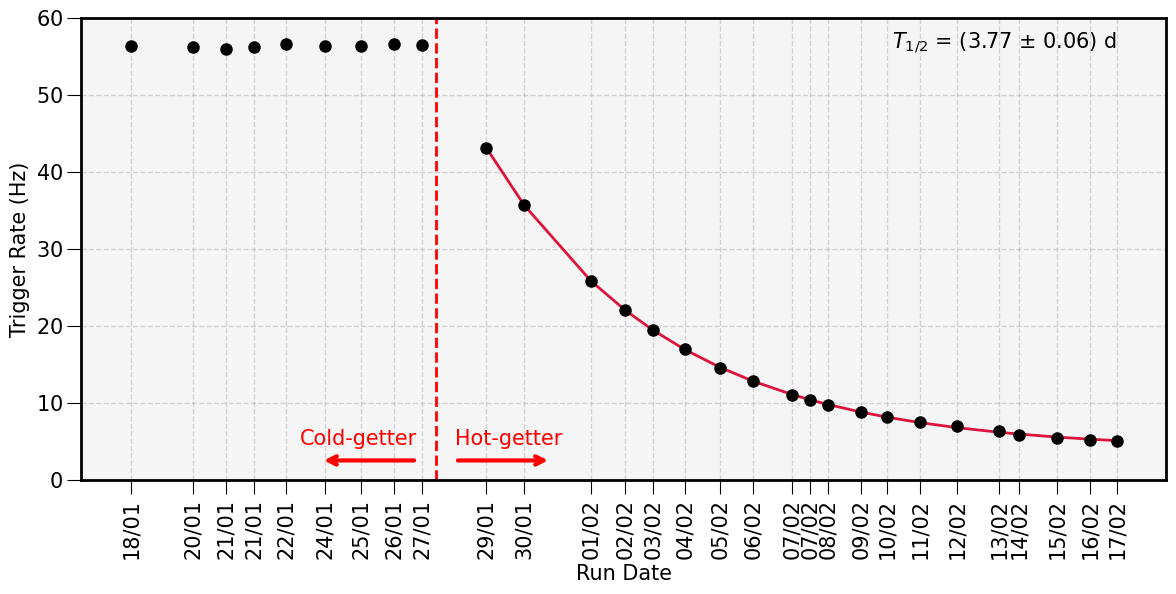

In [49]:
# ----- Plotting ---- #
fig, ax = plt.subplots(figsize=(14, 6))

# Data
plt.errorbar(Date, Rate, xerr=Date_err, yerr=Rate_err, fmt='o', c='black', ecolor='black')
# for x, y, run_id in zip(Date, Rate, Run_numbers):
#     plt.text(x, y, str(run_id), fontsize=10, ha='left', va='bottom', color='blue')  # Run number near the point

# Fit
plt.plot(x_fit, y_fit, color=pt.hist_colors[(1) % len(pt.hist_colors)], label=f'Fit\nχ² / ndof = {chi2 / ndof:.4f}')

# ----- Styling ----- #
# Important text
plt.axvline(x=1737975600, c='red', ls='--')
plt.text(1737975600+5e4, 4.0, 'Hot-getter', c='red', va='bottom', ha='left')
ax.annotate('', xytext=(1737975600+5e4, 2.5), xy=(1737975600+3e5, 2.5), arrowprops=dict(arrowstyle='->',  ec='red', fc='red'))
plt.text(1737975600-5e4, 4.0, 'Cold-getter', c='red', va='bottom', ha='right')
ax.annotate('', xytext=(1737975600-5e4, 2.5), xy=(1737975600-3e5, 2.5), arrowprops=dict(arrowstyle='->',  ec='red', fc='red'))
plt.text(Date.max(), 55, r'$T_{1/2}$'f' = ({CV_lambda:.2f} ± {Error_lambda:.2f}) d', va='bottom', ha='right')

# # Preliminary logo
# LOGO_BOX    = OffsetImage(PRELIM_LOGO, zoom = 0.1)
# xy = (Date.max(), Rate.max())
# ab = AnnotationBbox(LOGO_BOX, xy, xybox=(-67, 0), xycoords='data', boxcoords="offset points",  frameon=False)
# ax.add_artist(ab)

# Axes
plt.xlabel('Run Date')
x_labels = [crudo.epoch_converter(t, h=False) for t in Date]  # Convert x-axis bin edges to readable time format
plt.xticks(Date, x_labels, rotation=90, ha='center')
plt.ylabel('Trigger Rate (Hz)')
plt.ylim(0, 60)
# plt.title('Trigger Real Rate')
# plt.legend(loc='upper right', fontsize=8)

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
# plt.savefig(f'/lhome/ific/c/ccortesp/Analysis/NEXT-100/Rn_analysis/images/Trigger_Rate_Evolution.pdf')
plt.show()

## DAQ Efficiency

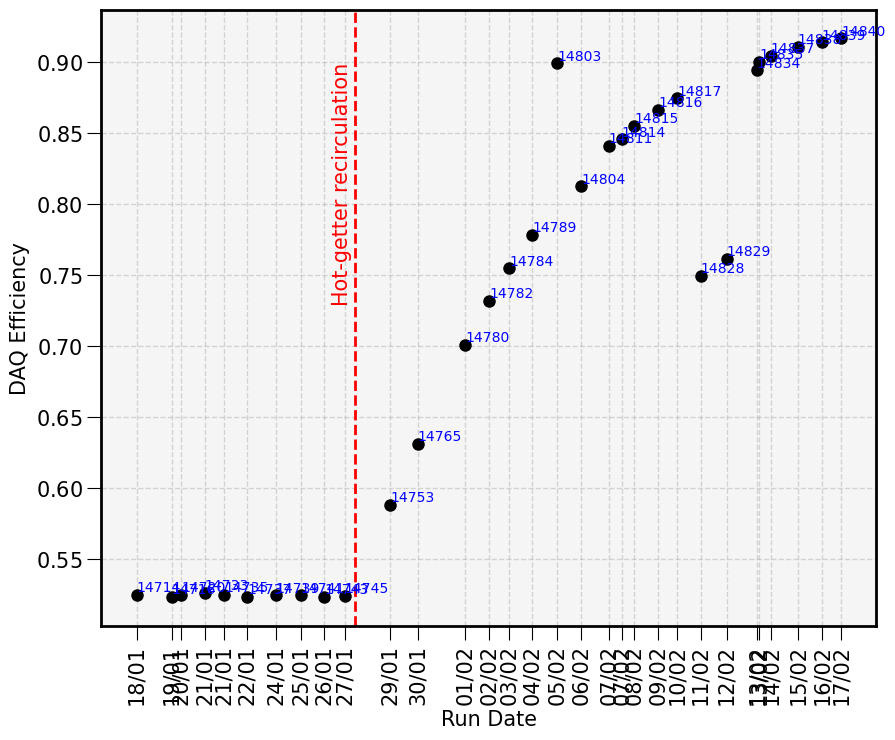

In [15]:
# Global
x_date = []

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_OK   = entry["OK"]
    run_LOST = entry["LOST"]

    # DAQe efficiency + error
    DAQe_CV, DAQe_error = ff.efficiency(run_OK, run_LOST)
    
    # Date information    
    Date_CV    = sel_data[run_id]['time'].mean()
    Date_error = sel_data[run_id]['time'].std() / np.sqrt(len(sel_data[run_id]['time']))
    x_date.append(Date_CV)

    # Plot
    plt.errorbar(Date_CV, DAQe_CV, xerr=Date_error, yerr=DAQe_error, fmt='o', c='black', ecolor='black')
    plt.text(Date_CV, DAQe_CV, str(run_id), fontsize=10, ha='left', va='bottom', color='blue')   # Run number near the point

# Important dates
plt.axvline(x=1737975600, c='red', ls='--')
plt.text(1737975600-1e4, 0.9, 'Hot-getter recirculation', c='red', va='top', ha='right', rotation=90)

# Styling
plt.xlabel('Run Date')
x_labels = [crudo.epoch_converter(t, h=False) for t in x_date]  # Convert x-axis bin edges to readable time format
plt.xticks(x_date, x_labels, rotation=90, ha='center')
plt.ylabel('DAQ Efficiency')

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.show()

## Reconstructed Events

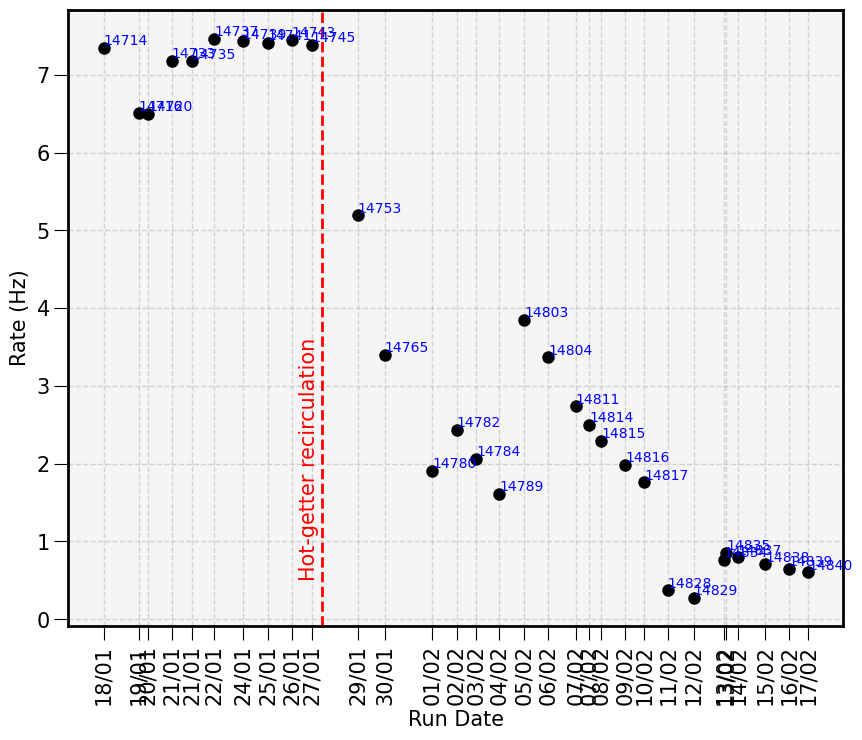

In [16]:
# Global
x_date = []

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_long = entry["duration"]
    run_OK   = entry["OK"]
    run_LOST = entry["LOST"]

    # DAQe efficiency + error
    DAQe_CV, DAQe_error = ff.efficiency(run_OK, run_LOST)
    
    # Date information    
    Date_CV    = sel_data[run_id]['time'].mean()
    Date_error = sel_data[run_id]['time'].std() / np.sqrt(len(sel_data[run_id]['time']))
    x_date.append(Date_CV)
    
    # Reco events
    reco_evts  = entry['reco_evt_CV'];  reco_evts = int(reco_evts)
    reco_CV, reco_var = scipy.stats.binom.stats(n=run_OK, p=reco_evts/run_OK, moments='mv')
    
    # Reco rate + error for each run
    rate_CV  = reco_CV / (run_long * DAQe_CV)
    rate_err = rate_CV * np.sqrt((np.sqrt(reco_var) / reco_CV)**2 + (DAQe_error / DAQe_CV)**2)

    # Plot
    plt.errorbar(Date_CV, rate_CV, xerr=Date_error, yerr=rate_err, fmt='o', c='black', ecolor='black')
    plt.text(Date_CV, rate_CV, str(run_id), fontsize=10, ha='left', va='bottom', color='blue')   # Run number near the point

# Important dates
plt.axvline(x=1737975600, c='red', ls='--')
plt.text(1737975600-1e4, 0.5, 'Hot-getter recirculation', c='red', va='bottom', ha='right', rotation=90)

# Styling
plt.xlabel('Run Date')
x_labels = [crudo.epoch_converter(t, h=False) for t in x_date]  # Convert x-axis bin edges to readable time format
plt.xticks(x_date, x_labels, rotation=90, ha='center')
plt.ylabel('Rate (Hz)')
# plt.title(r'Reconstructed Events')

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.show()

## $\alpha$ Candidates

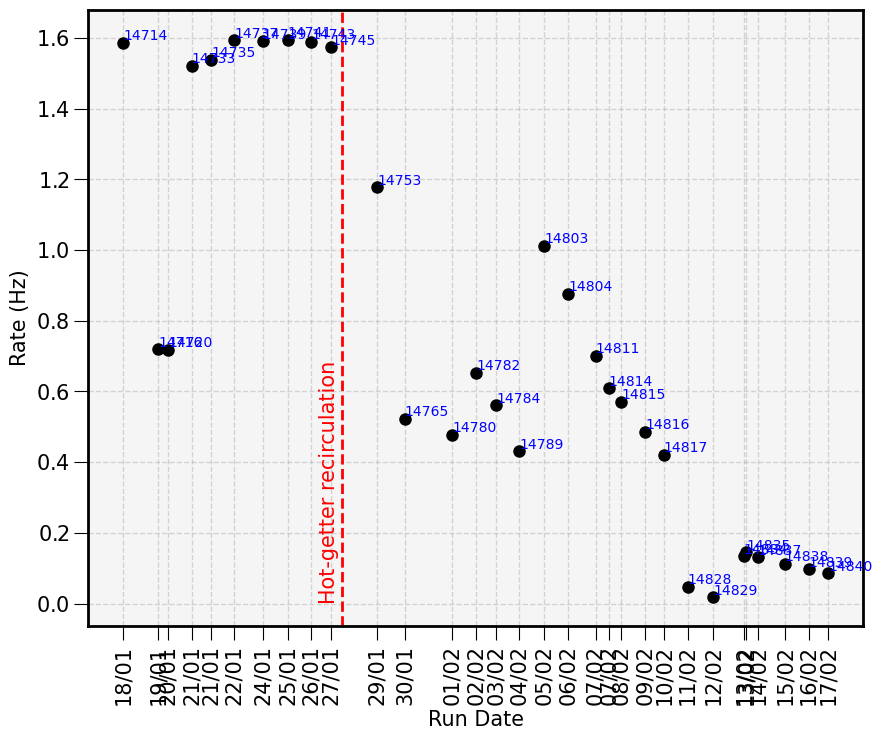

In [17]:
# Global
x_date = []

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_long = entry["duration"]
    run_OK   = entry["OK"]
    run_LOST = entry["LOST"]

    # DAQe efficiency + error
    DAQe_CV, DAQe_error = ff.efficiency(run_OK, run_LOST)
    
    # Date information    
    Date_CV    = sel_data[run_id]['time'].mean()
    Date_error = sel_data[run_id]['time'].std() / np.sqrt(len(sel_data[run_id]['time']))
    x_date.append(Date_CV)
    
    # Reco events
    reco_evts  = entry['sel_evt_CV'];  reco_evts = int(reco_evts)
    reco_CV, reco_var = scipy.stats.binom.stats(n=run_OK, p=reco_evts/run_OK, moments='mv')
    
    # Reco rate + error for each run
    rate_CV  = reco_CV / (run_long * DAQe_CV)
    rate_err = rate_CV * np.sqrt((np.sqrt(reco_var) / reco_CV)**2 + (DAQe_error / DAQe_CV)**2)

    # Plot
    plt.errorbar(Date_CV, rate_CV, xerr=Date_error, yerr=rate_err, fmt='o', c='black', ecolor='black')
    plt.text(Date_CV, rate_CV, str(run_id), fontsize=10, ha='left', va='bottom', color='blue')   # Run number near the point

# Important dates
plt.axvline(x=1737975600, c='red', ls='--')
plt.text(1737975600-1e4, 0, 'Hot-getter recirculation', c='red', va='bottom', ha='right', rotation=90)

# Styling
plt.xlabel('Run Date')
x_labels = [crudo.epoch_converter(t, h=False) for t in x_date]  # Convert x-axis bin edges to readable time format
plt.xticks(x_date, x_labels, rotation=90, ha='center')
plt.ylabel('Rate (Hz)')
# plt.title(r'$\alpha$ Candidates')

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.show()

# Fits
To fit data we just use the population of the detector's center, where the information is quite uniform.

In [28]:
# Store fits information
FIT_PARAMETERS = {run["run_number"]: {} for run in runs_info}

## $S1e$ vs DT

Run 14714 Fit: m = (0.57 ± 0.00) PE/μs, b = (791.15 ± 1.72) PE
χ² / ndof = 1.7501


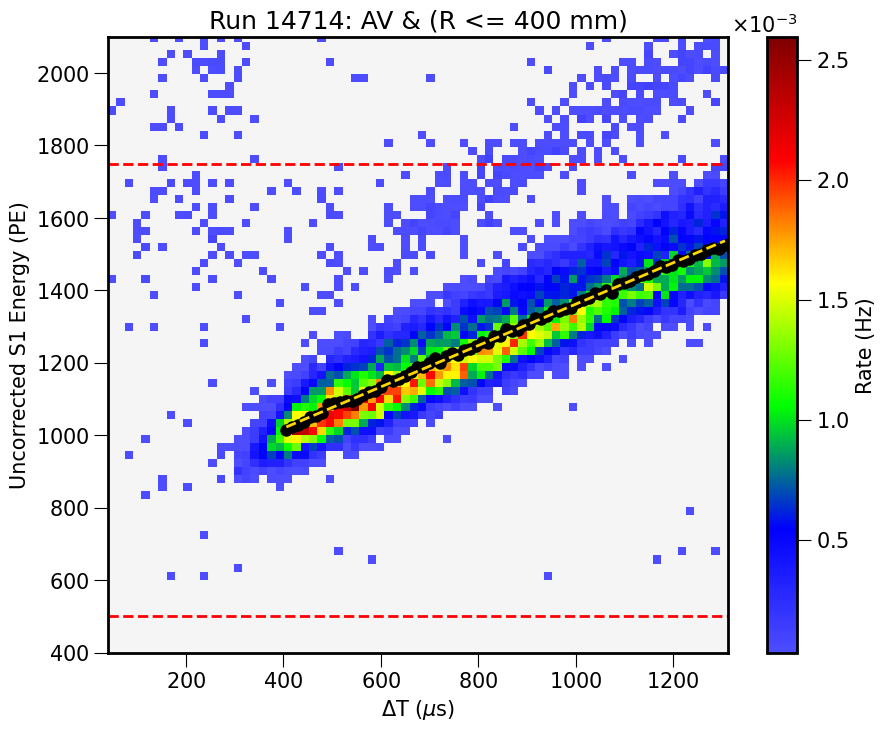

Run 14716 Fit: m = (0.58 ± 0.01) PE/μs, b = (785.73 ± 4.75) PE
χ² / ndof = 1.2072


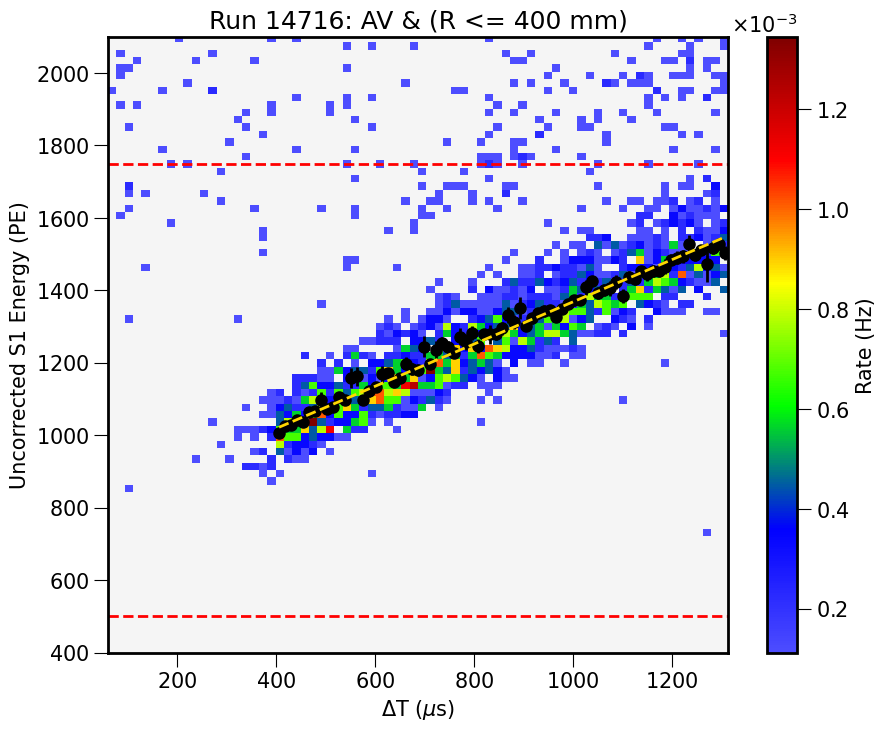

Run 14720 Fit: m = (0.54 ± 0.01) PE/μs, b = (824.05 ± 4.54) PE
χ² / ndof = 1.2244


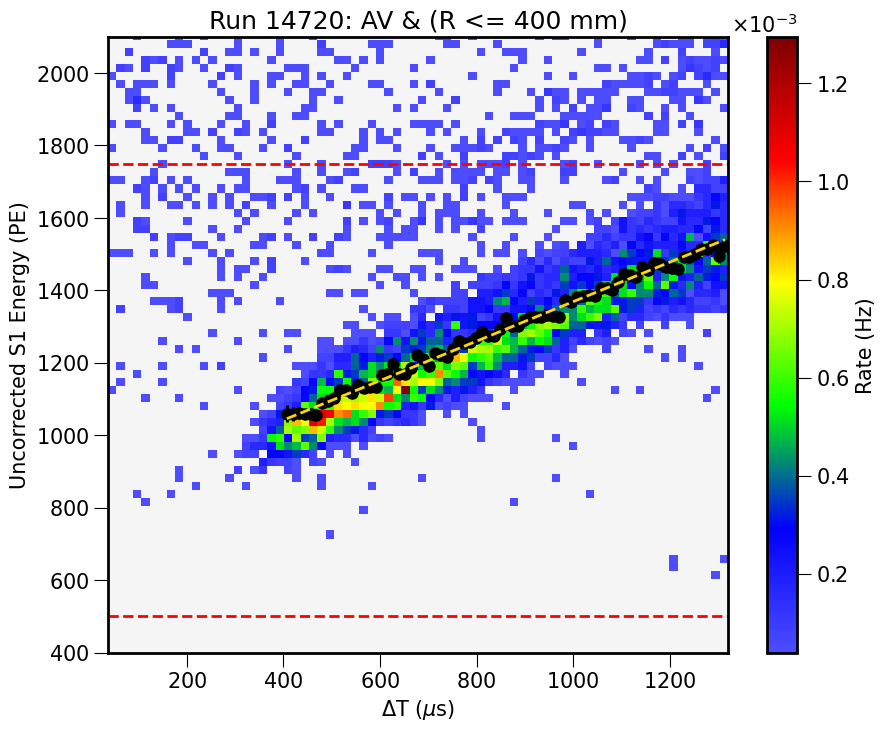

Run 14733 Fit: m = (0.57 ± 0.00) PE/μs, b = (791.44 ± 1.86) PE
χ² / ndof = 1.6710


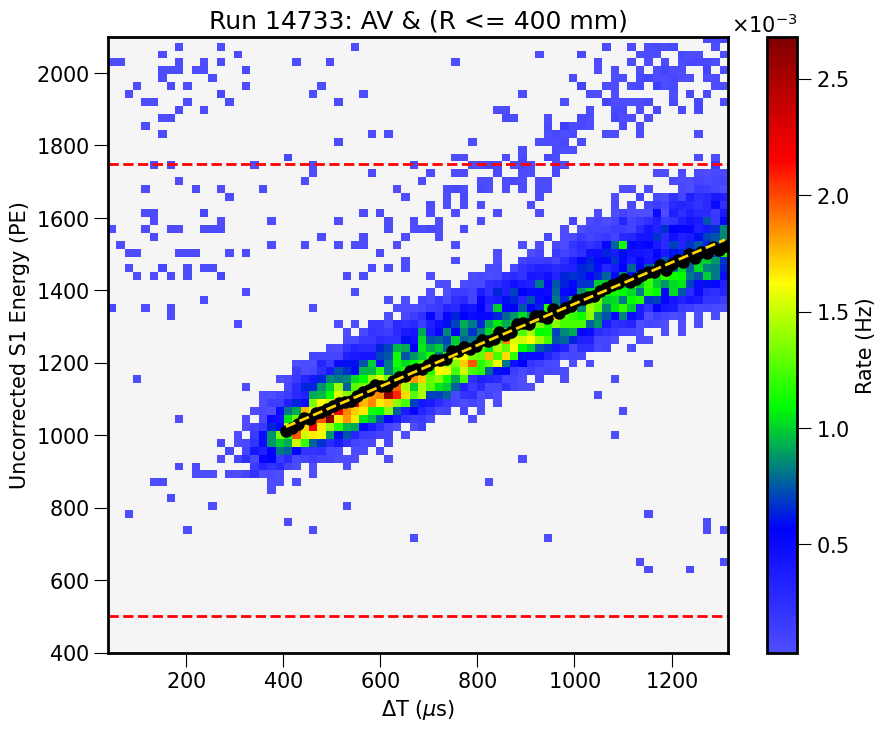

Run 14735 Fit: m = (0.57 ± 0.00) PE/μs, b = (795.59 ± 1.52) PE
χ² / ndof = 1.9418


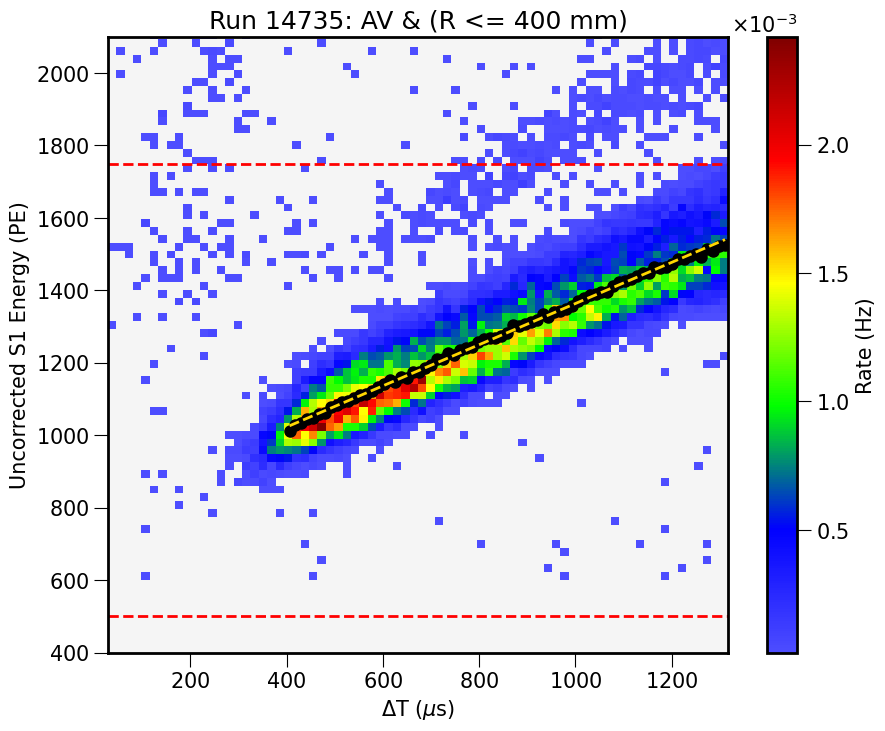

Run 14737 Fit: m = (0.56 ± 0.00) PE/μs, b = (798.95 ± 1.56) PE
χ² / ndof = 1.8960


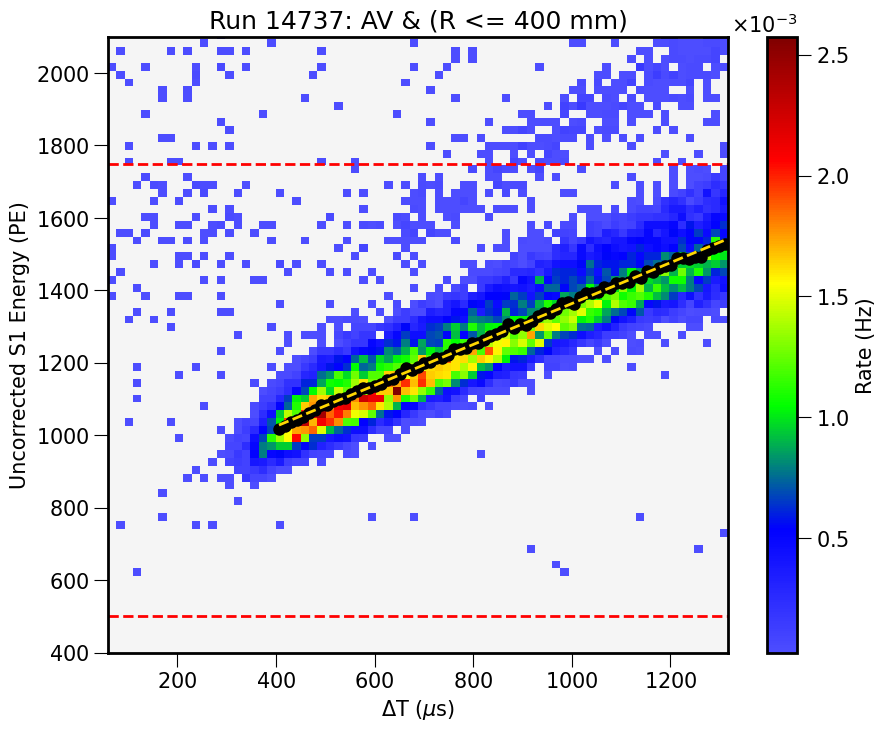

Run 14739 Fit: m = (0.57 ± 0.00) PE/μs, b = (796.53 ± 1.46) PE
χ² / ndof = 1.8480


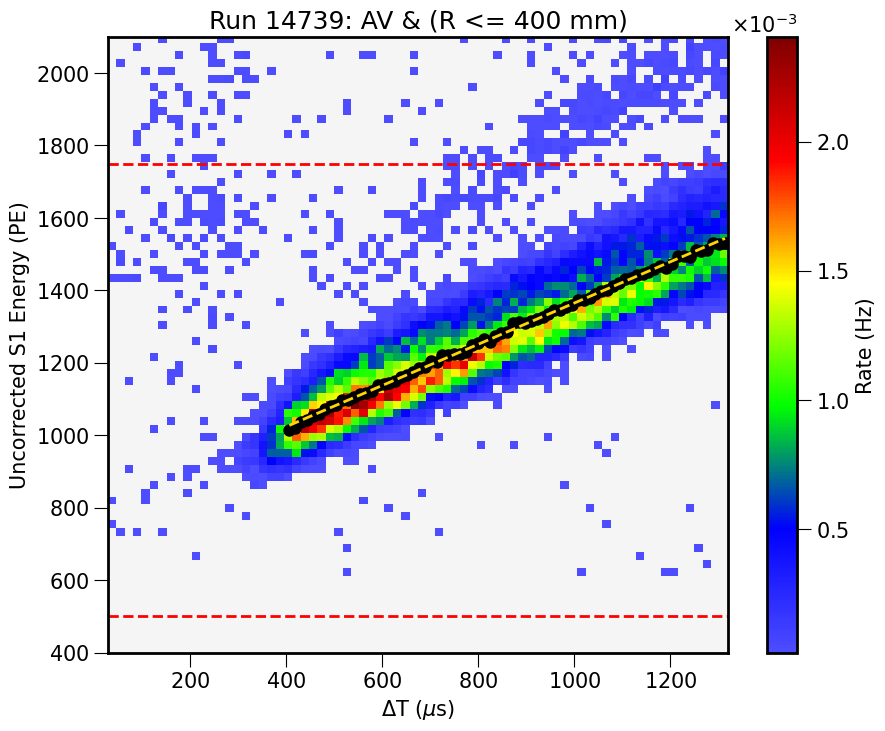

Run 14741 Fit: m = (0.57 ± 0.00) PE/μs, b = (794.90 ± 1.44) PE
χ² / ndof = 2.3097


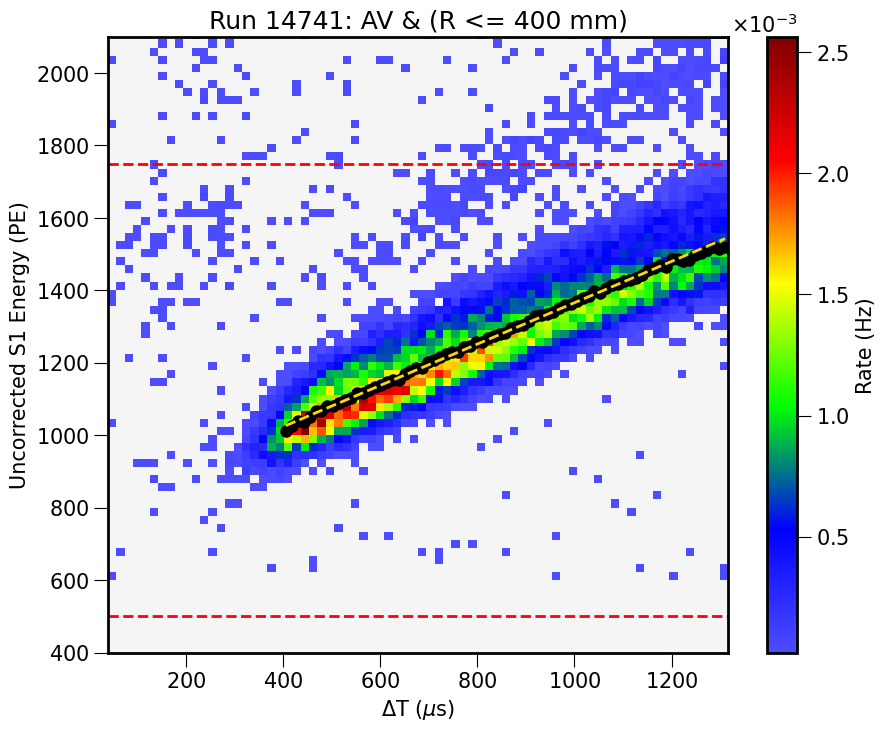

Run 14743 Fit: m = (0.57 ± 0.00) PE/μs, b = (793.86 ± 1.48) PE
χ² / ndof = 2.4317


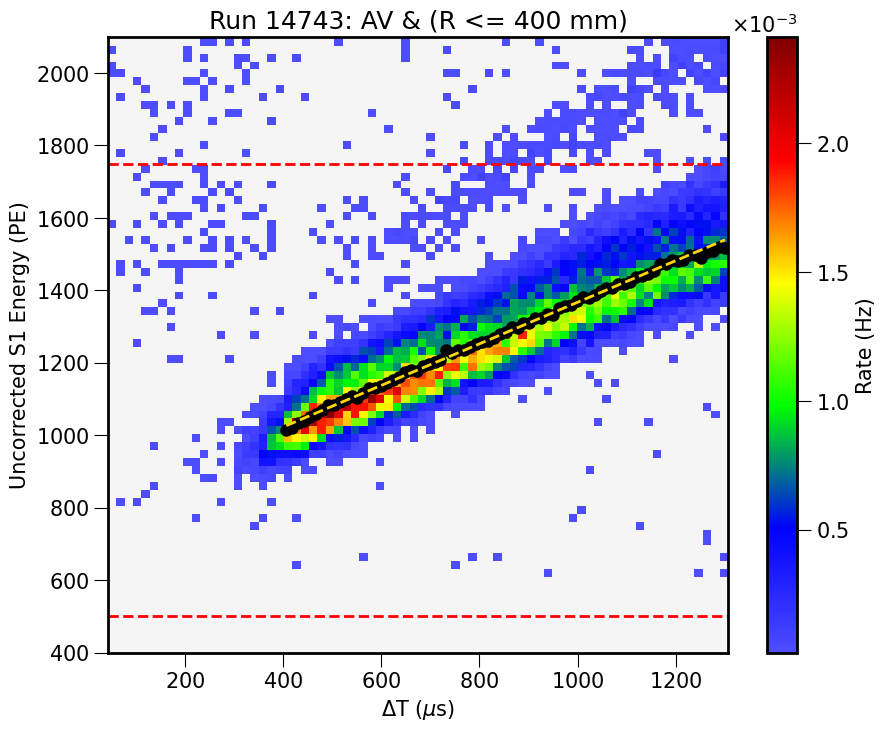

Run 14745 Fit: m = (0.57 ± 0.00) PE/μs, b = (797.58 ± 1.74) PE
χ² / ndof = 1.7599


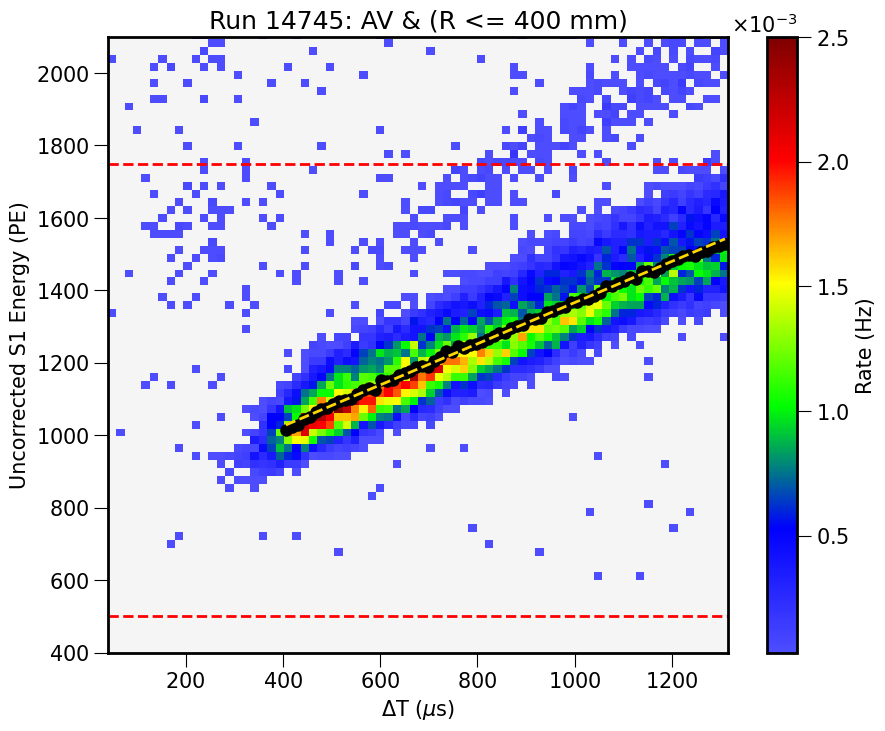

Run 14753 Fit: m = (0.57 ± 0.00) PE/μs, b = (795.16 ± 1.57) PE
χ² / ndof = 2.1951


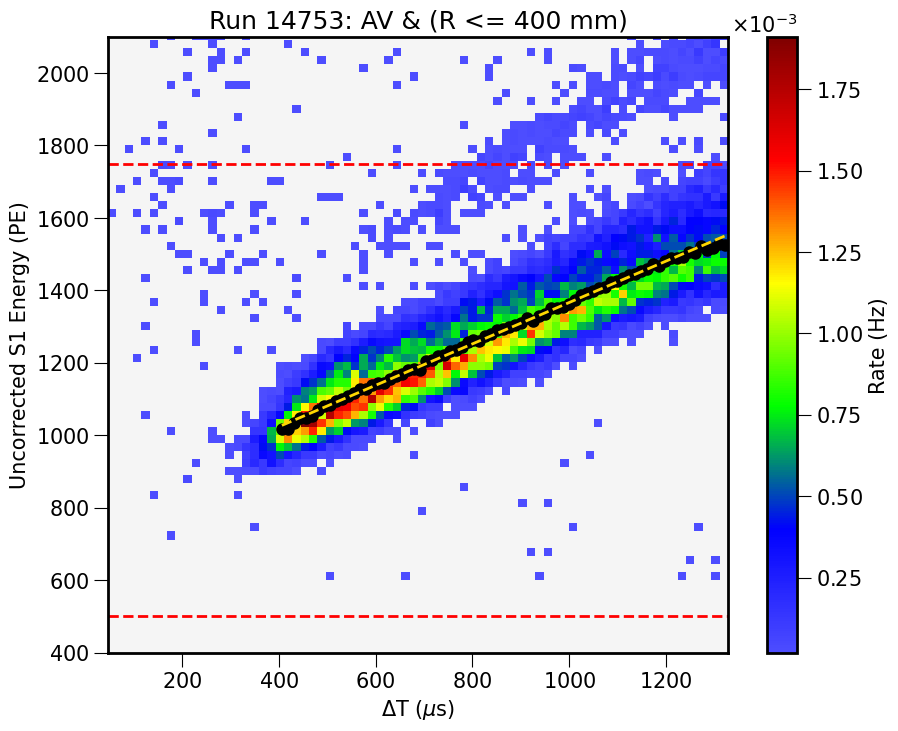

Run 14765 Fit: m = (0.53 ± 0.00) PE/μs, b = (830.02 ± 4.03) PE
χ² / ndof = 1.1378


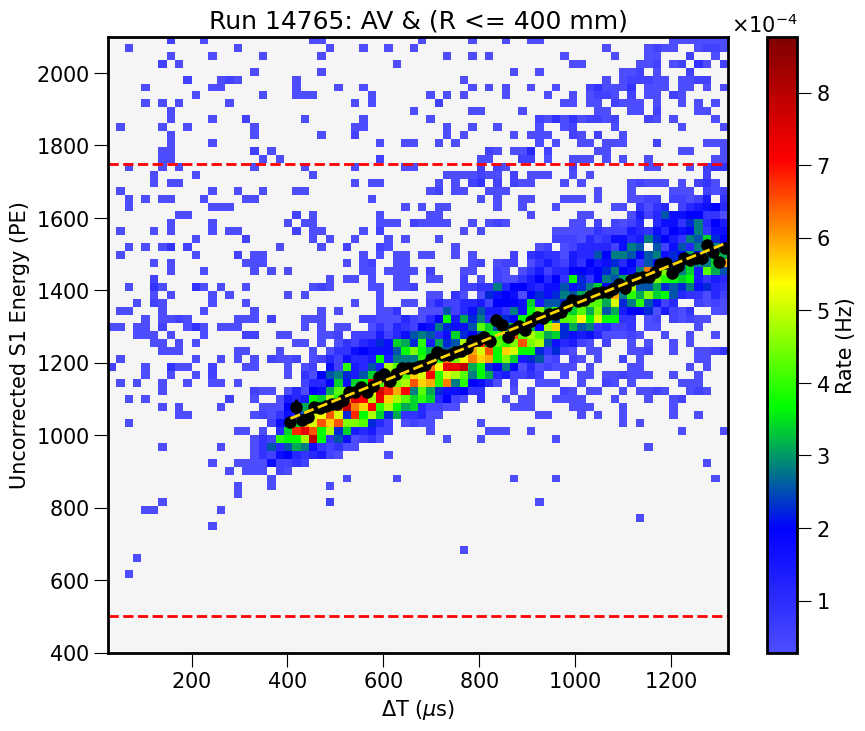

Run 14780 Fit: m = (0.56 ± 0.00) PE/μs, b = (835.39 ± 2.83) PE
χ² / ndof = 1.3082


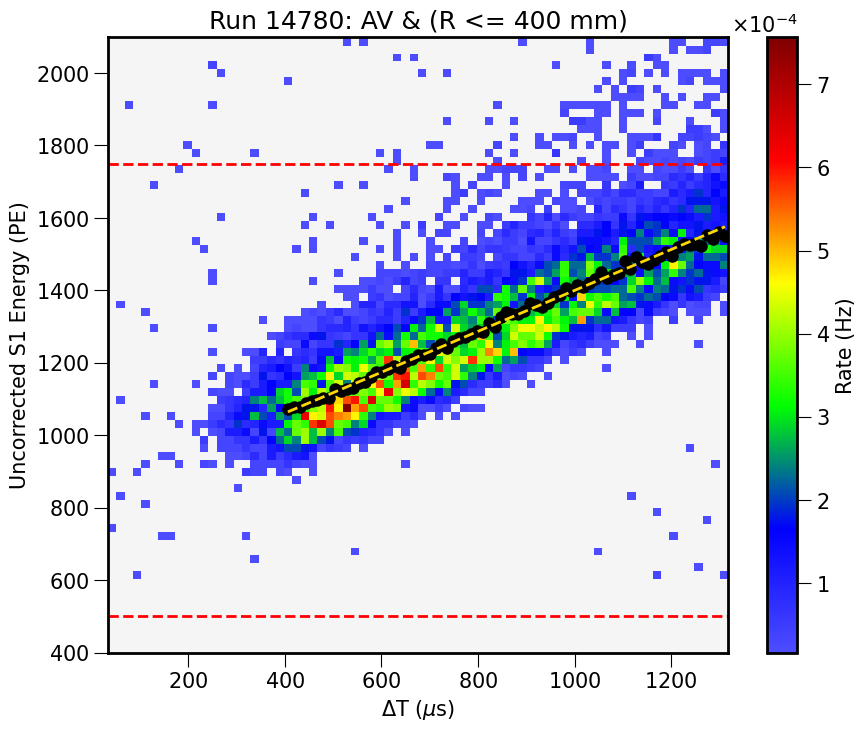

Run 14782 Fit: m = (0.58 ± 0.00) PE/μs, b = (794.77 ± 1.79) PE
χ² / ndof = 2.0049


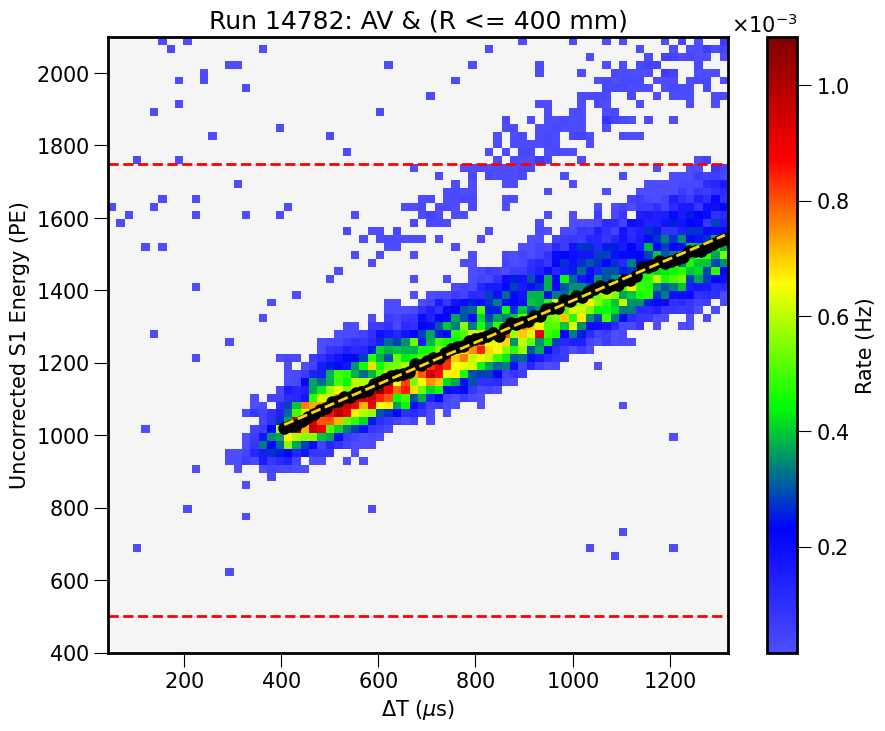

Run 14784 Fit: m = (0.57 ± 0.00) PE/μs, b = (798.92 ± 2.31) PE
χ² / ndof = 1.2505


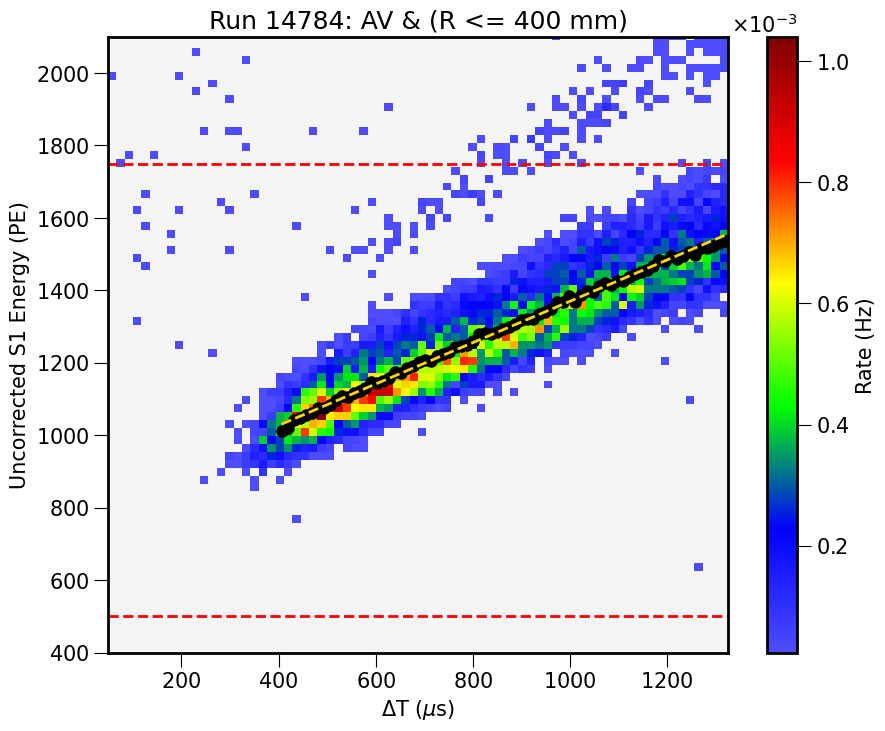

Run 14789 Fit: m = (0.58 ± 0.00) PE/μs, b = (795.42 ± 2.33) PE
χ² / ndof = 1.1953


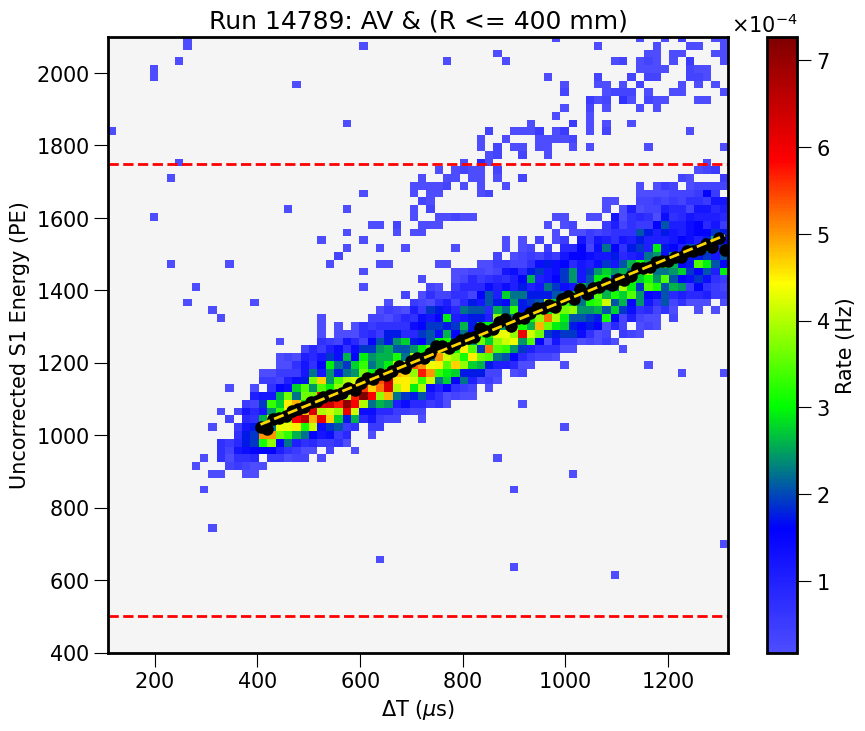

Run 14803 Fit: m = (0.50 ± 0.00) PE/μs, b = (700.18 ± 0.97) PE
χ² / ndof = 2.3568


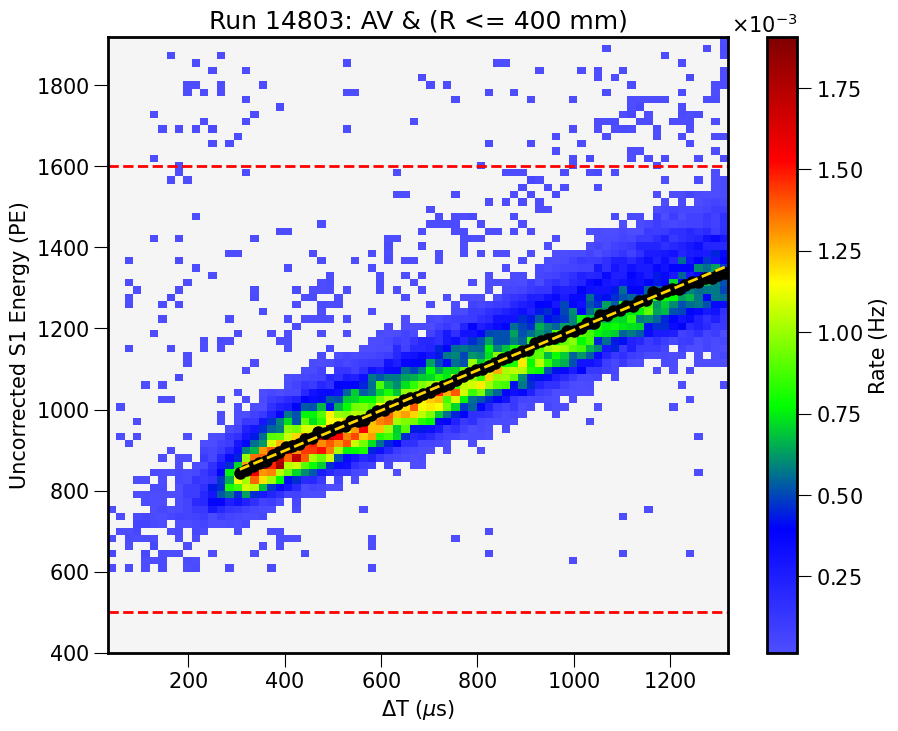

Run 14804 Fit: m = (0.50 ± 0.00) PE/μs, b = (699.62 ± 1.13) PE
χ² / ndof = 1.4181


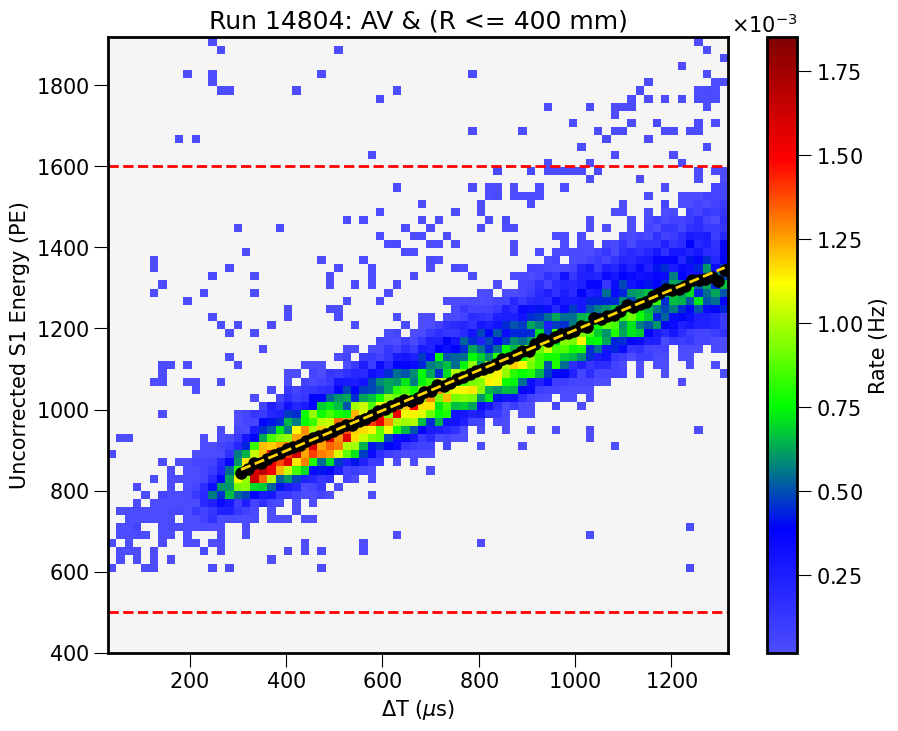

Run 14811 Fit: m = (0.49 ± 0.00) PE/μs, b = (700.80 ± 1.46) PE
χ² / ndof = 1.2504


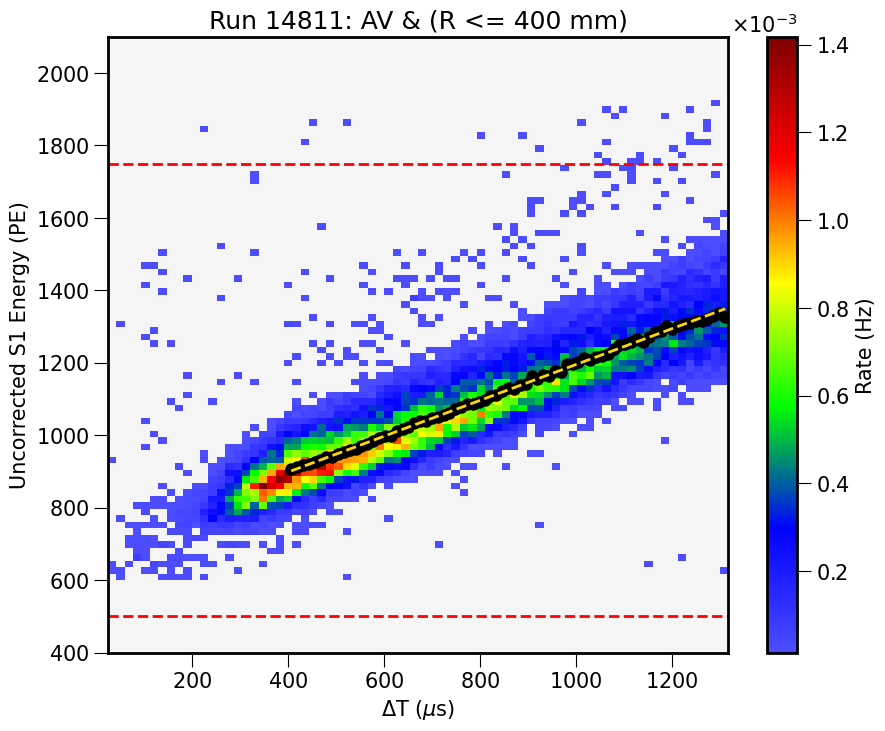

Run 14814 Fit: m = (0.49 ± 0.00) PE/μs, b = (702.70 ± 3.79) PE
χ² / ndof = 1.0688


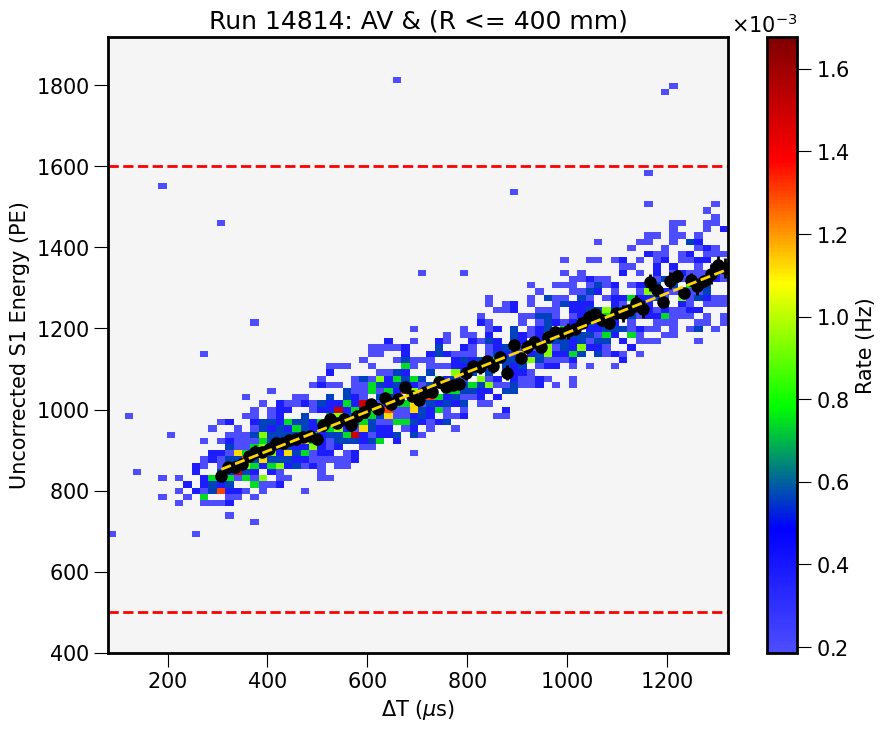

Run 14815 Fit: m = (0.50 ± 0.00) PE/μs, b = (697.40 ± 1.22) PE
χ² / ndof = 1.6063


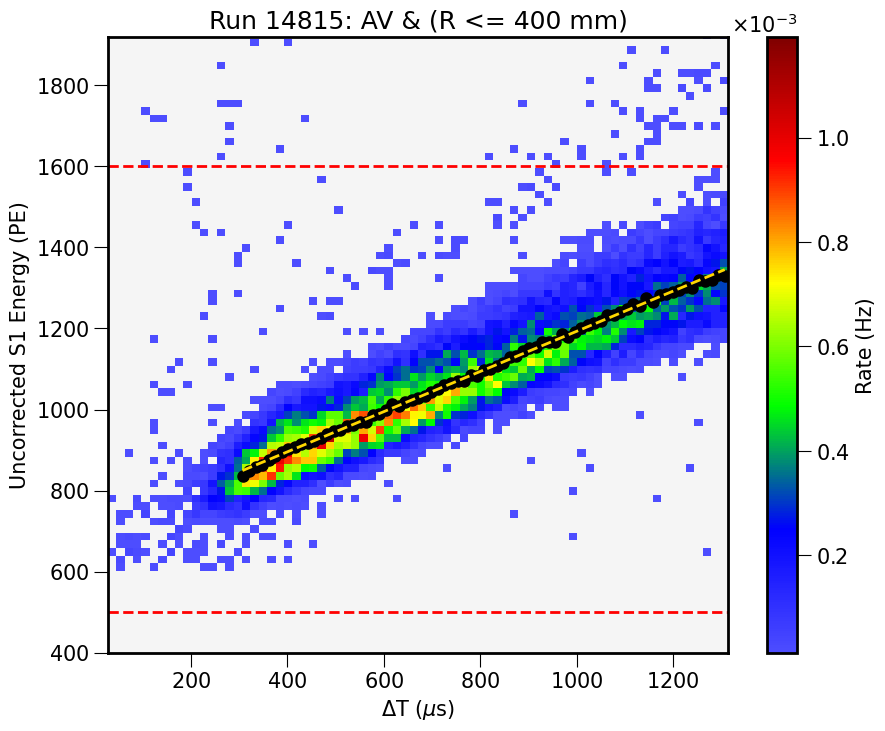

Run 14816 Fit: m = (0.49 ± 0.00) PE/μs, b = (699.96 ± 1.34) PE
χ² / ndof = 1.4569


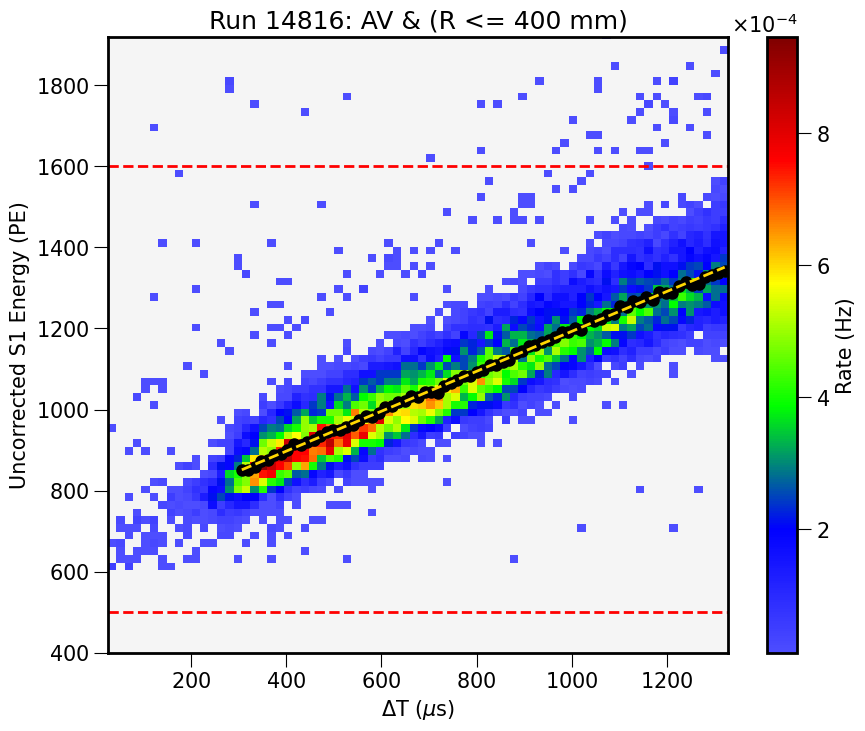

Run 14817 Fit: m = (0.49 ± 0.00) PE/μs, b = (699.94 ± 1.83) PE
χ² / ndof = 1.0568


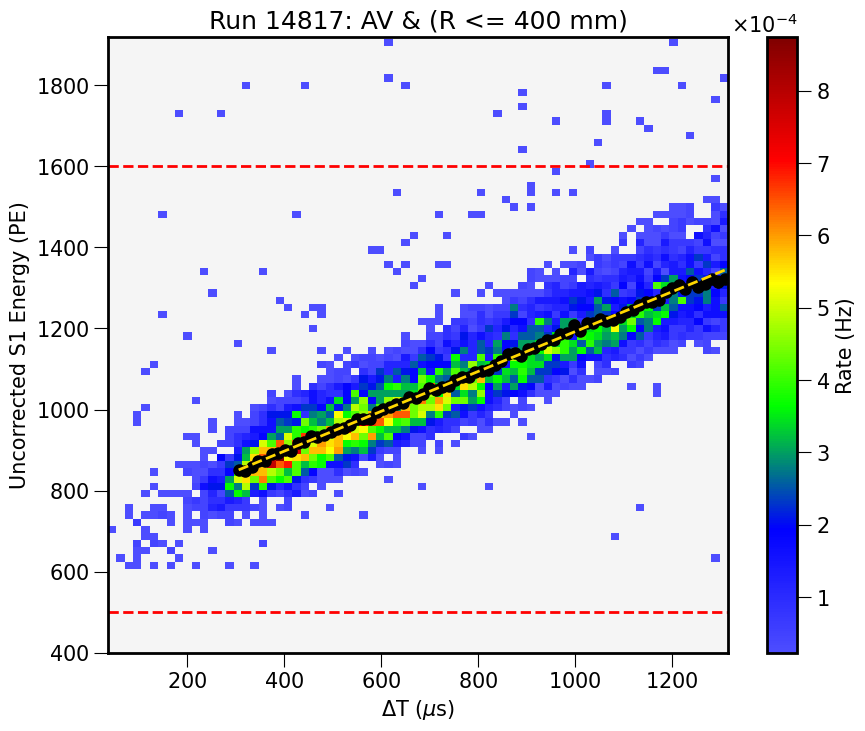

Run 14828 Fit: m = (0.50 ± 0.01) PE/μs, b = (693.67 ± 4.92) PE
χ² / ndof = 1.0790


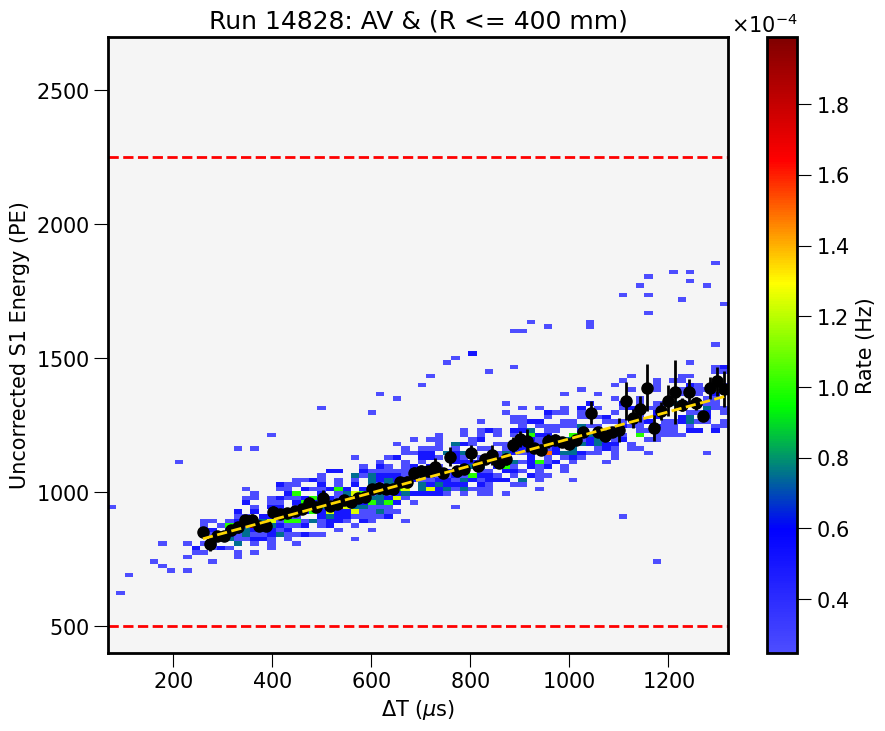

Run 14829 Fit: m = (0.64 ± 0.00) PE/μs, b = (865.70 ± 5.54) PE
χ² / ndof = 2.0231


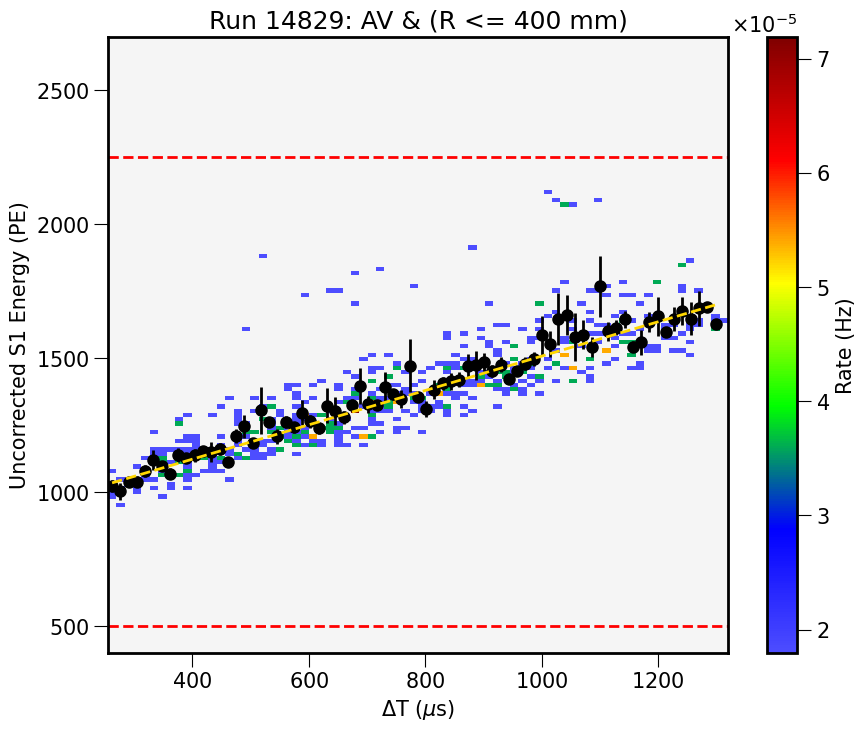

Run 14834 Fit: m = (0.70 ± 0.01) PE/μs, b = (792.98 ± 3.54) PE
χ² / ndof = 5.3583


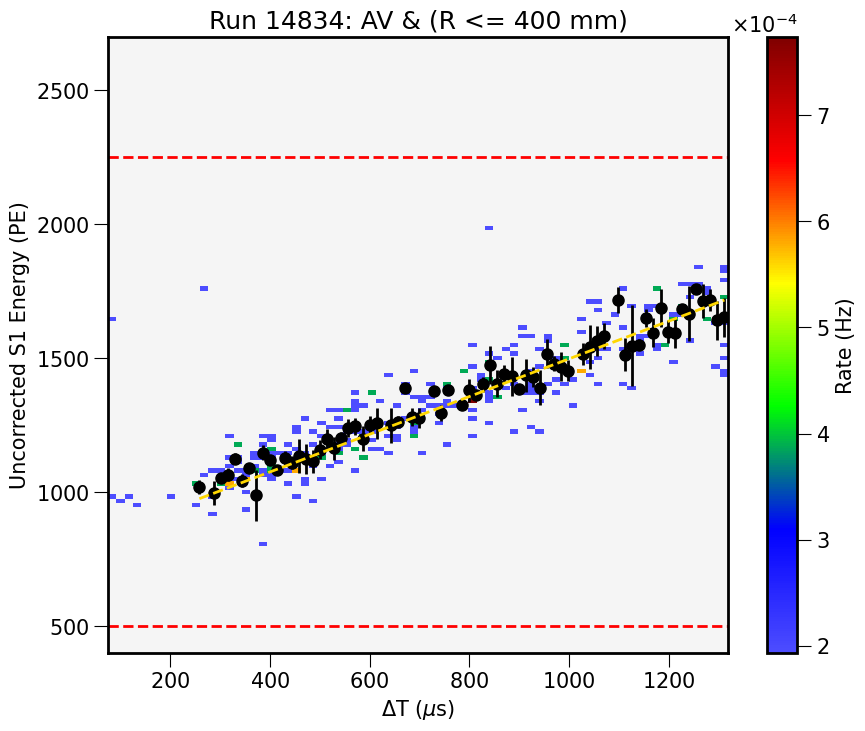

Run 14835 Fit: m = (0.64 ± 0.01) PE/μs, b = (858.68 ± 6.63) PE
χ² / ndof = 1.8406


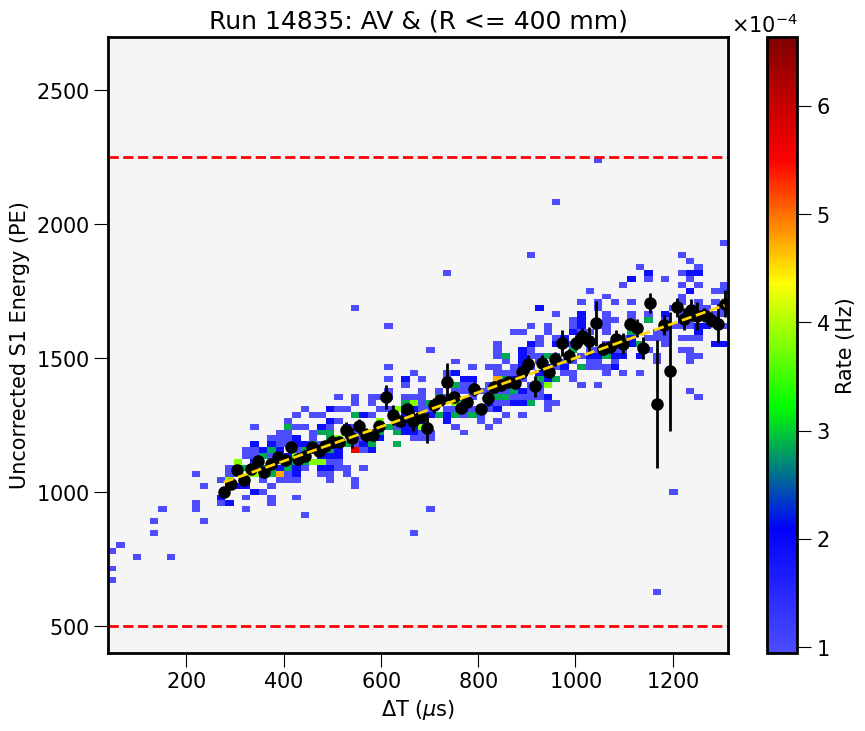

Run 14837 Fit: m = (0.63 ± 0.00) PE/μs, b = (878.31 ± 3.48) PE
χ² / ndof = 1.7180


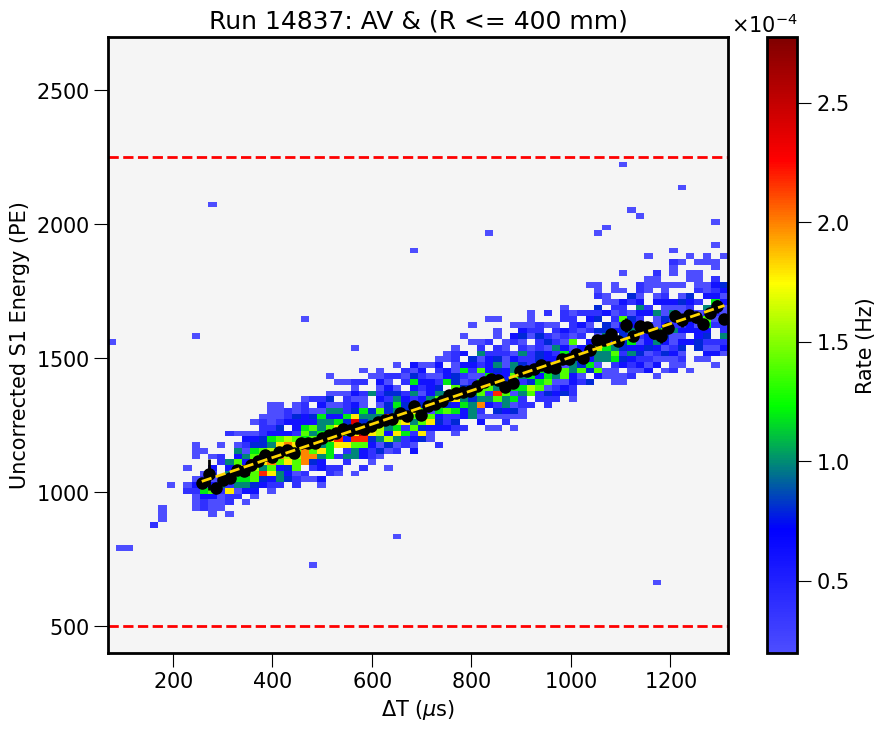

Run 14838 Fit: m = (0.63 ± 0.00) PE/μs, b = (877.40 ± 3.36) PE
χ² / ndof = 1.0160


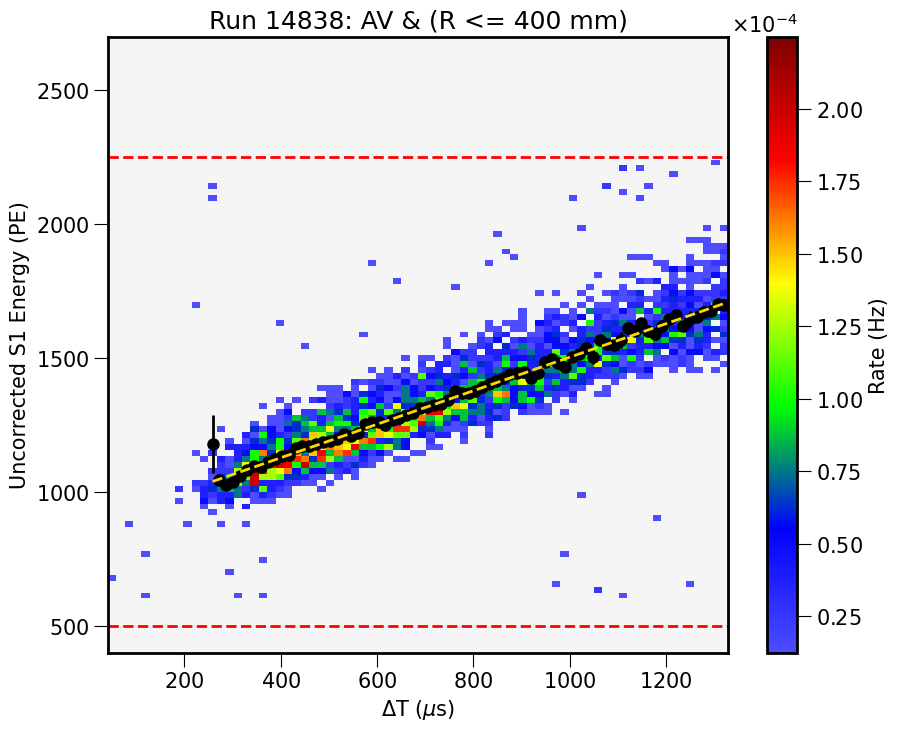

Run 14839 Fit: m = (0.64 ± 0.00) PE/μs, b = (870.67 ± 3.49) PE
χ² / ndof = 1.4241


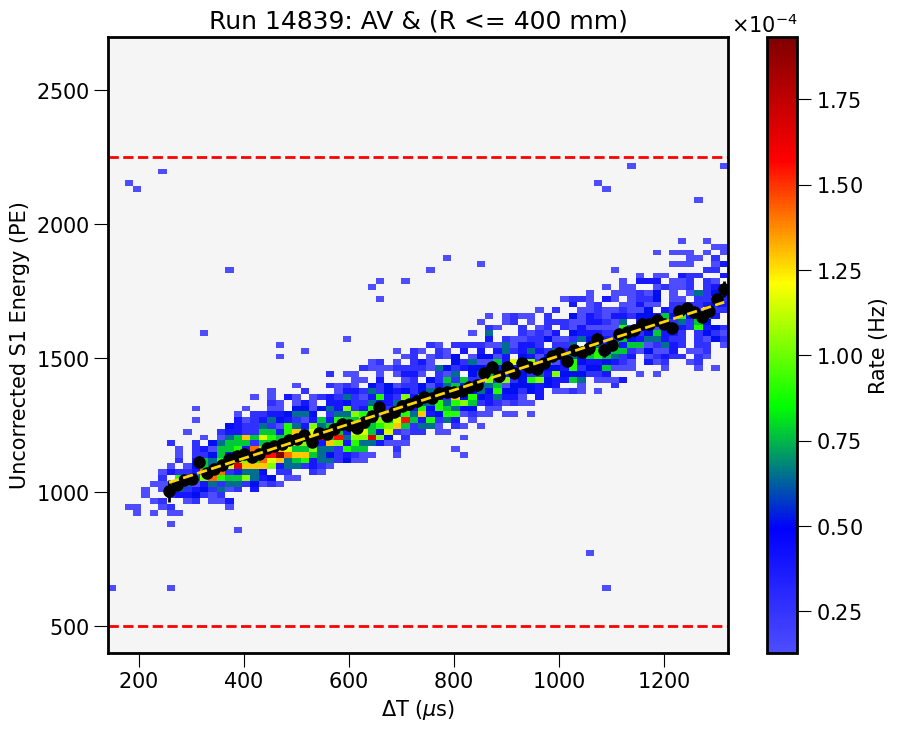

Run 14840 Fit: m = (0.62 ± 0.01) PE/μs, b = (877.12 ± 4.81) PE
χ² / ndof = 1.3607


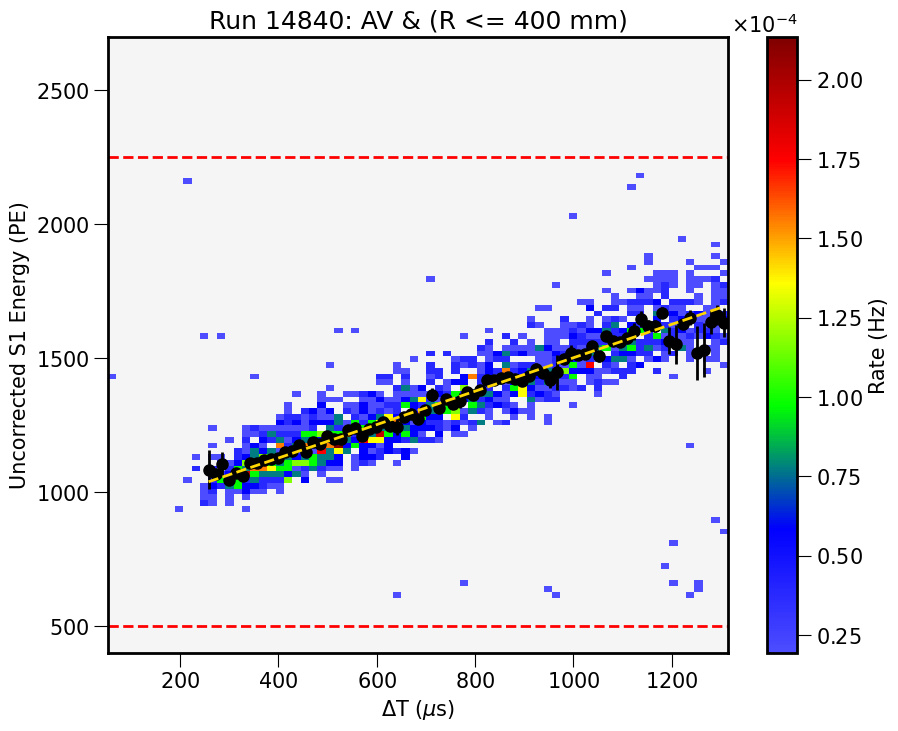

In [29]:
# Global
rad_lim = 400
n_bins  = 75

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_long = entry["duration"]
    run_OK   = entry["OK"]
    run_LOST = entry["LOST"]
    
    # DAQe efficiency + error
    DAQe_CV, DAQe_error = ff.efficiency(run_OK, run_LOST)

    # Variables    
    E1 = sel_data[run_id]['S1e']
    DT = sel_data[run_id]['DT']
    R  = sel_data[run_id]['R']

    # Masking
    rad_mask = (R <= rad_lim)
    E1_mask  = E1[AV_mask[run_id] & rad_mask]
    DT_mask  = DT[AV_mask[run_id] & rad_mask]

    # 2D histogram: normalized by corrected DAQ data taking time
    S1e_DT_map, ex, ey = pt.hist_2D(DT_mask, E1_mask, x_bins=n_bins, y_bins=n_bins)
    S1e_DT_map         = S1e_DT_map / (run_long * DAQe_CV)                           
    S1e_DT_map         = np.ma.masked_where(S1e_DT_map==0, S1e_DT_map)                # Zero values masked

    # ----- Linear Fit ----- #
    # Preliminary
    DT_down = 400;    DT_up = DT_mask.max()
    E1_down = 500;    E1_up = 1750
    if run_id in {14803, 14804, 14814, 14815, 14816, 14817}:
        DT_down = 300;    DT_up = DT_mask.max()
        E1_down = 500;    E1_up = 1600
    if run_id in {14828, 14829, 14834, 14835, 14837, 14838, 14839, 14840}:
        DT_down = 250;    DT_up = DT_mask.max()
        E1_down = 500;    E1_up = 2250

    # Filter the data for the fit
    fit_region_mask = (DT_mask >= DT_down) & (DT_mask <= DT_up) & \
                      (E1_mask >= E1_down) & (E1_mask <= E1_up)
    DT_fit = DT_mask[fit_region_mask]
    E1_fit = E1_mask[fit_region_mask]

    # Compute representative values for the fit
    DT_centers, DT_errors, S1e_means, S1e_errors = ff.prefit_2D(DT_fit, E1_fit, bins=n_bins)
    # Filter out points with zero error (bins with 1 event)
    valid_points = S1e_errors > 0
    DT_centers = DT_centers[valid_points];      DT_errors  = DT_errors[valid_points]
    S1e_means  = S1e_means[valid_points];       S1e_errors = S1e_errors[valid_points]

    # Definte the cost function + initial guess
    least_squares = LeastSquares(DT_centers, S1e_means, S1e_errors, ff.linear_func)
    init_guess = [10, S1e_means.min()]
    # print(f'\nInitial guess: m = {init_guess[0]:.4f} PE/μs, b = {init_guess[1]:.4f} PE')

    # Define the Minuit object
    m = Minuit(least_squares, *init_guess)

    # Minimization process of the cost function and error estimation
    m.migrad()
    m.hesse()

    # Results
    popt = m.values;  perr = m.errors
    print(f'Run {run_id} Fit: m = ({popt[0]:.2f} ± {perr[0]:.2f}) PE/μs, b = ({popt[1]:.2f} ± {perr[1]:.2f}) PE')    
    FIT_PARAMETERS[run_id]["S1e"] = {"m_CV": popt[0], "m_err": perr[0], "b_CV": popt[1], "b_err": perr[1]}

    # Reduced chi-square
    chi2 = m.fval
    ndof = len(DT_centers) - m.nfit
    print(f"χ² / ndof = {chi2 / ndof:.4f}")

    # ----- Plotting ----- #
    # plt.figure(figsize=(8, 6))

    # Data
    plt.pcolormesh(ex, ey, S1e_DT_map.T, cmap=pt.custom_hsv, shading='auto')    
    cbar = plt.colorbar(label='Rate (Hz)', shrink=1.0)
    # cbar.formatter.set_powerlimits((-3, -3))

    # Fit
    fit_y = ff.linear_func(DT_centers, *popt)
    plt.errorbar(DT_centers, S1e_means, xerr=DT_errors, yerr=S1e_errors, fmt='o', c='black', ecolor='black')
    plt.plot(DT_centers, fit_y, c='gold', ls='--', zorder=3)
    plt.axhline(y=E1_up, c='red', ls='--')
    plt.axhline(y=E1_down, c='red', ls='--')

    # ----- Styling ----- #
    plt.xlabel('$\Delta$T ($\mu$s)')
    plt.ylabel('Uncorrected S1 Energy (PE)')
    plt.ylim(0.8*E1_down, 1.2*E1_up)
    plt.title(f'Run {run_id}: AV & (R <= {rad_lim} mm)')

    plt.gca().set_facecolor("whitesmoke")
    # plt.savefig(f'/lhome/ific/c/ccortesp/Analysis/NEXT-100/Rn_analysis/images/S1e_DT_fit_run{run_id}.pdf')
    plt.show() 

## $S2e$ vs DT: Lifetime

Run 14714 fit: N0 = (826898.18 ± 714.02) PE, τ = (48.11 ± 2.32) ms
χ² / ndof = 1.8896


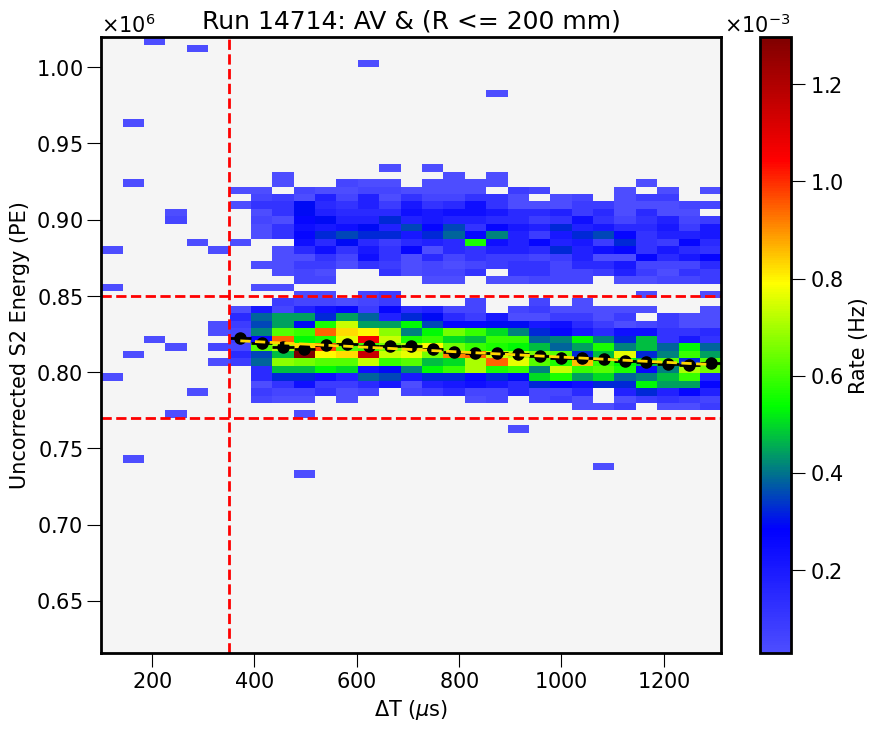

Run 14716 fit: N0 = (834485.46 ± 2116.19) PE, τ = (38.47 ± 4.24) ms
χ² / ndof = 1.4794


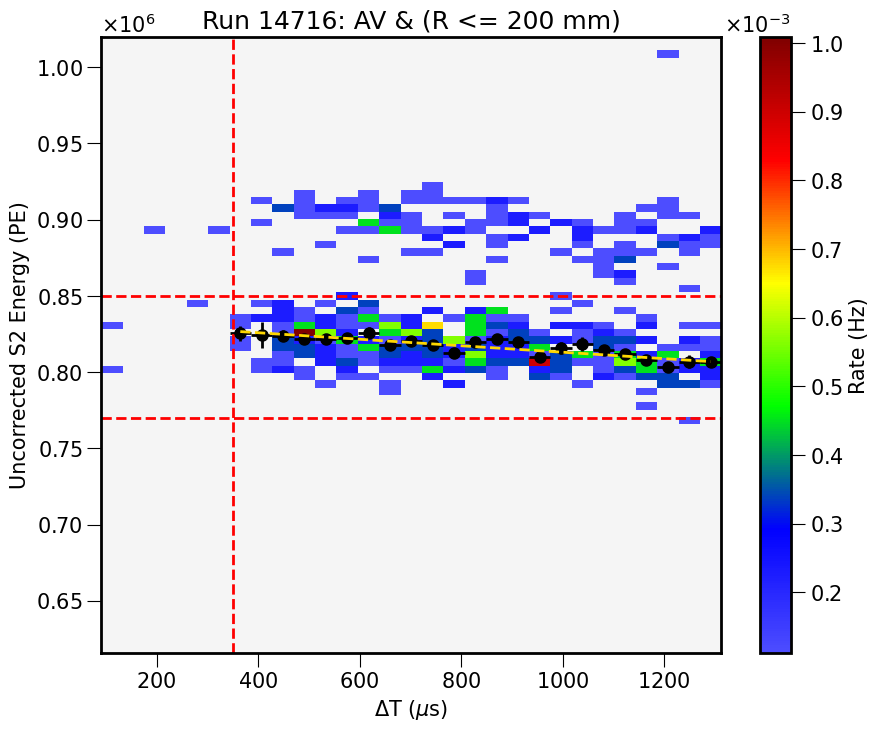

Run 14720 fit: N0 = (827722.20 ± 1266.46) PE, τ = (56.42 ± 5.59) ms
χ² / ndof = 1.2631


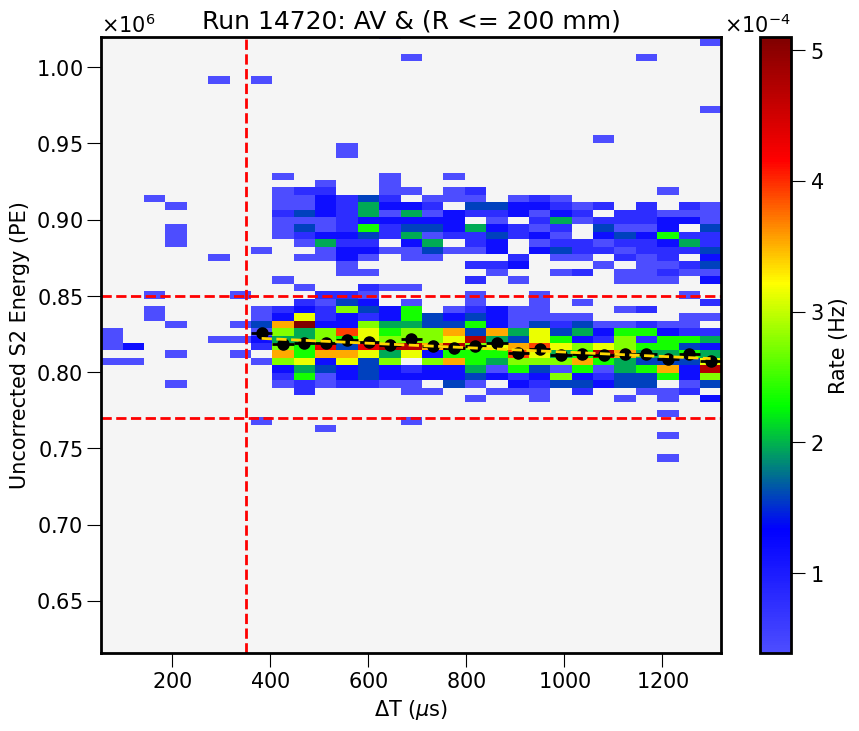

Run 14733 fit: N0 = (824807.11 ± 870.47) PE, τ = (61.65 ± 4.79) ms
χ² / ndof = 1.4516


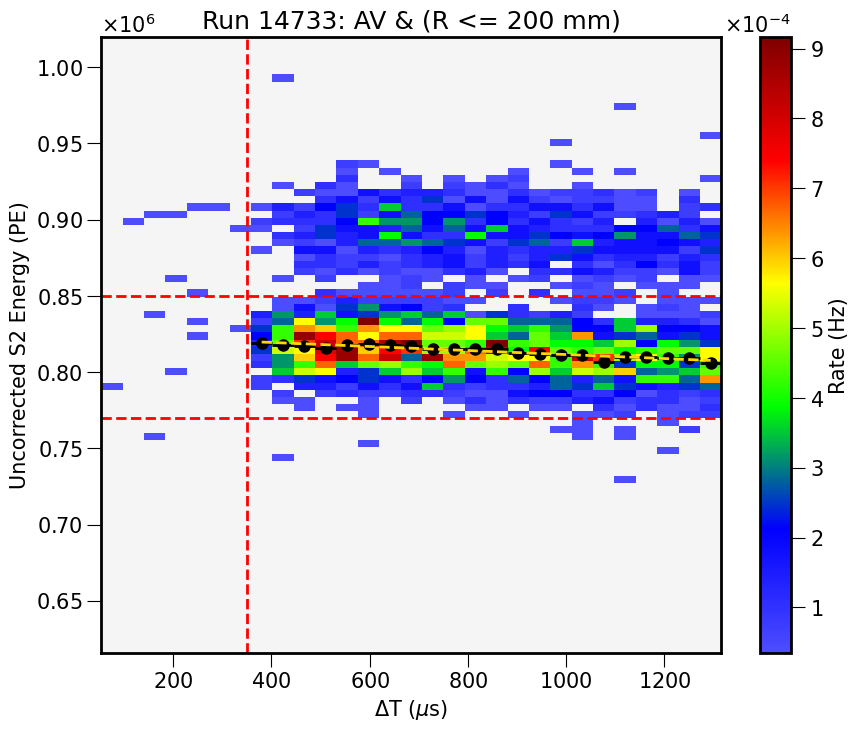

Run 14735 fit: N0 = (826691.72 ± 673.87) PE, τ = (50.35 ± 2.45) ms
χ² / ndof = 2.8925


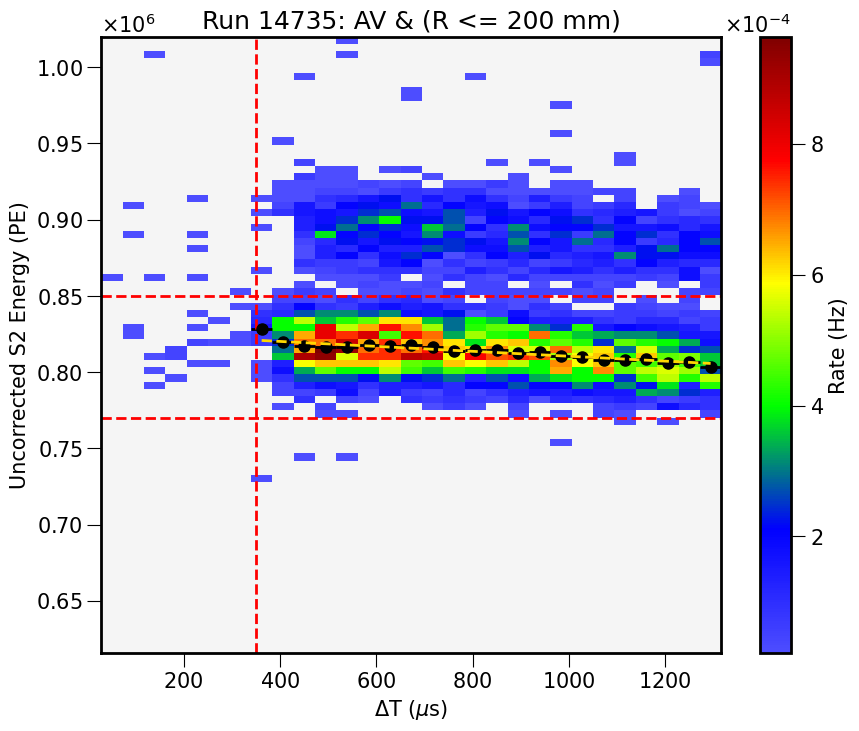

Run 14737 fit: N0 = (830396.13 ± 649.93) PE, τ = (59.27 ± 3.15) ms
χ² / ndof = 1.5283


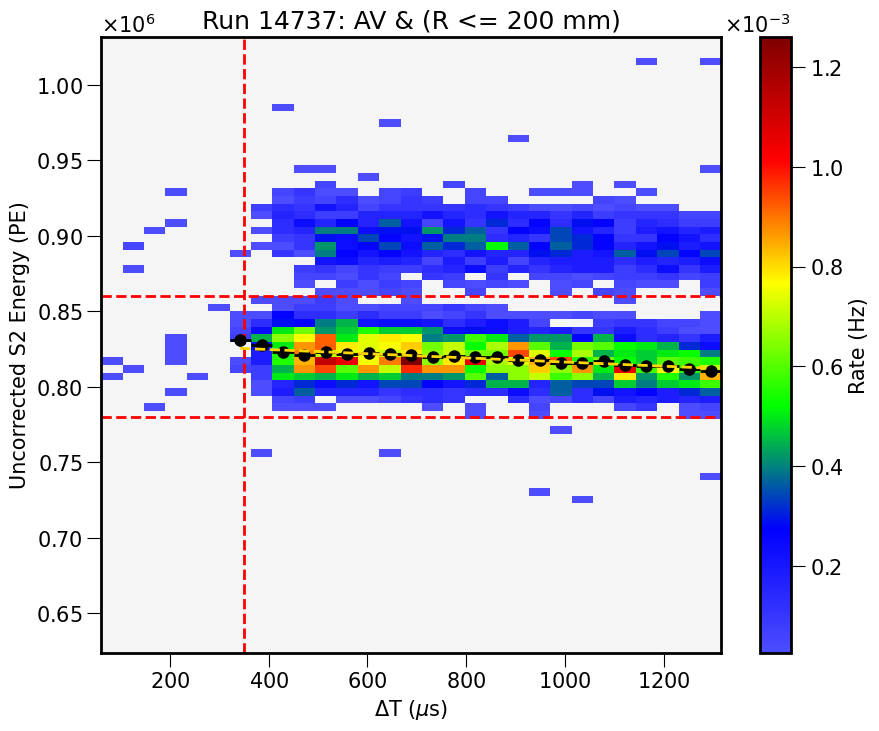

Run 14739 fit: N0 = (832022.97 ± 617.32) PE, τ = (55.38 ± 2.59) ms
χ² / ndof = 2.6395


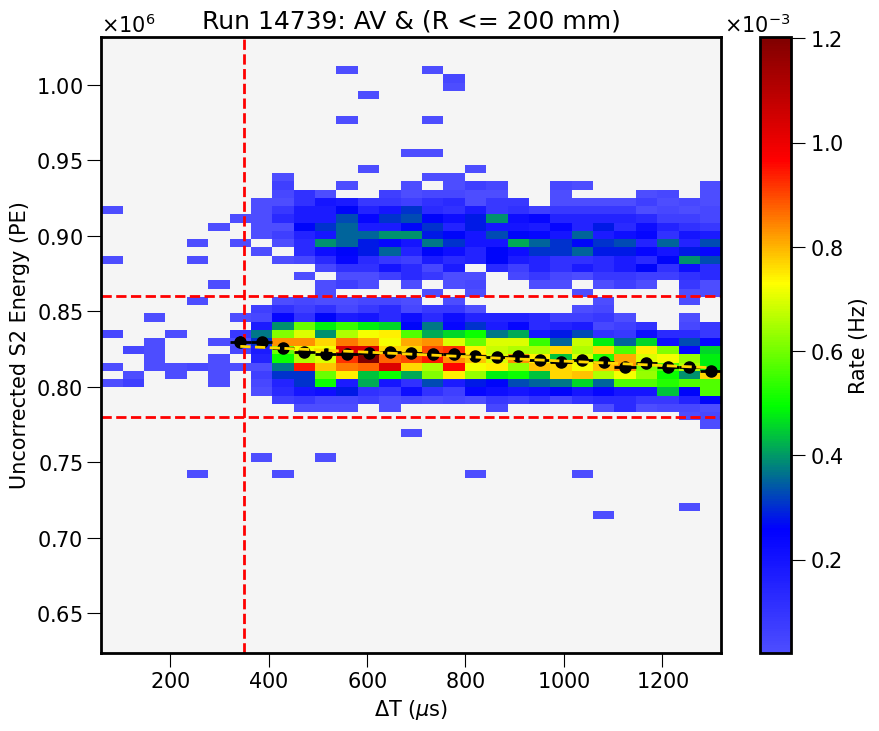

Run 14741 fit: N0 = (831317.61 ± 605.76) PE, τ = (58.86 ± 2.91) ms
χ² / ndof = 2.4398


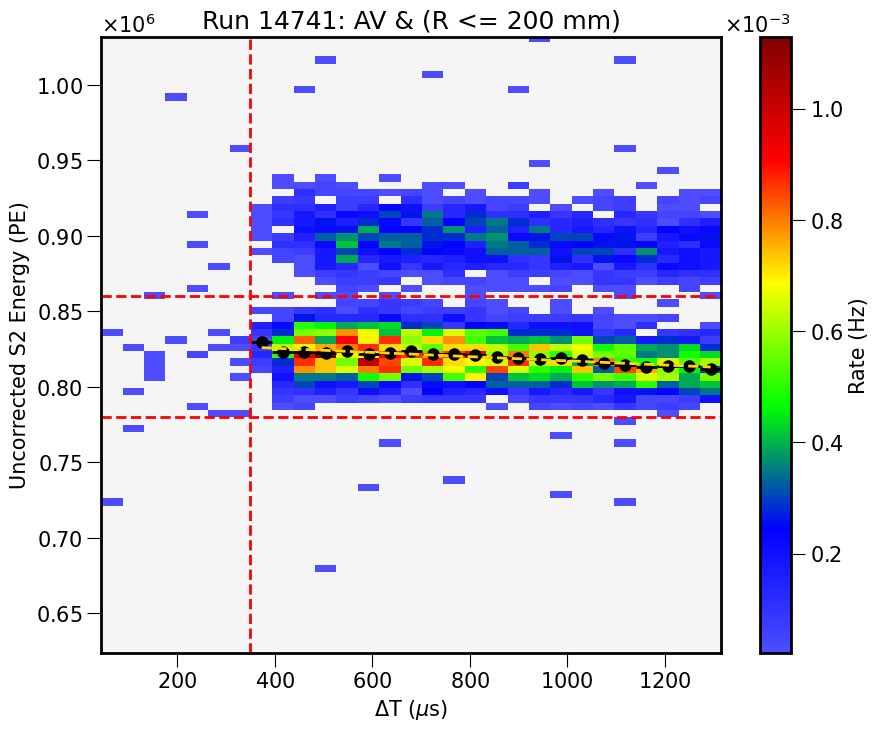

Run 14743 fit: N0 = (830914.71 ± 626.18) PE, τ = (63.67 ± 3.47) ms
χ² / ndof = 2.5136


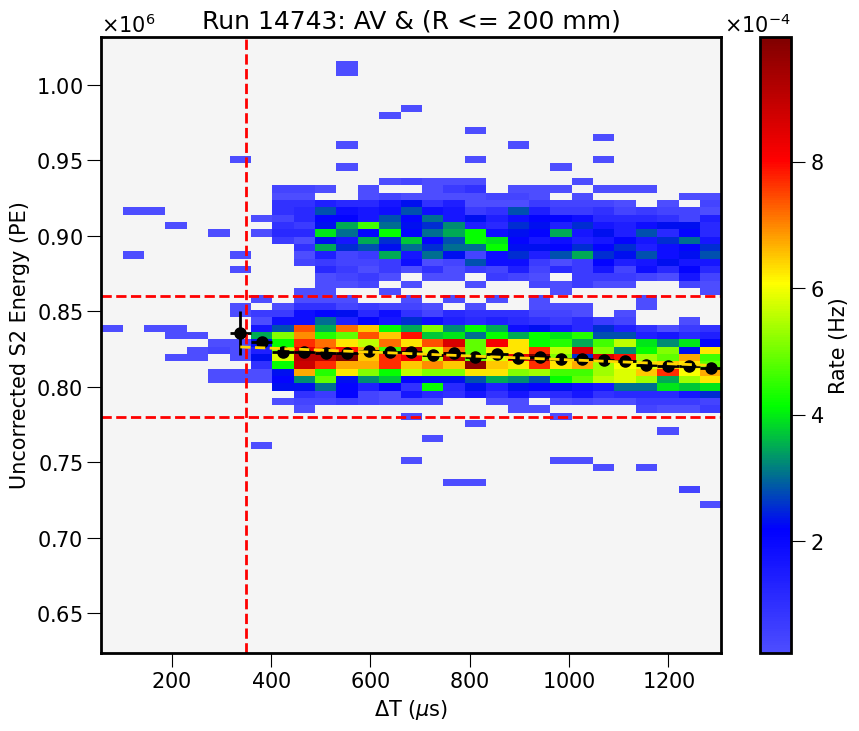

Run 14745 fit: N0 = (832544.57 ± 721.29) PE, τ = (56.72 ± 3.15) ms
χ² / ndof = 1.1162


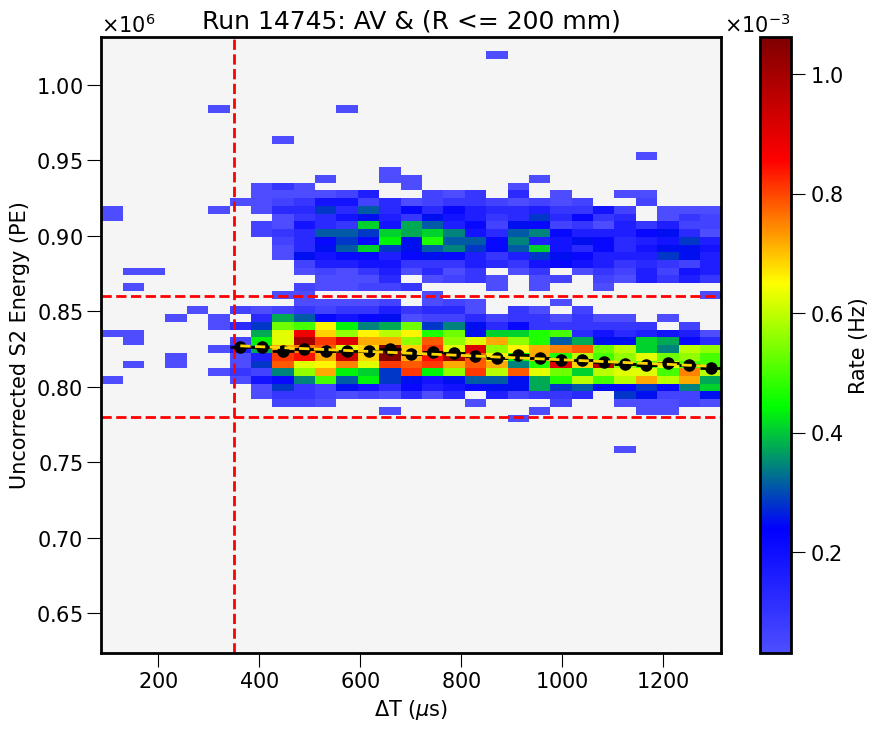

Run 14753 fit: N0 = (832659.21 ± 772.01) PE, τ = (50.11 ± 2.75) ms
χ² / ndof = 1.7322


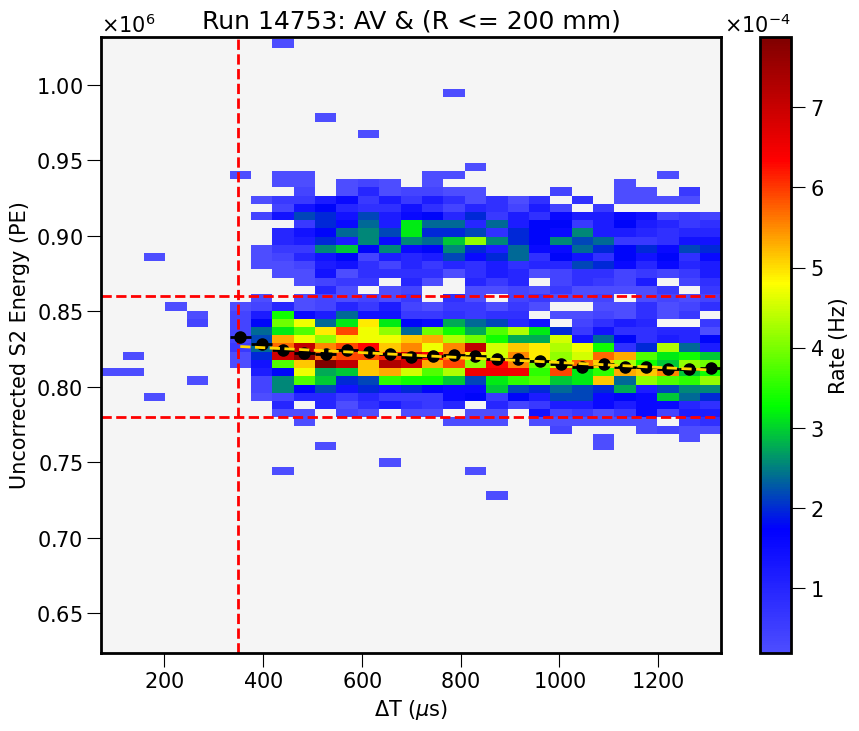

Run 14765 fit: N0 = (835946.90 ± 1282.95) PE, τ = (45.26 ± 3.61) ms
χ² / ndof = 0.7367


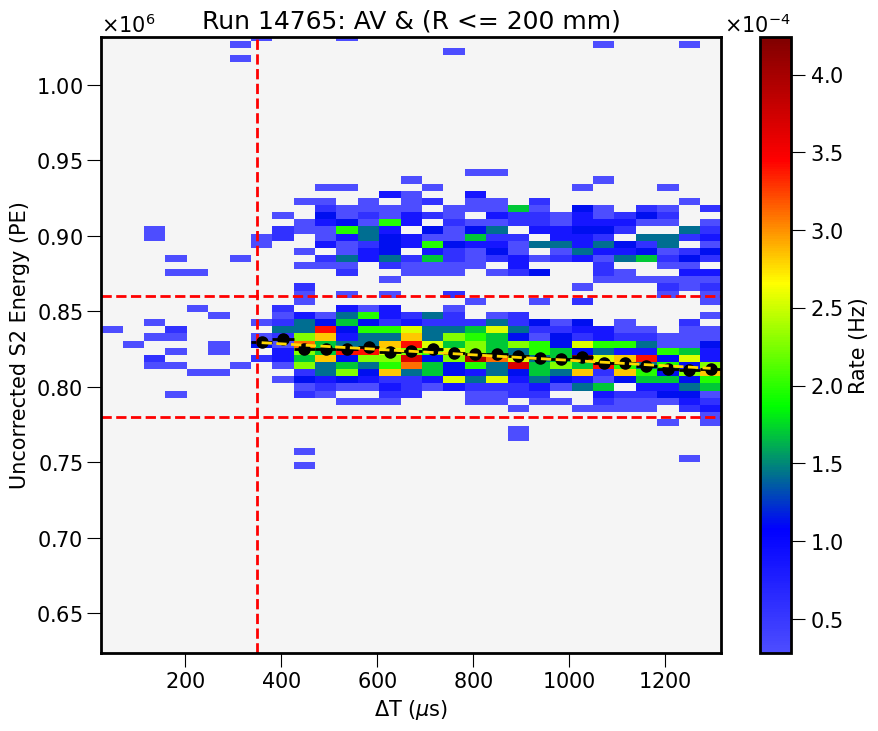

Run 14780 fit: N0 = (839160.06 ± 1014.80) PE, τ = (43.46 ± 2.61) ms
χ² / ndof = 2.1775


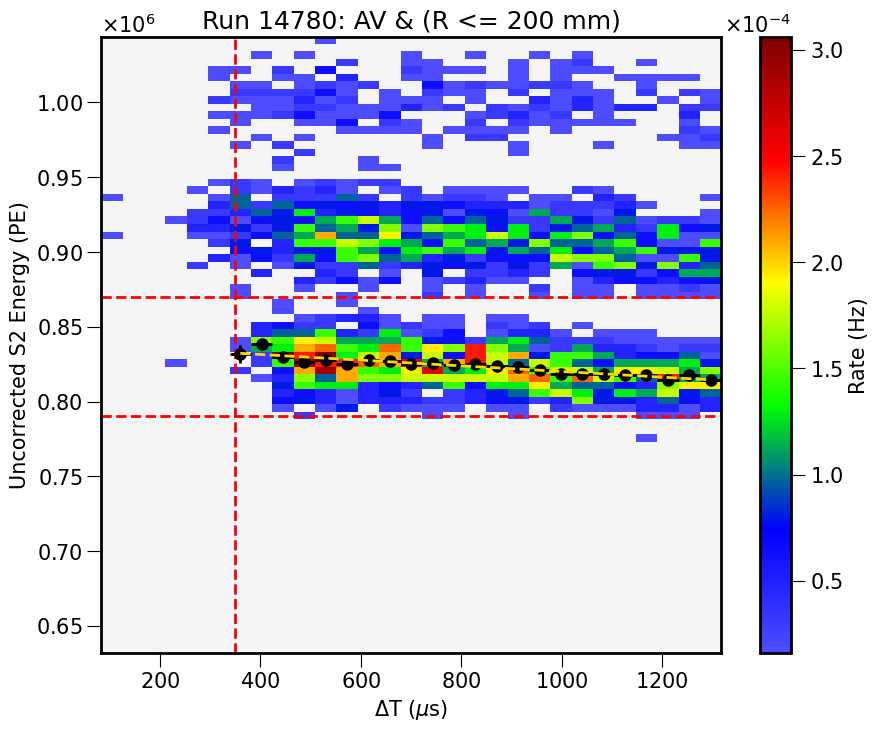

Run 14782 fit: N0 = (839346.15 ± 827.97) PE, τ = (50.50 ± 2.91) ms
χ² / ndof = 1.2794


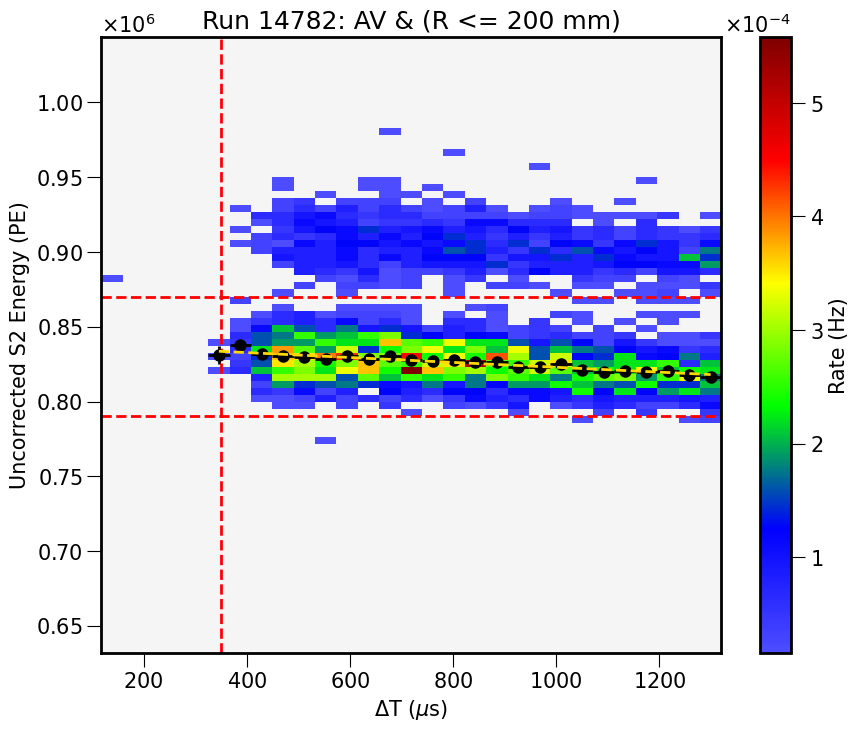

Run 14784 fit: N0 = (840960.91 ± 1020.32) PE, τ = (43.18 ± 2.57) ms
χ² / ndof = 1.3223


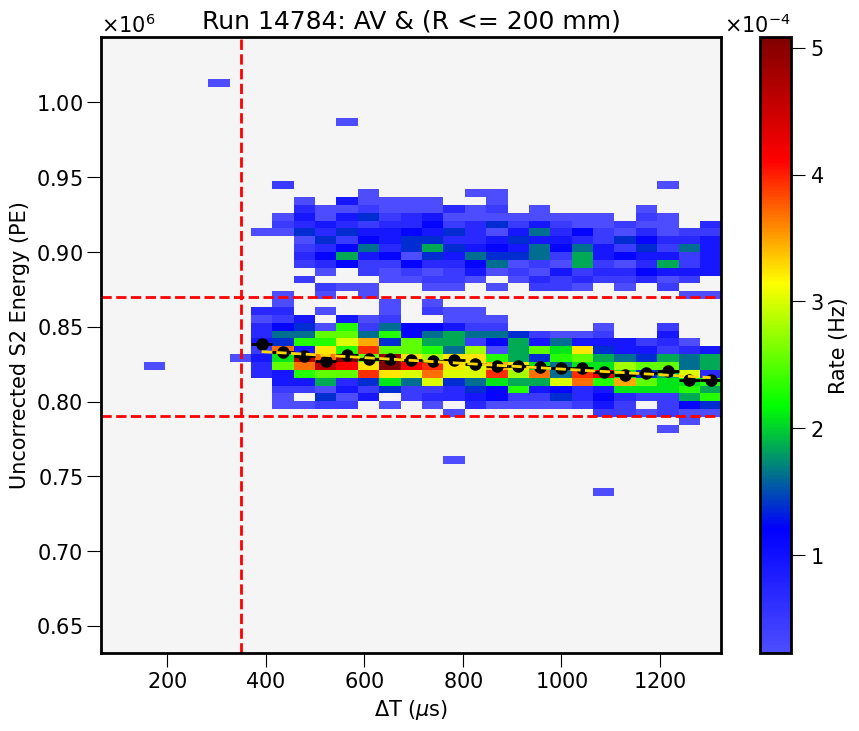

Run 14789 fit: N0 = (838692.09 ± 1046.73) PE, τ = (46.93 ± 3.14) ms
χ² / ndof = 0.5028


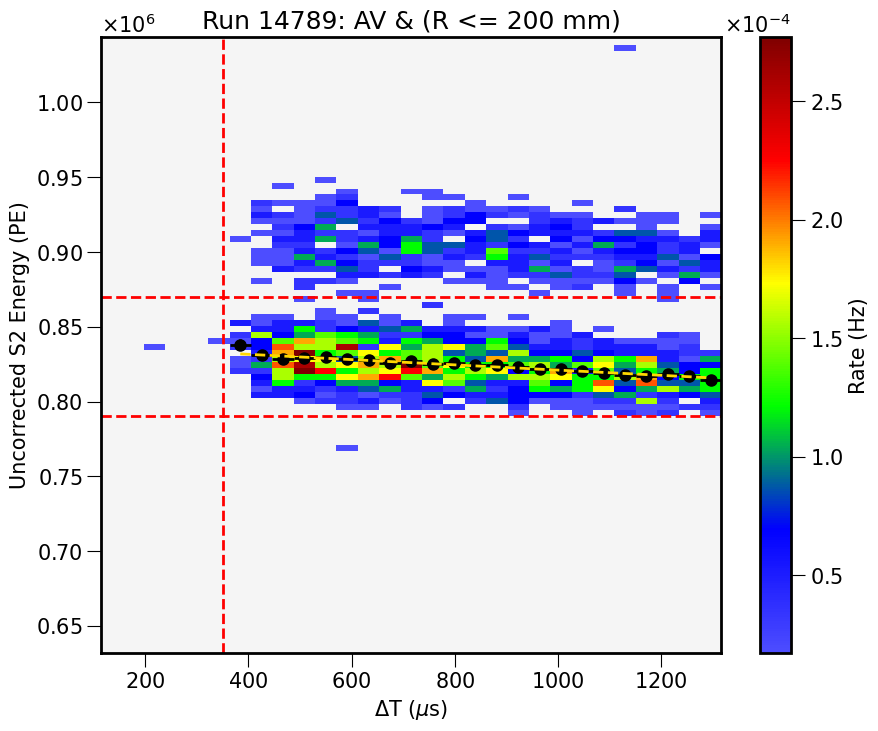

Run 14803 fit: N0 = (731068.30 ± 476.62) PE, τ = (77.71 ± 4.98) ms
χ² / ndof = 7.0270


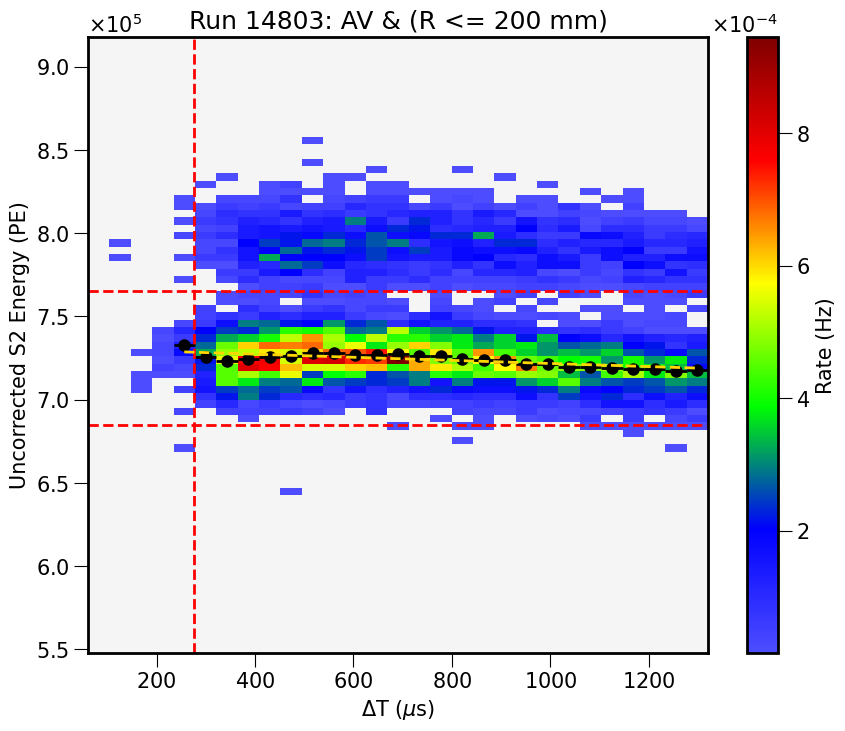

Run 14804 fit: N0 = (731296.65 ± 542.39) PE, τ = (84.80 ± 6.59) ms
χ² / ndof = 9.8452


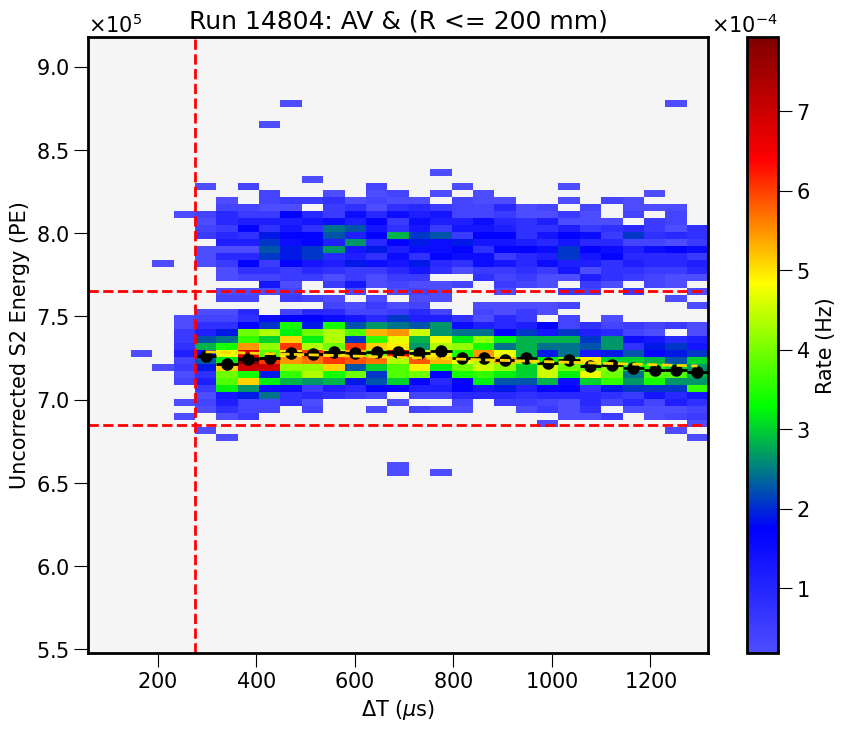

Run 14811 fit: N0 = (731010.67 ± 490.86) PE, τ = (101.90 ± 8.53) ms
χ² / ndof = 6.7503


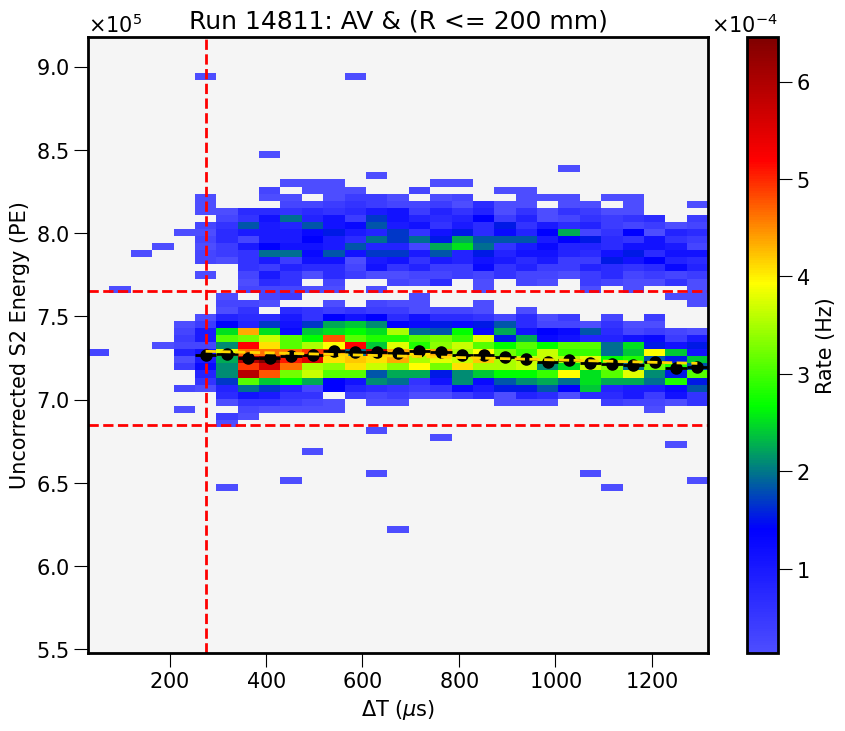

Run 14814 fit: N0 = (729476.29 ± 1934.35) PE, τ = (101.86 ± 32.07) ms
χ² / ndof = 1.6447


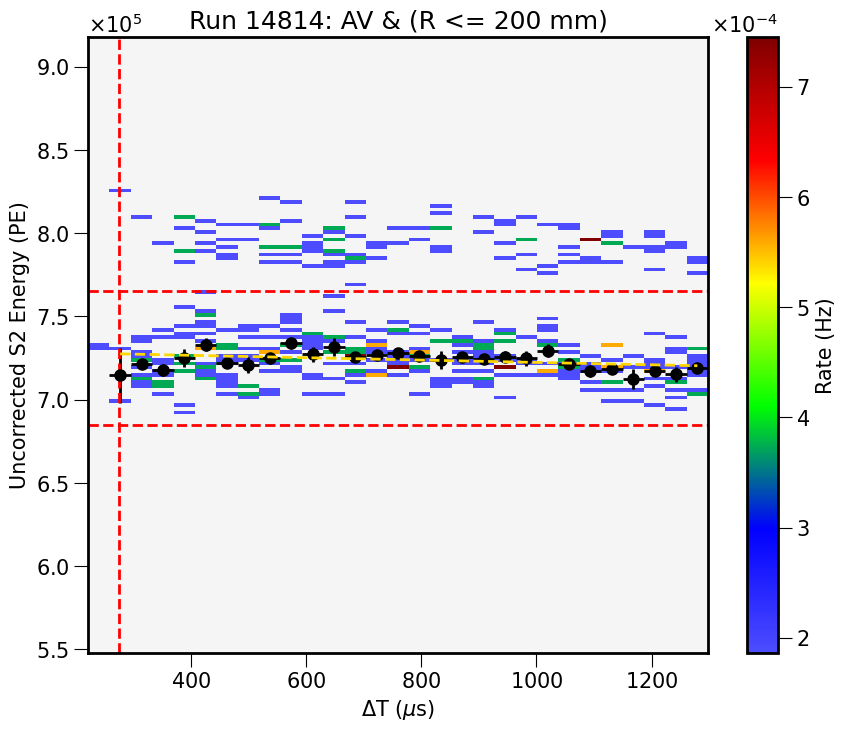

Run 14815 fit: N0 = (731406.79 ± 538.42) PE, τ = (98.24 ± 8.65) ms
χ² / ndof = 9.0677


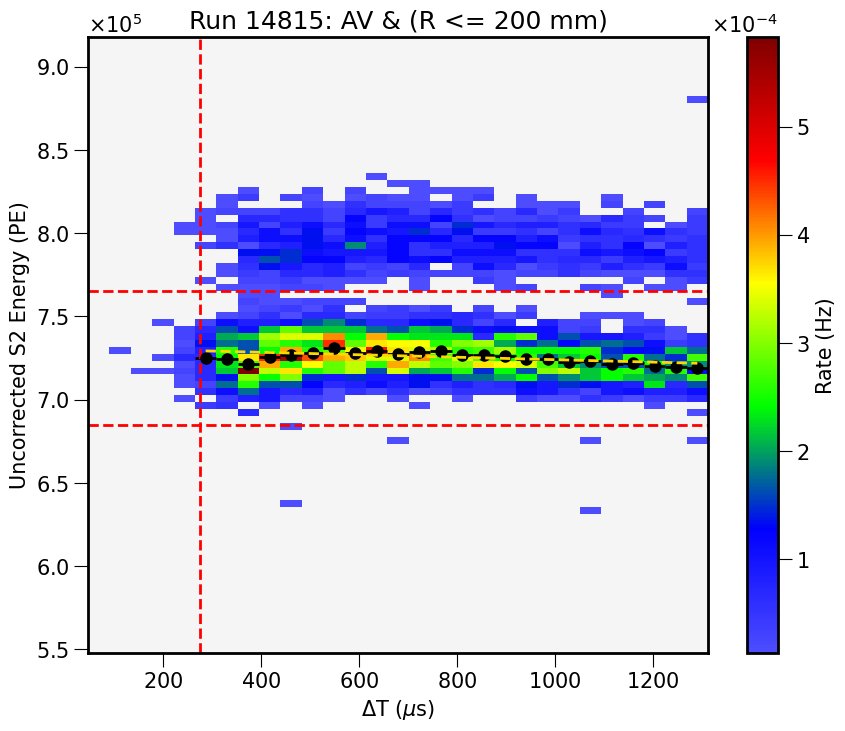

Run 14816 fit: N0 = (731058.89 ± 585.76) PE, τ = (114.55 ± 12.70) ms
χ² / ndof = 4.3694


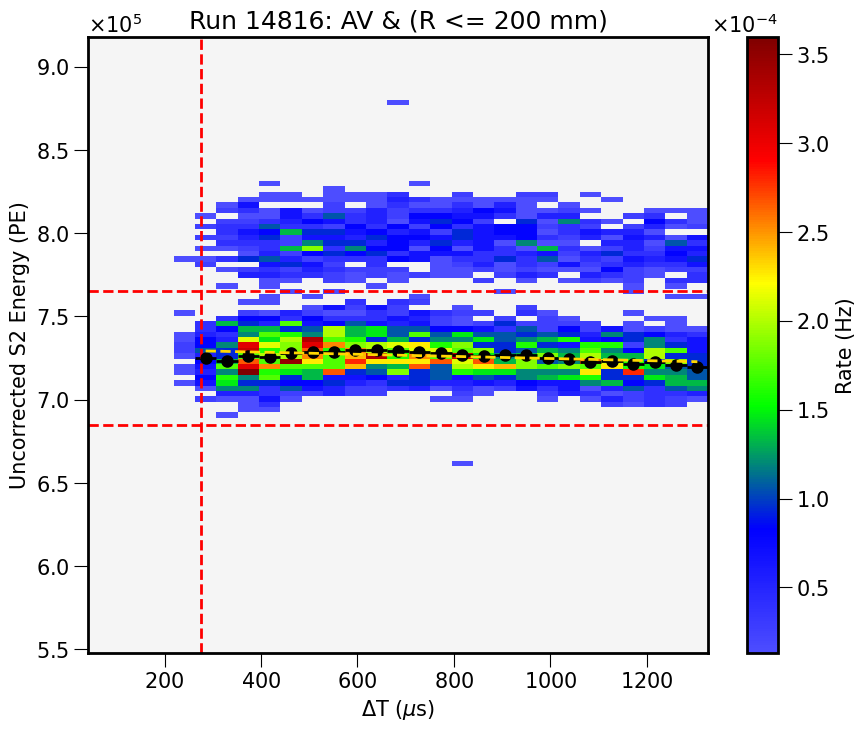

Run 14817 fit: N0 = (732025.68 ± 816.22) PE, τ = (102.60 ± 14.27) ms
χ² / ndof = 3.9897


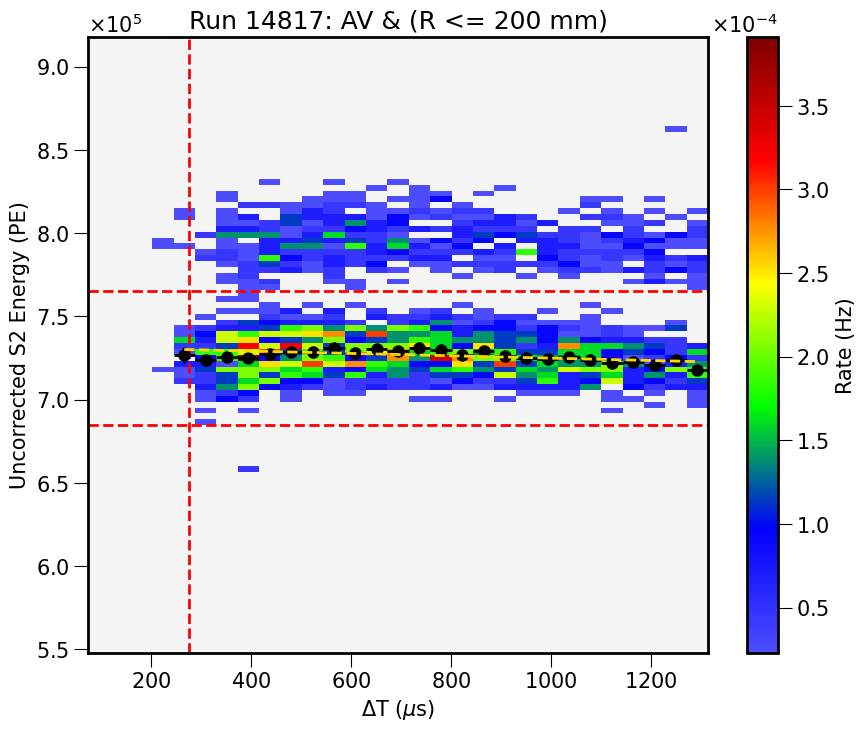

Run 14828 fit: N0 = (731280.55 ± 2204.67) PE, τ = (76.48 ± 20.50) ms
χ² / ndof = 1.5172


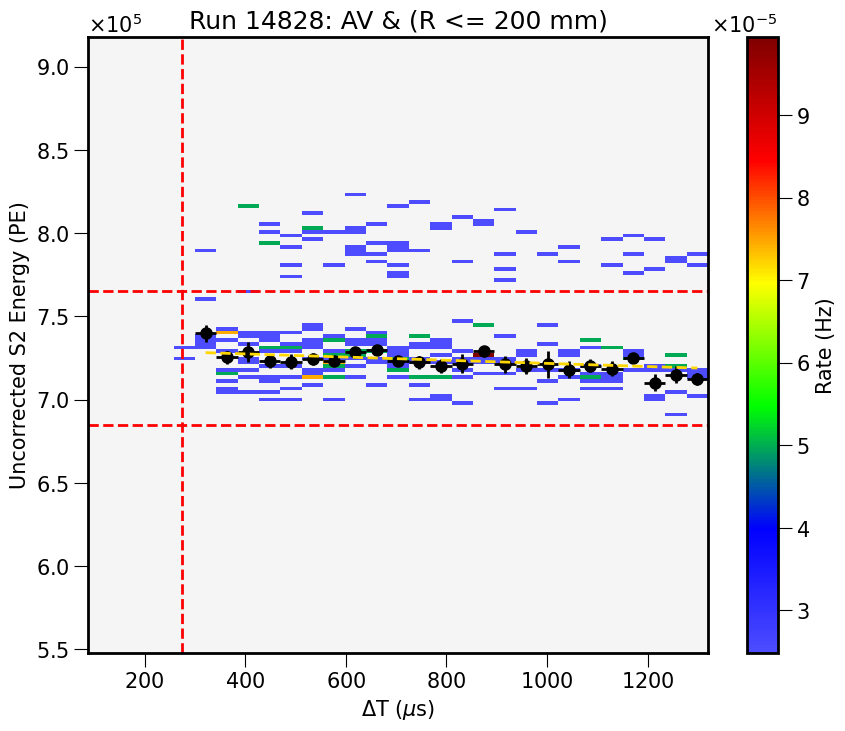

Run 14829 fit: N0 = (943712.01 ± 2482.36) PE, τ = (37.25 ± 4.37) ms
χ² / ndof = 7.2553


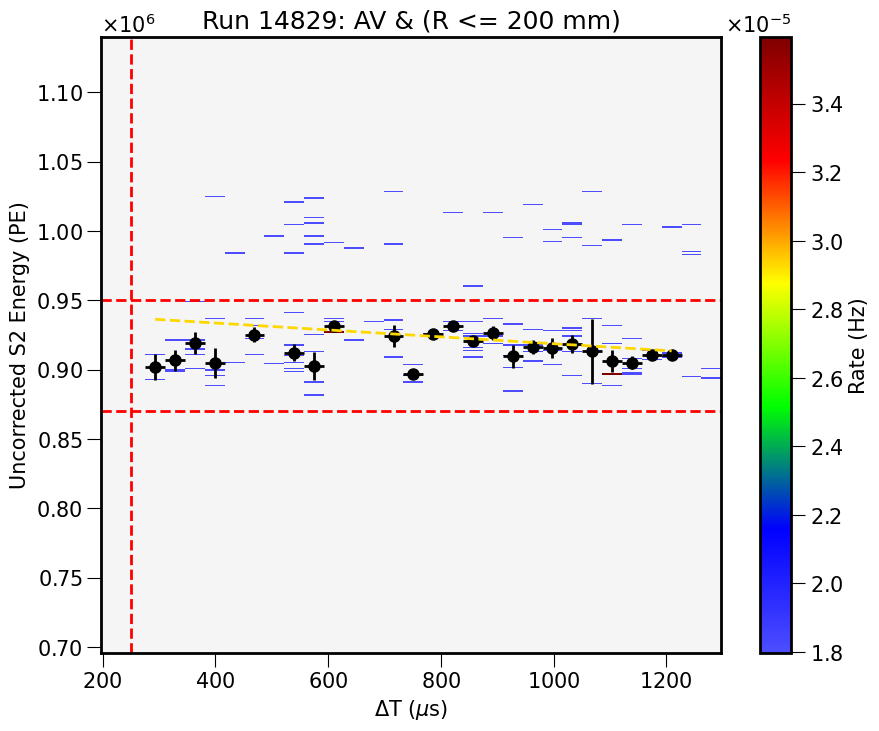

Run 14834 fit: N0 = (925300.36 ± 1204.51) PE, τ = (524.73 ± 316.74) ms
χ² / ndof = 2.9129


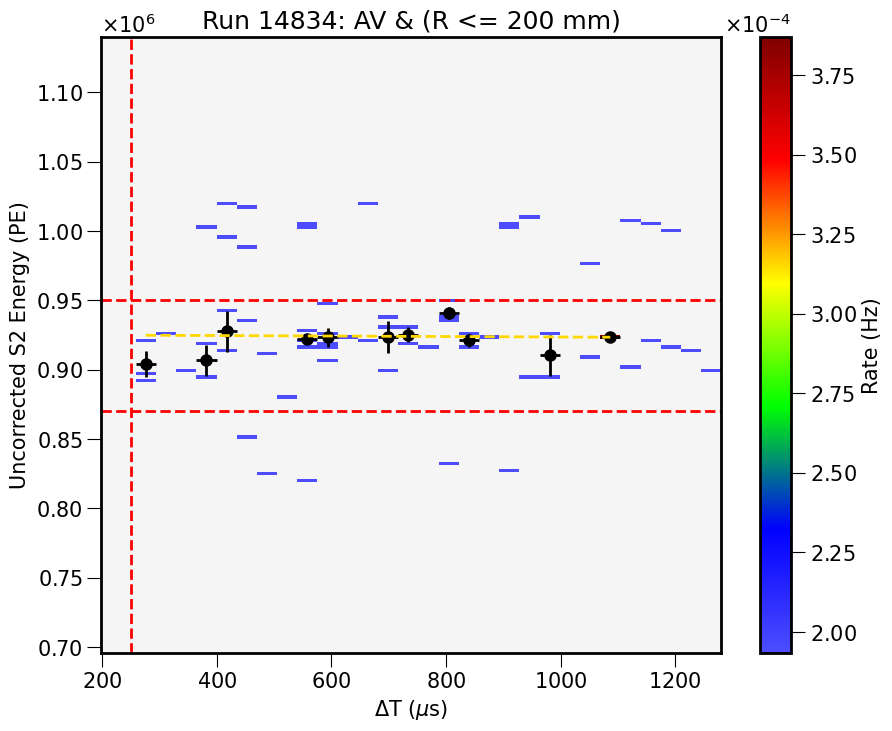

Run 14835 fit: N0 = (933004.75 ± 2976.39) PE, τ = (40.26 ± 5.13) ms
χ² / ndof = 2.5494


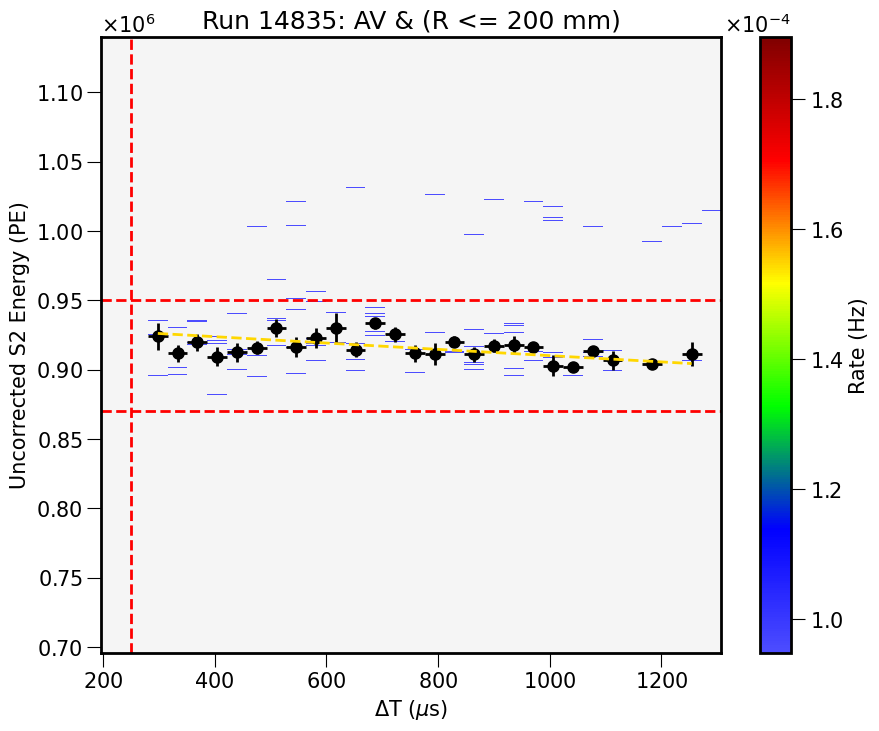

Run 14837 fit: N0 = (920653.91 ± 1835.39) PE, τ = (71.28 ± 12.52) ms
χ² / ndof = 1.4921


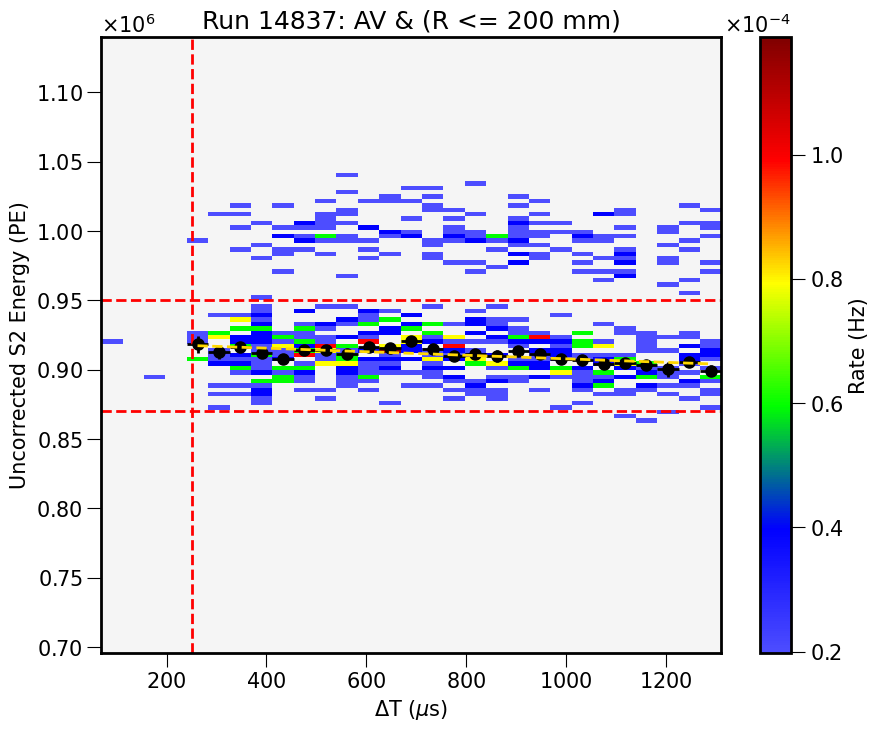

Run 14838 fit: N0 = (920466.80 ± 1510.24) PE, τ = (96.41 ± 18.04) ms
χ² / ndof = 2.2558


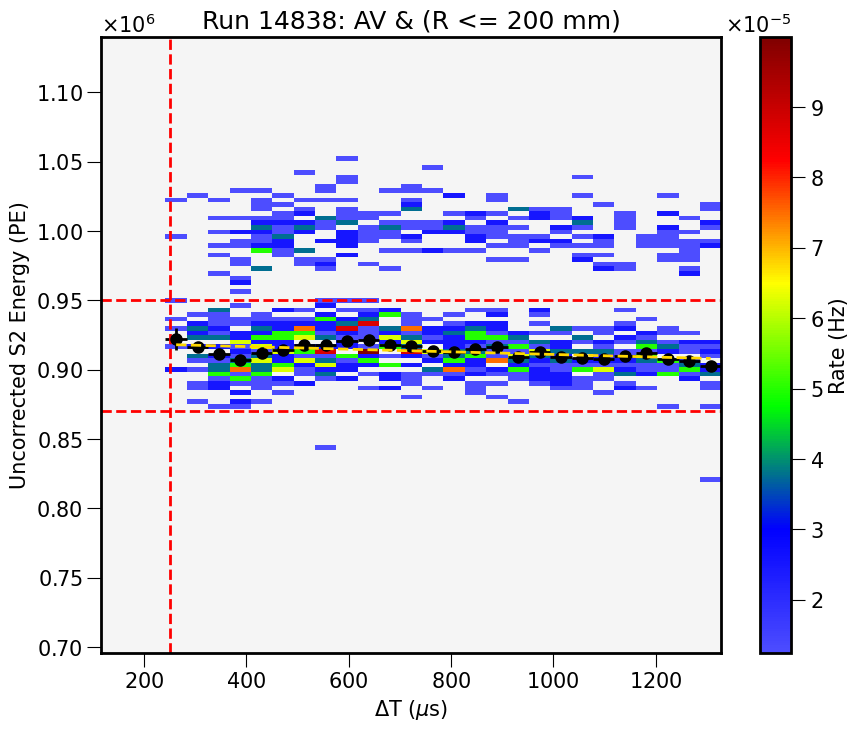

Run 14839 fit: N0 = (925702.39 ± 1524.27) PE, τ = (65.70 ± 8.46) ms
χ² / ndof = 2.6378


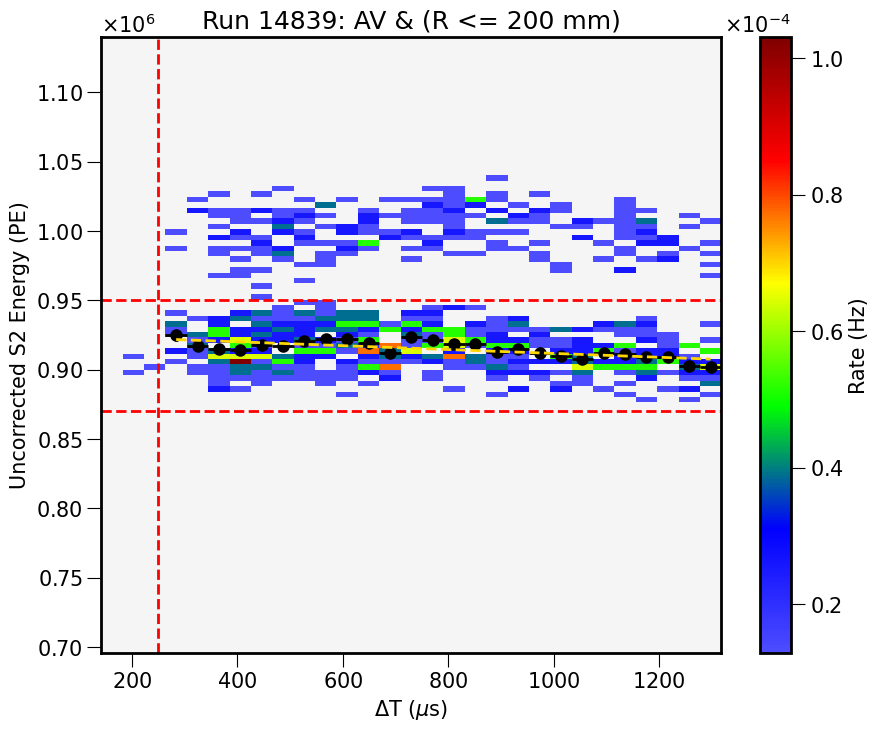

Run 14840 fit: N0 = (920922.64 ± 1759.78) PE, τ = (107.30 ± 28.64) ms
χ² / ndof = 1.6865


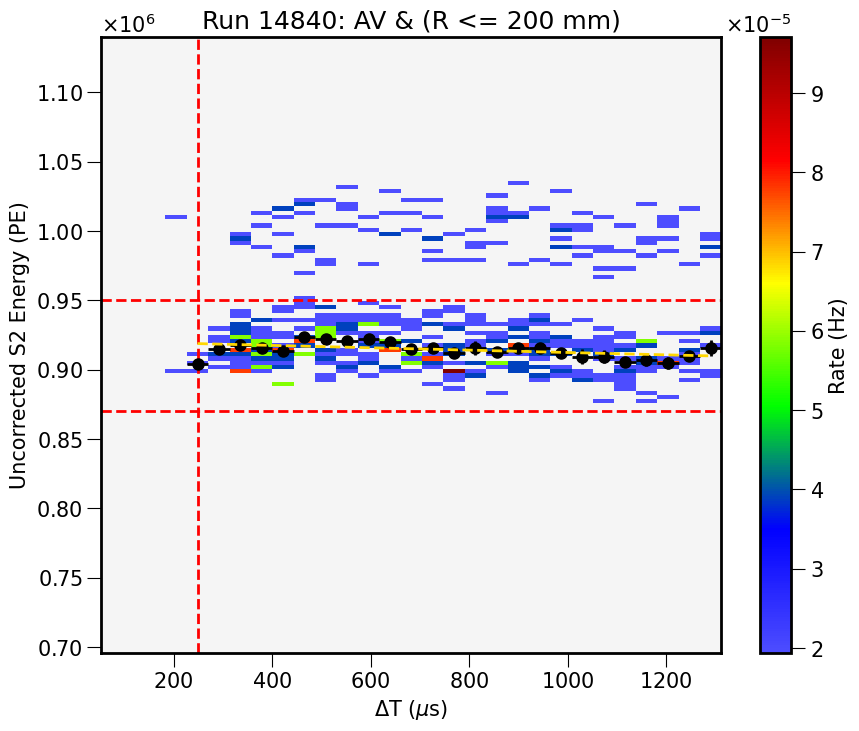

In [30]:
# Global
rad_lim = 200
x_bins  = 30
y_bins  = 400

# Use exponential decay function with b = 0
def exp_bfixed(x, N0, tau):
    return ff.exponential_decay(x, N0, tau, 0)

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_long = entry["duration"]
    run_OK   = entry["OK"]
    run_LOST = entry["LOST"]
    
    # DAQe efficiency + error
    DAQe_CV, DAQe_error = ff.efficiency(run_OK, run_LOST)
        
    # Variables    
    E2 = sel_data[run_id]['S2e']
    DT = sel_data[run_id]['DT']
    R  = sel_data[run_id]['R']

    # Masking
    rad_mask = (R <= rad_lim)
    E2_mask  = E2[AV_mask[run_id] & rad_mask]
    DT_mask  = DT[AV_mask[run_id] & rad_mask]

    # 2D histogram: normalized by corrected DAQ data taking time
    S2e_DT_map, ex, ey = pt.hist_2D(DT_mask, E2_mask, x_bins=x_bins, y_bins=y_bins)
    S2e_DT_map         = S2e_DT_map / (run_long * DAQe_CV)                           
    S2e_DT_map         = np.ma.masked_where(S2e_DT_map==0, S2e_DT_map)                # Zero values masked
    
    # ---- Exponential Fit ----- #
    # Preliminary
    DT_down = 350;    DT_up = DT_mask.max()
    E2_down = 770e3;  E2_up = 850e3
    if run_id in {14737, 14739, 14741, 14743, 14745, 14753, 14765}:
        E2_down = 780e3;  E2_up = 860e3
    if run_id in {14780, 14782, 14784, 14789}:
        E2_down = 790e3;  E2_up = 870e3
    if run_id in {14803, 14804, 14811, 14814, 14815, 14816, 14817, 14828}:
        DT_down = 275;    DT_up = DT_mask.max()
        E2_down = 685e3;  E2_up = 765e3
    elif run_id in {14829, 14834, 14835, 14837, 14838, 14839, 14840}:
        DT_down = 250;    DT_up = DT_mask.max()
        E2_down = 870e3;  E2_up = 950e3

    # Filter the data for the fit
    fit_region_mask = (DT_mask >= DT_down) & (DT_mask <= DT_up) & \
                      (E2_mask >= E2_down) & (E2_mask <= E2_up)
    DT_fit = DT_mask[fit_region_mask]
    E2_fit = E2_mask[fit_region_mask]

    # Compute representative values for the fit
    DT_centers, DT_errors, S2e_means, S2e_errors = ff.prefit_2D(DT_fit, E2_fit, bins=ex)
    # Filter out points with zero error (bins with 1 event)
    valid_points = S2e_errors > 0
    DT_centers = DT_centers[valid_points];      DT_errors  = DT_errors[valid_points]
    S2e_means  = S2e_means[valid_points];       S2e_errors = S2e_errors[valid_points]

    # Definte the cost function + initial guess
    least_squares = LeastSquares(DT_centers, S2e_means, S2e_errors, exp_bfixed)
    init_guess = [S2e_means.max(), (DT_centers.max() - DT_centers.min()) / 2]
    # print(f'\nInitial guess: N0 = {init_guess[0]:.4f} PE, tau = {init_guess[1]:.4f} μs')

    # Define the Minuit object
    m = Minuit(least_squares, *init_guess)

    # Minimization process of the cost function and error estimation
    m.migrad()
    m.hesse()

    # Results
    popt = m.values;  perr = m.errors
    print(f'Run {run_id} fit: N0 = ({popt[0]:.2f} ± {perr[0]:.2f}) PE, τ = ({popt[1] / 1e3:.2f} ± {perr[1] / 1e3:.2f}) ms')
    FIT_PARAMETERS[run_id]["S2e"] = {"N0_CV": popt[0], "N0_err": perr[0], "tau_CV": popt[1], "tau_err": perr[1]}
    
    # Reduced chi-square
    chi2 = m.fval
    ndof = len(DT_centers) - m.nfit
    print(f"χ² / ndof = {chi2 / ndof:.4f}")

    # ----- Plotting ----- #
    # plt.figure(figsize=(8, 6))

    # Data
    plt.pcolormesh(ex, ey, S2e_DT_map.T, cmap=pt.custom_hsv, shading='auto')
    cbar = plt.colorbar(label='Rate (Hz)', shrink=1.0)
    # cbar.formatter.set_powerlimits((-3, -3))

    # Fit
    fit_y = exp_bfixed(DT_centers, *popt)
    plt.errorbar(DT_centers, S2e_means, xerr=DT_errors, yerr=S2e_errors, fmt='o', c='black', ecolor='black')
    plt.plot(DT_centers, fit_y, c='gold', ls='--', zorder=3)
    plt.axvline(x=DT_down, c='red', ls='--')
    plt.axhline(y=E2_down, c='red', ls='--')
    plt.axhline(y=E2_up, c='red', ls='--')

    # ----- Styling ----- #
    plt.xlabel('$\Delta$T ($\mu$s)')
    # plt.xlim(0, DT_mask.max())
    plt.ylabel('Uncorrected S2 Energy (PE)') 
    plt.ylim(0.8*E2_down, 1.2*E2_up)
    # plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
    plt.title(f'Run {run_id}: AV & (R <= {rad_lim} mm)')

    plt.gca().set_facecolor("whitesmoke")
    # plt.savefig(f'/lhome/ific/c/ccortesp/Analysis/NEXT-100/Rn_analysis/images/S2e_DT_fit_run{run_id}.pdf')
    plt.show() 

### Lifetime Evolution

In [50]:
# Global
Date      = []
Date_err  = []
Lifet     = []
Lifet_err = []
Run_number = []

def const_func(x, b):
    return ff.linear_func(x, 0, b)

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    
    # Skip runs with low stats < 10k events
    if run_id in {14716, 14814, 14828, 14829, 14834, 14835, 14837, 14838, 14839, 14840}:  
        print(f"Skipping run {run_id}: What a bad fit! (low stat)")  
        continue

    # Skip weirdos
    if run_id in {14803, 14804, 14811, 14815, 14816, 14817}:  
        print(f"Skipping run {run_id}: What is that bend?")  
        continue

    Run_number.append(run_id)
    
    # Variables    
    Time = sel_data[run_id]['time']
    
    # Mean date + error for each run
    date_CV    = Time.mean()
    Date.append(date_CV)
    date_error = Time.std() / np.sqrt(len(Time))
    Date_err.append(date_error)

    # Retrieve lifetime fit value   
    LT_CV    = FIT_PARAMETERS[run_id]['S2e']['tau_CV']  / 1e3     # In [ms]
    Lifet.append(LT_CV)
    LT_error = FIT_PARAMETERS[run_id]['S2e']['tau_err'] / 1e3
    Lifet_err.append(LT_error)

Skipping run 14716: What a bad fit! (low stat)
Skipping run 14803: What is that bend?
Skipping run 14804: What is that bend?
Skipping run 14811: What is that bend?
Skipping run 14814: What a bad fit! (low stat)
Skipping run 14815: What is that bend?
Skipping run 14816: What is that bend?
Skipping run 14817: What is that bend?
Skipping run 14828: What a bad fit! (low stat)
Skipping run 14829: What a bad fit! (low stat)
Skipping run 14834: What a bad fit! (low stat)
Skipping run 14835: What a bad fit! (low stat)
Skipping run 14837: What a bad fit! (low stat)
Skipping run 14838: What a bad fit! (low stat)
Skipping run 14839: What a bad fit! (low stat)
Skipping run 14840: What a bad fit! (low stat)


In [51]:
# ----- Linear Fits ----- #
# Preliminary
Date      = np.array(Date)
Date_err  = np.array(Date_err)
Lifet     = np.array(Lifet)
Lifet_err = np.array(Lifet_err)

# Masking: select sepecific data
# HG_time = (Date >= 1737975600)
Fine_time = (Date < 1738716600)

x_data = Date[Fine_time]
y_data = Lifet[Fine_time]
y_err  = Lifet_err[Fine_time]

# Shifted time
x_shift = (x_data - x_data[0]) / 3600  # In [hr] for numeric stability

# We perform two different fits: constant and linear
models = [const_func, ff.linear_func]

x_fit = [[], []]
y_fit = [[], []]
chi2  = [[], []]
ndof  = [[], []]

for i, func in enumerate(models):

    # Define the cost function + initial guess
    least_squares = LeastSquares(x_shift, y_data, y_err, func)
    init_guess    = []

    if func == const_func:
        init_guess = [y_data.mean()]
    elif func == ff.linear_func:
        init_guess = [10.0, y_data.min()]

    print(f'\nFit {i+1}:\nInitial guess: {init_guess}')

    # Define the Minuit object
    m = Minuit(least_squares, *init_guess)

    # Minimization process of the cost function and error estimation
    m.migrad()
    m.hesse()

    # Results
    popt = m.values;  perr = m.errors
    print(f"Results:")
    for param, value, error in zip(m.parameters, popt, perr):
        print(f"  {param}: {value:.4f} ± {error:.4f}")

    if func == const_func:
        LIFETIME = popt[0] * 1e3  # In [μs] for later calculations

    # Reduced chi-square
    chi2[i] = m.fval
    ndof[i] = len(x_shift) - m.nfit
    print(f"χ² / ndof = {chi2[i] / ndof[i]:.4f}")

    # Fits
    x_fit[i] = (x_shift * 3600) + x_data[0]  # In [s]
    y_fit[i] = func(x_shift, *popt)


Fit 1:
Initial guess: [52.65991899264928]
Results:
  b: 51.4257 ± 0.7658
χ² / ndof = 4.4861

Fit 2:
Initial guess: [10.0, 43.18337897796336]
Results:
  m: -0.0221 ± 0.0060
  b: 56.0095 ± 1.4601
χ² / ndof = 3.7854


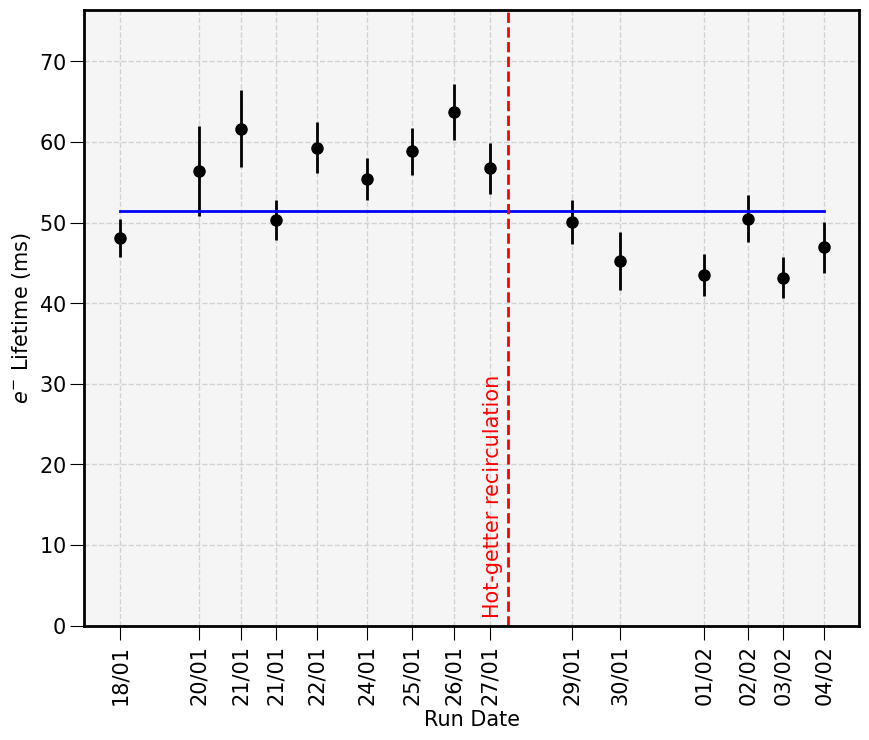

In [52]:
# ----- Plotting ----- #
# Data
plt.errorbar(Date, Lifet, xerr=Date_err, yerr=Lifet_err, fmt='o', c='black', ecolor='black')
# for x, y, run_id in zip(Date, Lifet, Run_number):
#     plt.text(x, y, str(run_id), fontsize=10, ha='left', va='bottom', color='blue')  # Run number near the point

# Fits
plt.plot(x_fit[0], y_fit[0], color='blue', ls='-', label=f'Constant Fit\nχ² / ndof = {chi2[0] / ndof[0]:.2f}')
# plt.plot(x_fit[1], y_fit[1], color='orange', ls='--', label=f'Linear Fit\nχ² / ndof = {chi2[1] / ndof[1]:.2f}')

# Important dates
plt.axvline(x=1737975600, c='red', ls='--')
plt.text(1737975600-1e4, 1.0, 'Hot-getter recirculation', c='red', va='bottom',  ha='right',  rotation=90)

# ----- Styling ----- #
plt.xlabel('Run Date')
x_labels = [crudo.epoch_converter(t, h=False) for t in Date]  # Convert x-axis bin edges to readable time format
plt.xticks(Date, x_labels, rotation=90, ha='center')
plt.ylim(0, 1.2 * Lifet.max())
plt.ylabel(r'$e^{-}$ Lifetime (ms)')
# plt.title(r'$e^{-}$ Lifetime Evolution')
# plt.legend(loc='upper right', fontsize=8)

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.savefig(f'/lhome/ific/c/ccortesp/Analysis/NEXT-100/Rn_analysis/images/Lifetime_Evolution.pdf')
plt.show()

What's the maximum factor of correction? (@ cathode)

In [44]:
# Any maximum DT value
max_DT = DT_stop[14739]
print(f"Correction by lifetime @ cathode (max. factor): {ff.exponential_decay(max_DT, 1, LIFETIME, 0):.2%}")

Correction by lifetime @ cathode (max. factor): 97.47%


# Energy Corrections

We perform energy corrections exclusively for the runs categorized as:

- **High $^{222}\text{Rn }\rightarrow$** 14739
- **Low $^{222}\text{Rn }\,\,\rightarrow$** 14834, 14835, 14837, 14838, 14839, 14840

In [53]:
# Global
n_bins  = 50

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id = entry["run_number"]
    
    # Analysis runs
    if run_id in HIGH_RN_RUNS + LOW_RN_RUNS:
        
        if run_id in HIGH_RN_RUNS:

            # Fit parameters for energy corrections
            CV_fit = [FIT_PARAMETERS[run_id]['S1e']['m_CV'],  FIT_PARAMETERS[run_id]['S1e']['b_CV']]
            LT_fit = [FIT_PARAMETERS[run_id]['S2e']['N0_CV'], LIFETIME]

            # Apply corrections
            sel_data[run_id] = crudo.correct_S1e   (sel_data[run_id], CV_fit, DT_stop[run_id], output_column='S1e_corr')  # S1 energy
            sel_data[run_id] = crudo.correct_S2e_LT(sel_data[run_id], LT_fit, output_column='S2e_corr_LT')                # S2 energy by lifetime

            # Generate the reference (High-Rn) energy map
            print(f"Generating energy map of reference...\nThank you run {run_id} for your stats")

            # Variables
            X_ref  = sel_data[run_id]['X']
            Y_ref  = sel_data[run_id]['Y']
            E2_ref = sel_data[run_id]['S2e_corr_LT']

            # Generate the energy map normalized to the center
            ref_energy_map, x_edges, y_edges = pt.mapping(X_ref[AV_mask[run_id]], Y_ref[AV_mask[run_id]], wei=E2_ref[AV_mask[run_id]], 
                                                          xy_bins=n_bins, norm=True)

        if run_id in LOW_RN_RUNS:

            # Fit parameters for energy corrections
            CV_fit = [FIT_PARAMETERS[run_id]['S1e']['m_CV'],  FIT_PARAMETERS[run_id]['S1e']['b_CV']]
            LT_fit = [FIT_PARAMETERS[run_id]['S2e']['N0_CV'], LIFETIME]

            # Apply corrections
            sel_data[run_id] = crudo.correct_S1e   (sel_data[run_id], CV_fit, DT_stop[run_id], output_column='S1e_corr')  # S1 energy
            sel_data[run_id] = crudo.correct_S2e_LT(sel_data[run_id], LT_fit, output_column='S2e_corr_LT')                # S2 energy by lifetime

        print(f"--- Processing Run {run_id} ---")

        # Apply S2 energy correction by geometric map
        sel_data[run_id] = crudo.correct_S2e_map_fixed(sel_data[run_id], ref_energy_map, x_edges, y_edges)

Generating energy map of reference...
Thank you run 14739 for your stats
--- Processing Run 14739 ---
--- Processing Run 14834 ---
--- Processing Run 14835 ---
--- Processing Run 14837 ---
--- Processing Run 14838 ---
--- Processing Run 14839 ---
--- Processing Run 14840 ---


### S1 Energy Corrected?

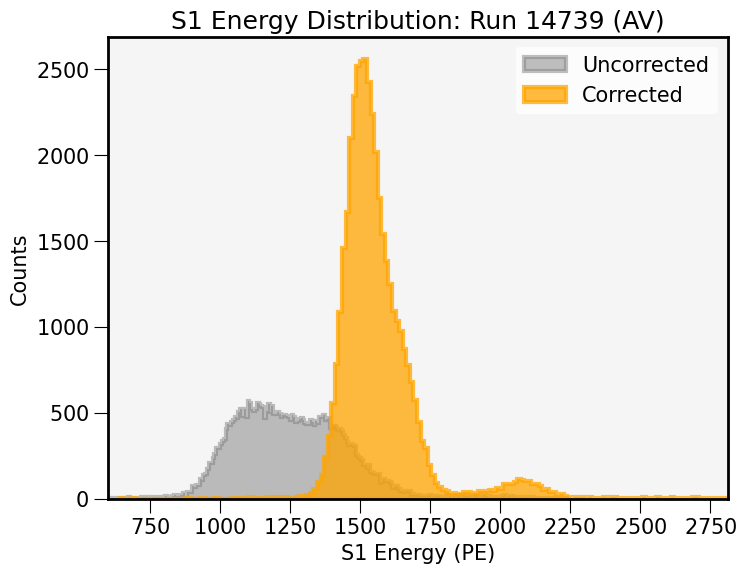

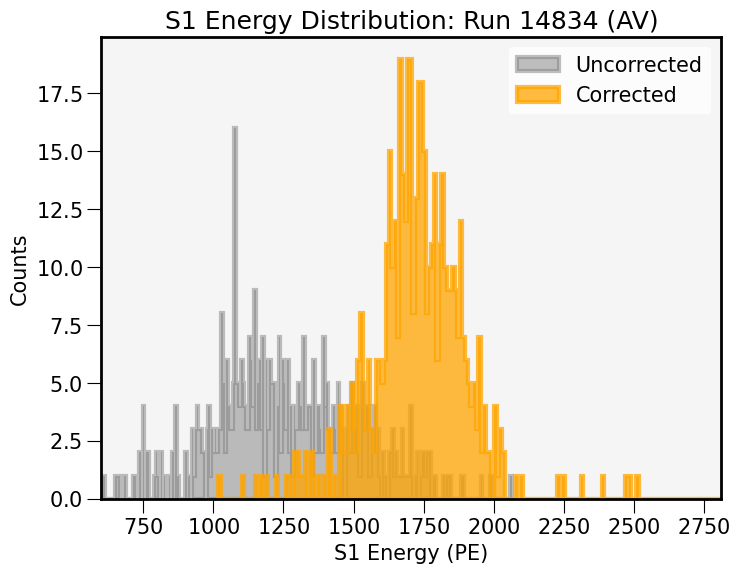

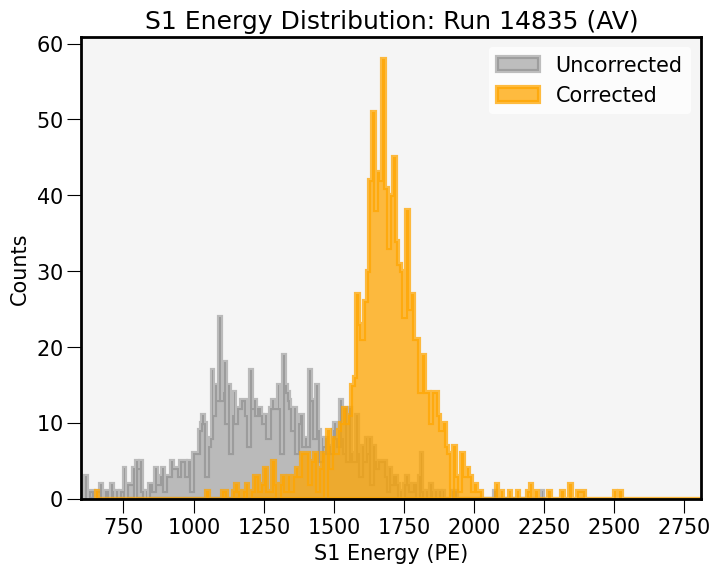

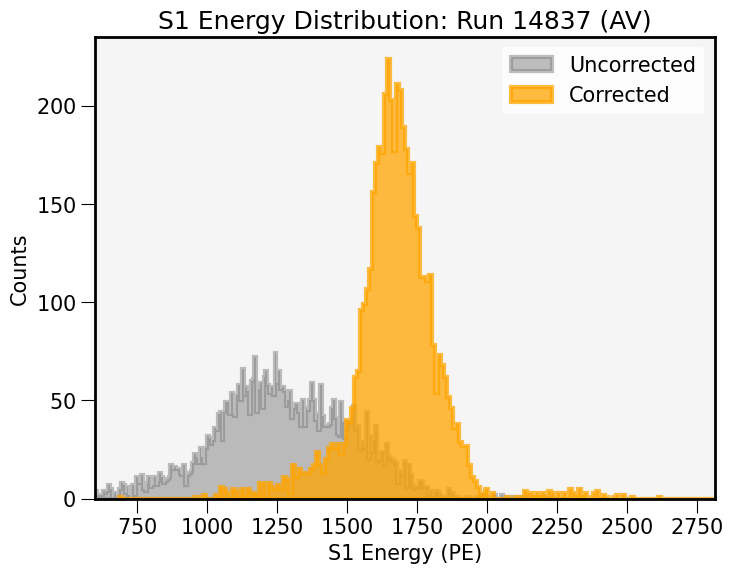

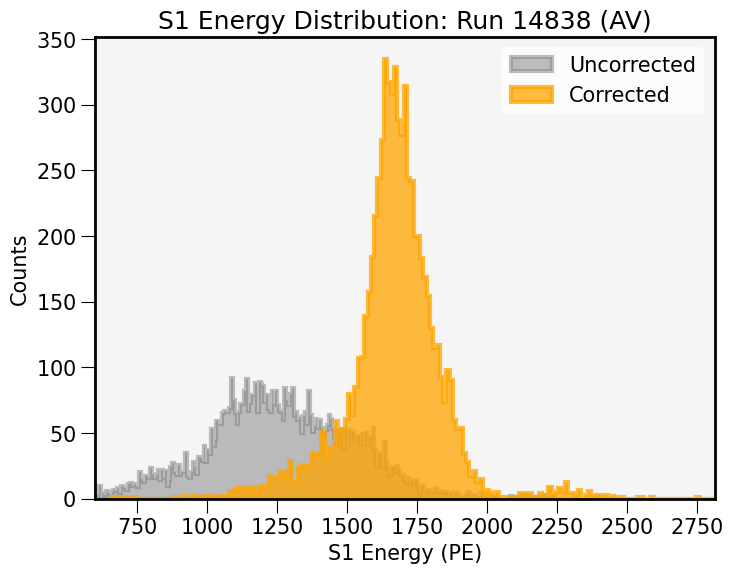

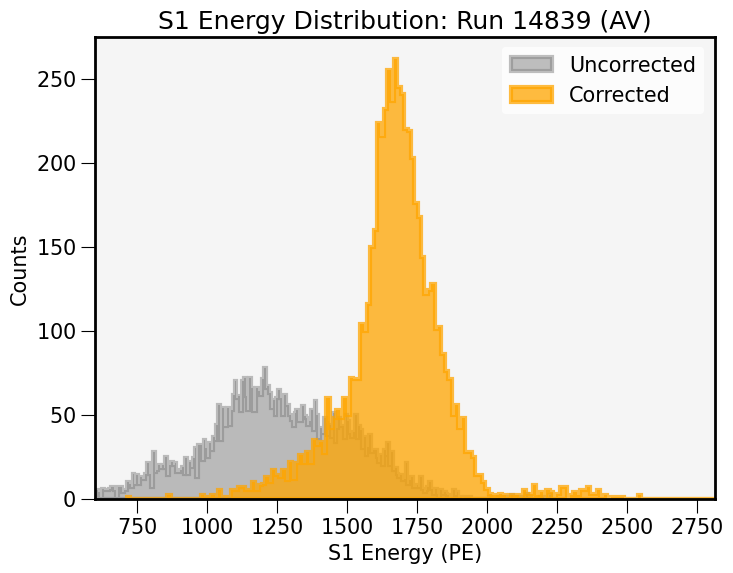

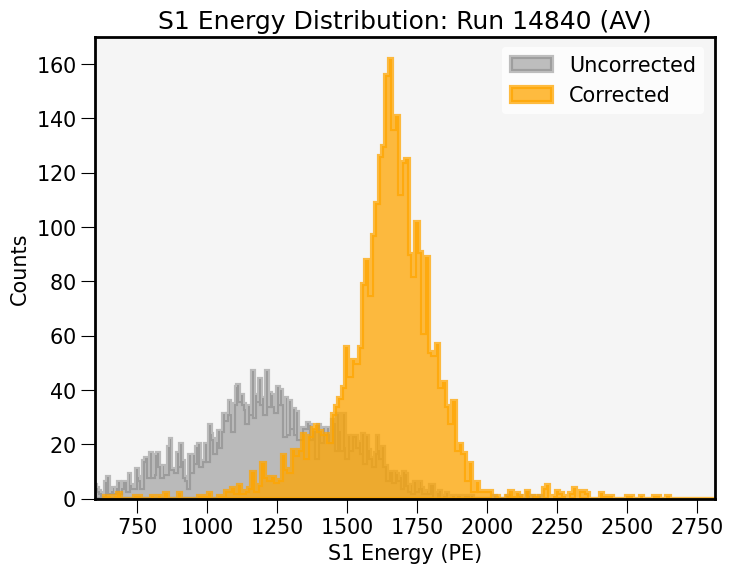

In [17]:
# Global
n_bins = 250
E1_min = 800;  E1_max = 2250

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    
    # Analysis runs
    if run_id in HIGH_RN_RUNS + LOW_RN_RUNS:
    
        # Variables    
        E1      = sel_data[run_id]['S1e']
        E1_corr = sel_data[run_id]['S1e_corr']

        # Masking
        E1_mask   = E1[AV_mask[run_id]]
        E1c_mask  = E1_corr[AV_mask[run_id]]

        # ----- Plotting ----- #
        plt.figure(figsize=(8, 6))

        plt.hist(E1_mask, bins=n_bins, histtype='stepfilled', color='grey', alpha=0.50, ec='grey', label='Uncorrected')
        plt.hist(E1c_mask, bins=n_bins,  histtype='stepfilled', color='orange', alpha=0.75, ec='orange', label='Corrected')

        # ----- Styling ----- #
        plt.xlabel('S1 Energy (PE)')        
        plt.xlim(0.75*E1_min, 1.25*E1_max)
        plt.ylabel('Counts')
        plt.title(f'S1 Energy Distribution: Run {run_id} (AV)')
        plt.legend()

        # plt.grid(True)
        plt.gca().set_facecolor('whitesmoke')
        plt.show()

### S2 Energy Corrected?

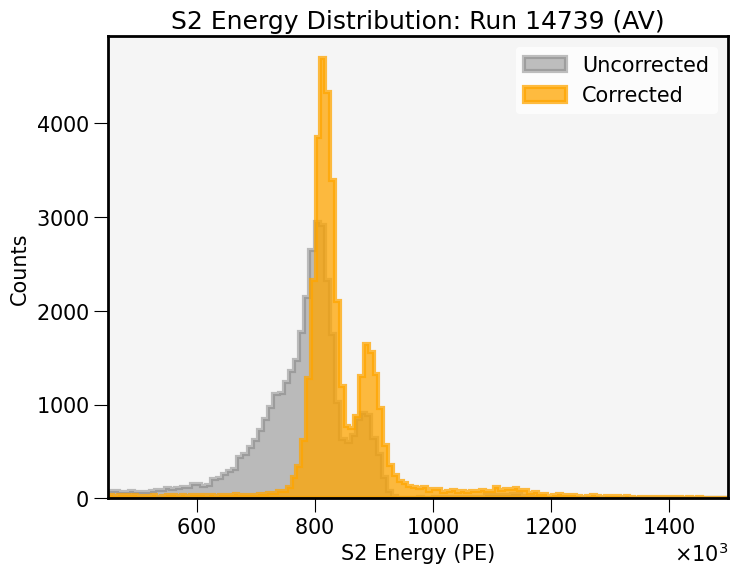

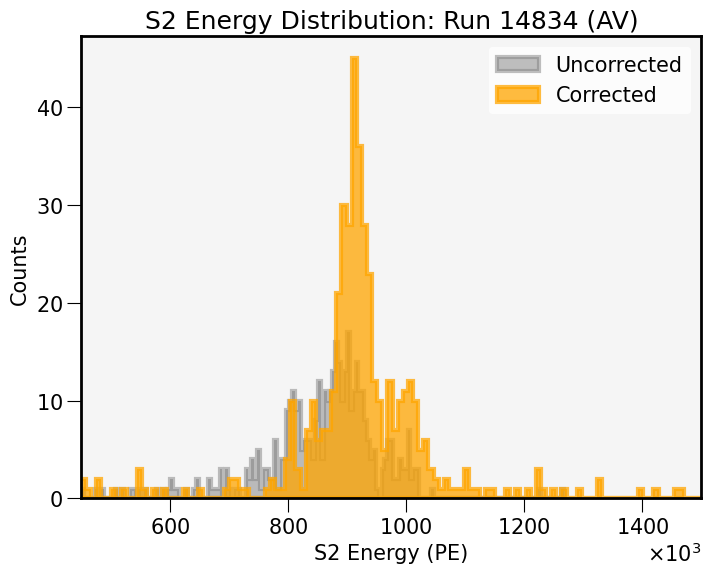

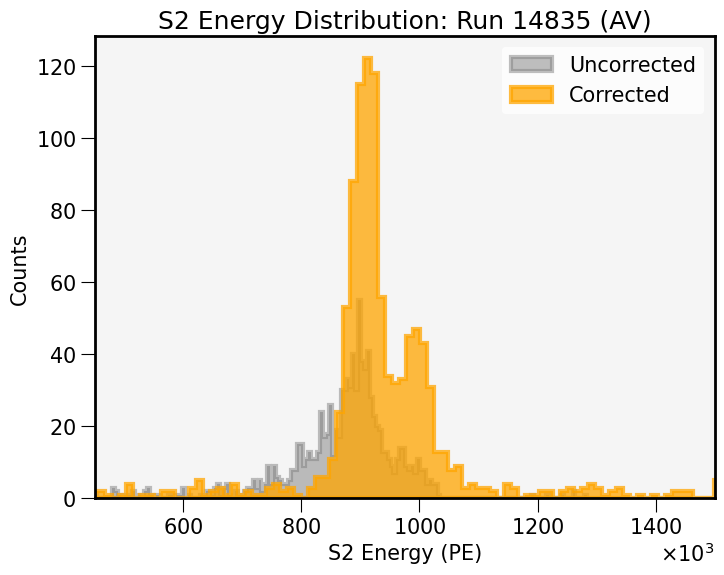

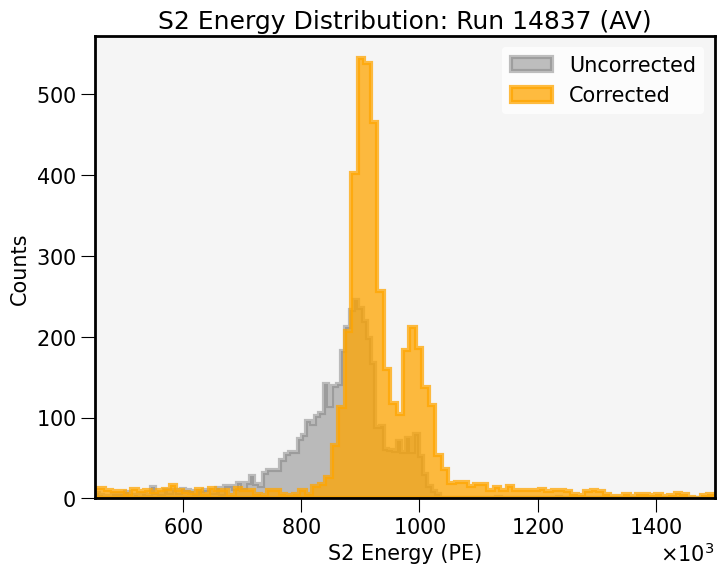

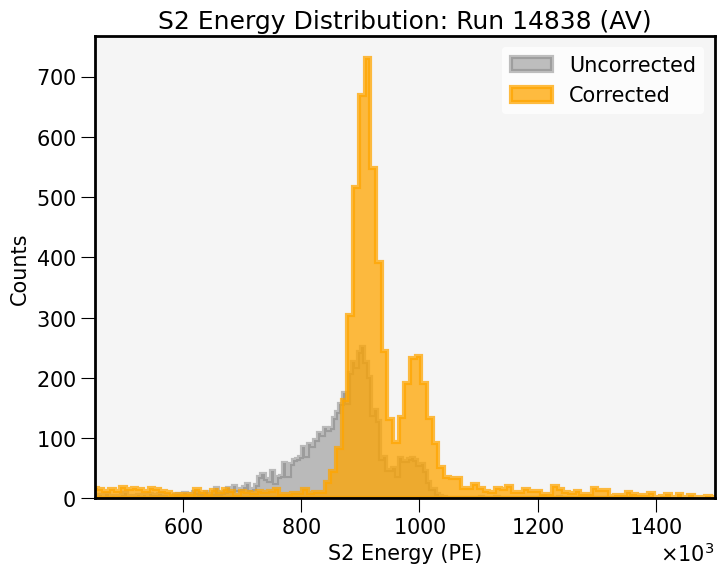

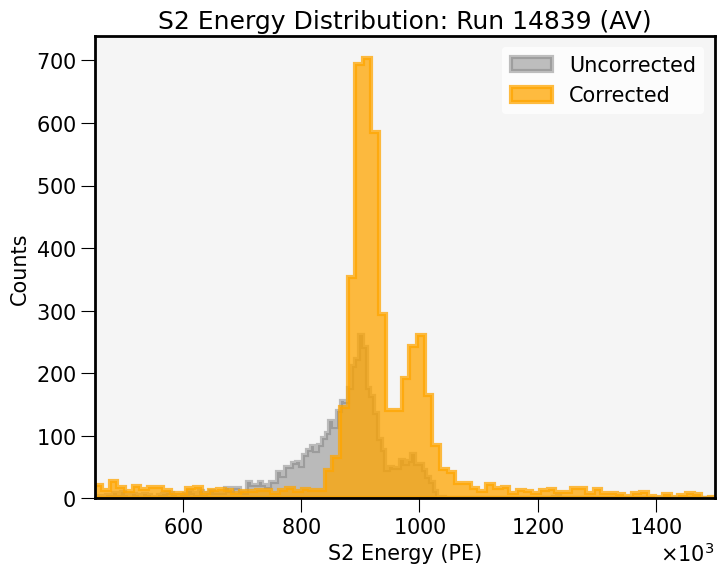

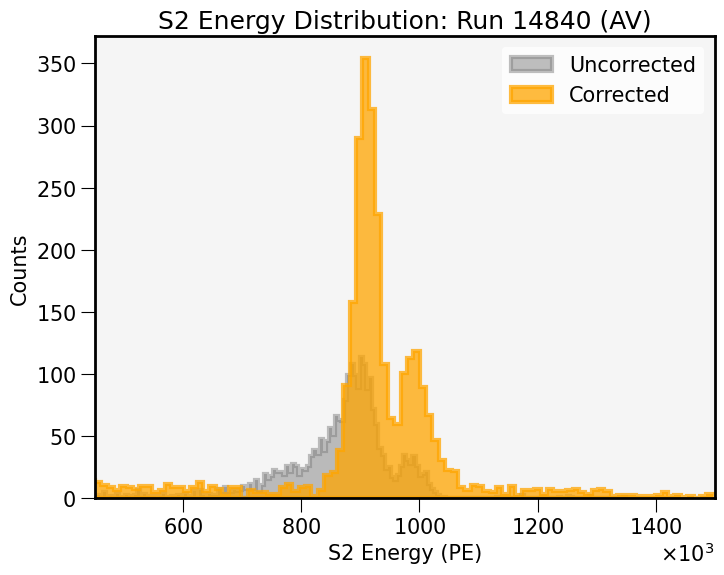

In [18]:
# Global
n_bins = 250
E2_min = 600e3;  E2_max = 1200e3

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    
    # Analysis runs
    if run_id in HIGH_RN_RUNS + LOW_RN_RUNS:
    
        # Variables    
        E2      = sel_data[run_id]['S2e']
        E2_corr = sel_data[run_id]['S2e_corr']

        # Masking
        E2_mask   = E2[AV_mask[run_id]]
        E_mask  = E2_corr[AV_mask[run_id]]        

        # ----- Plotting ----- #
        plt.figure(figsize=(8, 6))

        plt.hist(E2_mask, bins=n_bins, histtype='stepfilled', color='grey', alpha=0.50, ec='grey', label='Uncorrected')
        plt.hist(E_mask, bins=n_bins,  histtype='stepfilled', color='orange', alpha=0.75, ec='orange', label='Corrected')

        # ----- Styling ----- #
        plt.xlabel('S2 Energy (PE)')
        plt.xlim(0.75*E2_min, 1.25*E2_max)
        plt.ylabel('Counts')
        plt.ticklabel_format(axis='x', style='sci', scilimits=(3,3))
        plt.title(f'S2 Energy Distribution: Run {run_id} (AV)')
        plt.legend()

        #plt.grid(True)
        plt.gca().set_facecolor('whitesmoke')
        plt.show()

# High & Low-Rn Information

Not all the OK triggers correspond to alpha events.
<br>
Pau estimated the percentage of these triggers that are alphas through a discrimination in the $S1$ pulse. This value is what we call __alphas triggers__.


In [61]:
# Storage of Low_Rn dataframes
dfs = []          
# Low_Rn values: CV + error calculations
low_long = 0
low_trigg_CV = 0;  low_trigg_err = 0
low_reco_CV  = 0;  low_reco_err  = 0
low_sel_CV   = 0;  low_sel_err   = 0

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_long = entry["duration"]    
    run_OK   = entry["OK"] 
    run_LOST = entry["LOST"]
    
    if run_id in HIGH_RN_RUNS:

        # DAQe efficiency + error
        DAQe_CV, DAQe_error = ff.efficiency(run_OK, run_LOST)
        
        ANA_DATA['High_Rn']['df']            = sel_data[run_id]
        ANA_DATA['High_Rn']['duration_CV']   = run_long * DAQe_CV
        # Alpha trigger rate + error
        alpha_evt_cv  = run_OK * ALPHA_TRG_EFF_HIGH
        alpha_evt_err = alpha_evt_cv * np.sqrt((np.sqrt(run_OK) / run_OK)**2 + (TRG_EFF_ERR)**2)
        ANA_DATA['High_Rn']['alpha_rate_CV']  = alpha_evt_cv / (run_long * DAQe_CV)
        ANA_DATA['High_Rn']['alpha_rate_err'] = alpha_evt_err / (run_long * DAQe_CV)

    if run_id in LOW_RN_RUNS:

        # DAQe efficiency + error
        DAQe_CV, DAQe_error = ff.efficiency(run_OK, run_LOST)
        
        dfs.append(sel_data[run_id])
        low_long     += run_long * DAQe_CV

# Low-Rn complete information
ANA_DATA['Low_Rn']['df']             = pd.concat(dfs, ignore_index=True)
ANA_DATA['Low_Rn']['duration_CV']    = low_long
ANA_DATA['Low_Rn']['alpha_rate_CV']  = TRG_RATE_LOW_RN_CV * ALPHA_TRG_EFF_LOW
ANA_DATA['Low_Rn']['alpha_rate_err'] = (TRG_RATE_LOW_RN_CV * ALPHA_TRG_EFF_LOW) * np.sqrt((TRG_RATE_LOW_RN_ERR / TRG_RATE_LOW_RN_CV)**2 + (TRG_EFF_ERR)**2)

In [62]:
print("\n--- Summary of Analysis Data ---")
for key in ANA_DATA.keys():
    print(f"\n{key.upper()}")
    for subkey in ANA_DATA[key].keys():
        if subkey == 'df':
            continue
        print(f" {subkey}: {ANA_DATA[key][subkey]:.2f}")


--- Summary of Analysis Data ---

HIGH_RN
 duration_CV: 45718.51
 alpha_rate_CV: 42.51
 alpha_rate_err: 4.25

LOW_RN
 duration_CV: 275250.92
 alpha_rate_CV: 1.19
 alpha_rate_err: 0.13


#### Masking again!

In [63]:
# Global
n_bins = 80
step_back = 2       # To avoid completely the cathode

for i, entry in enumerate(ANA_DATA):
    
    Rn_data = ANA_DATA[entry]['df']
    
    # Variables
    DT = Rn_data['DT']
    # Compute histogram avoiding negative values of DT (just in case)
    counts, bins = np.histogram(DT, bins=n_bins, range=(0, DT.max()))
    # Find the index of the bin with the highest count (cathode peak)
    cath_index = np.argmax(counts)
    
    # Ensure step_back is valid
    if cath_index - step_back < 0:
        raise ValueError(f"Warning: Invalid step back for {entry}.")
    else:
        # Compute DT_stop by stepping back from the cathode peak
        ANA_DATA[entry]['DTstop_CV']  = (bins[cath_index - step_back] + bins[cath_index - step_back + 1]) / 2
        ANA_DATA[entry]['DTstop_err'] = (bins[cath_index - step_back + 1] - bins[cath_index - step_back]) / 2
        
    print(f"{entry}:\n  DT stop = ({ANA_DATA[entry]['DTstop_CV']:.2f} ± {ANA_DATA[entry]['DTstop_err']:.2f}) μs")
    
    # Active volume
    ANA_DATA[entry]['AV_mask']   = (DT >= 0) & (DT <  ANA_DATA[entry]['DTstop_CV'])
    # Cathode surroundings
    ANA_DATA[entry]['cath_mask'] = DT >=  ANA_DATA[entry]['DTstop_CV']

High_Rn:
  DT stop = (1310.67 ± 9.17) μs
Low_Rn:
  DT stop = (1306.29 ± 9.13) μs


# Spatial Distributions

## Drift Time

High_Rn:
Cathode time position = (1349.57 +/- 8.99) μs
Drift velocity = (0.87 +/- 0.01) mm/μs 

Low_Rn:
Cathode time position = (1349.57 +/- 8.99) μs
Drift velocity = (0.87 +/- 0.01) mm/μs 



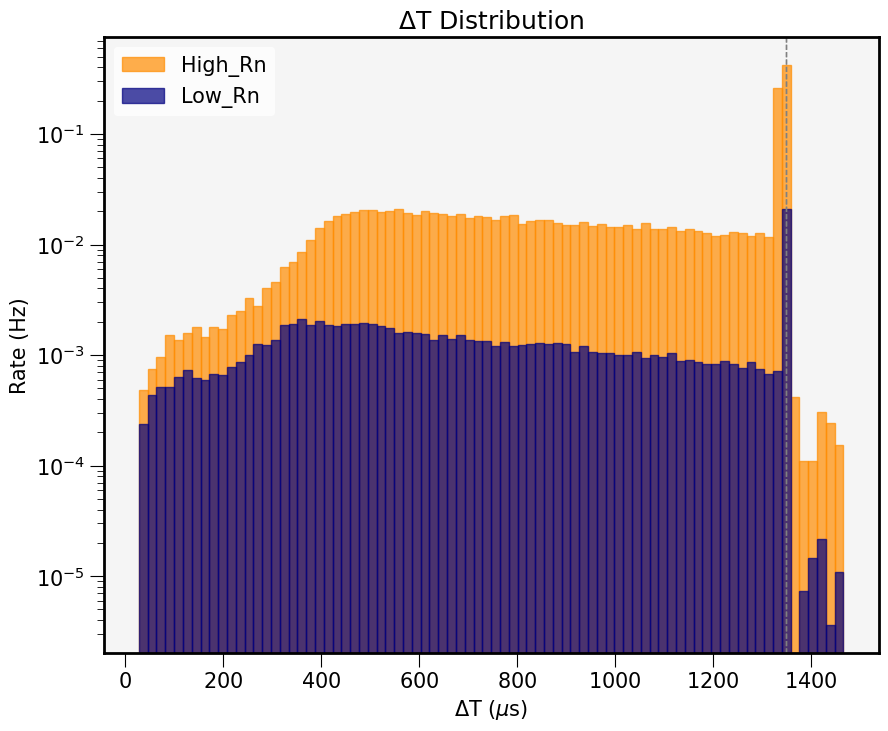

In [64]:
# Store important information
m_DT = {"High_Rn":{}, "Low_Rn":{}}  # Slopes from linear fit

# Global
n_bins = 80
DT_min = 400        # Lower limit for linear fit
color_index = 0     # Histogram color counter

# ----- Binning ----- #
data_std = ANA_DATA['High_Rn']['df']
_, DT_edges = np.histogram(data_std['DT'], bins=n_bins)

for i, entry in enumerate(ANA_DATA):
    
    Rn_data = ANA_DATA[entry]['df']
    Rn_long = ANA_DATA[entry]['duration_CV']
    
    # Variables
    DT = Rn_data['DT']

    # Histogram: normalized by corrected DAQ data taking time
    DT_counts, _ = np.histogram(DT, bins=DT_edges,  range=(0, DT.max()), density=False)
    DT_rate   = DT_counts / Rn_long
    bin_width = np.diff(DT_edges).mean()
    
    # Estimated cathode time position + error
    cath_index   = np.argmax(DT_counts)         # Index of the bin with the highest count
    cath_central = (DT_edges[cath_index] + DT_edges[cath_index + 1]) / 2      # Central value of the bin
    cath_error   = bin_width / 2

    # Drift velocity + error
    drift_vel      = (pt.N100_hei - pt.EL_gap) / cath_central
    drift_error    = drift_vel * (cath_error / cath_central)
    ANA_DATA[entry]['drift_vel_CV']  = drift_vel
    ANA_DATA[entry]['drift_vel_err'] = drift_error

    print(f'{entry}:')
    print(f'Cathode time position = ({cath_central:.2f} +/- {cath_error:.2f}) μs')
    print(f'Drift velocity = ({drift_vel:.2f} +/- {drift_error:.2f}) mm/μs \n')

    # Plot the normalized histogram + cathode line
    plt.bar(DT_edges[:-1], DT_rate, width=bin_width, align='edge', 
            color=pt.hist_colors[(3*i+2) % len(pt.hist_colors)], ec=pt.hist_colors[(3*i+2) % len(pt.hist_colors)],
            alpha=0.7, lw=1.0 , label=f'{entry}')         
    plt.axvline(x=cath_central, c='gray', ls='--', lw=1)  # Cathode line

    # ----- Linear fit ----- #
    # Preliminary
    DT_max = ANA_DATA[entry]['DTstop_CV']
    fit_region_mask = (DT >= DT_min) & (DT <= DT_max)
    DT_fit = DT[fit_region_mask]

    # Compute representative values for the fit
    fit_centers, _, fit_values, y_errors = ff.prefit_1D(DT_fit, DT_edges)
    # Filter out points with zero error (bins with 1 event)
    valid_points = y_errors > 0
    fit_centers = fit_centers[valid_points]
    fit_values  = fit_values[valid_points]

    popt, pcov = curve_fit(ff.linear_func, fit_centers, fit_values)
    m_DT[entry] = {'CV': popt[0], 'Error': np.sqrt(pcov[0, 0])}

    # Plot fit
    fit_y = ff.linear_func(fit_centers, *popt)
    # plt.plot(fit_centers, fit_y, c='red', ls='--', lw=1.5)

    color_index += 1
        
# ----- Styling ----- #
plt.xlabel('$\Delta$T ($\mu$s)')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.title(f'$\Delta$T Distribution')
plt.legend(loc='upper left')

plt.gca().set_facecolor("whitesmoke")
plt.show()

## Z

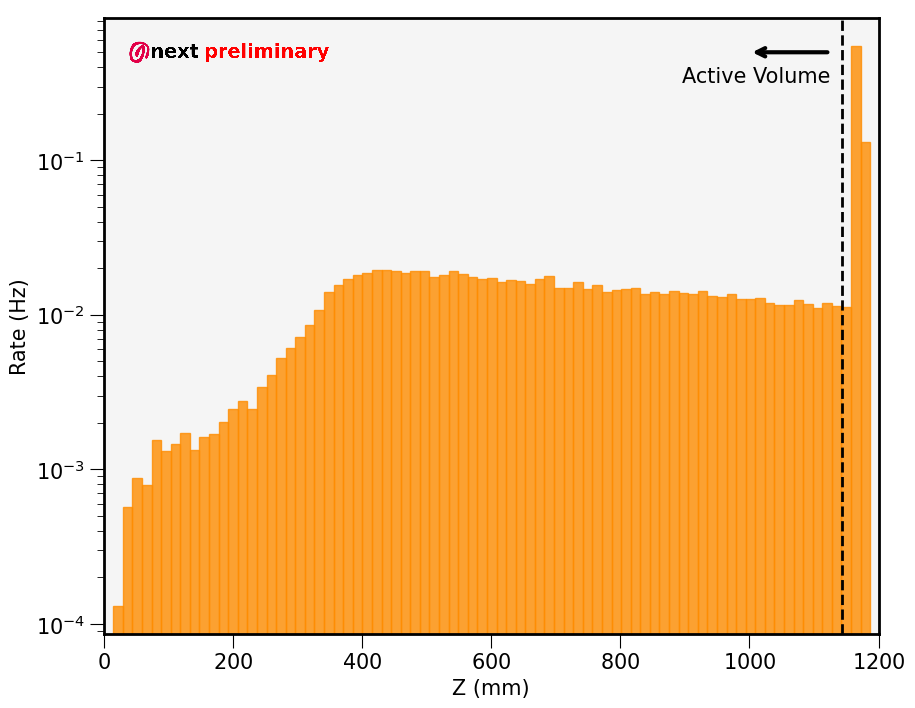

In [65]:
# Global
n_bins = 80

# Data
Rn_data = ANA_DATA['High_Rn']['df']
Rn_long = ANA_DATA['High_Rn']['duration_CV']

# Variables
DT = Rn_data['DT']

# Compute corrected Z
Z = ANA_DATA['High_Rn']['drift_vel_CV'] * DT

# Histogram: normalized by corrected DAQ data taking time
Z_counts, Z_edges = np.histogram(Z, bins=n_bins,  range=(0, pt.N100_hei))
Z_rate = Z_counts / Rn_long
bin_width = np.diff(Z_edges).mean()

# ----- Plotting ----- #
fig, ax = plt.subplots()

# Data
plt.bar(Z_edges[:-1], Z_rate, width=bin_width, align='edge', 
        color=pt.hist_colors[2], ec=pt.hist_colors[2],
        alpha=0.8, lw=1.0)

# Z-limit
Z_lim = ANA_DATA['High_Rn']['drift_vel_CV'] * ANA_DATA['High_Rn']['DTstop_CV']
plt.axvline(x=Z_lim, c='black', ls='--')
        
# ----- Styling ----- #
# Important text
plt.text(1125, 3.5e-1, 'Active Volume', va='center', ha='right')
ax.annotate('', xytext=(1125, 5e-1), xy=(1000, 5e-1), arrowprops=dict(arrowstyle='->',  ec='black', fc='black'))
# plt.text(1185, 1e-4, 'Cathode', va='bottom', ha='right', rotation=90)

# Preliminary logo
LOGO_BOX = OffsetImage(PRELIM_LOGO, zoom=0.1)
xy = (200, 5e-1)
ab = AnnotationBbox(LOGO_BOX, xy, xybox=(0, 0), xycoords='data', boxcoords="offset points", frameon=False)
ax.add_artist(ab)

plt.xlabel('Z (mm)')
plt.xlim(0, 1200)
plt.ylabel('Rate (Hz)')
plt.yscale('log')

plt.gca().set_facecolor("whitesmoke")
plt.savefig(f'/lhome/ific/c/ccortesp/Analysis/NEXT-100/Rn_analysis/images/Z_Dist.pdf')
plt.show()

## XY Map

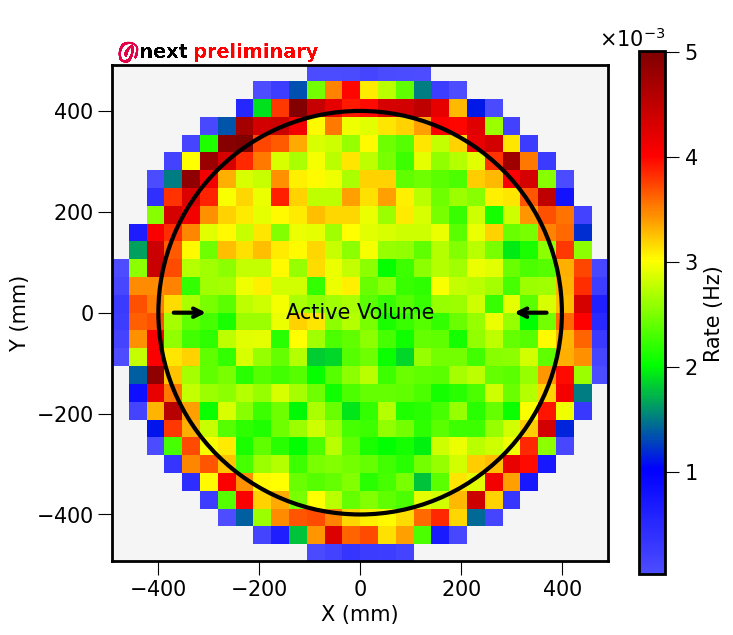

In [66]:
# Global
n_bins = 35

# Data
Rn_data = ANA_DATA['High_Rn']['df']
Rn_long = ANA_DATA['High_Rn']['duration_CV']

# Variables
X = Rn_data['X']
Y = Rn_data['Y']

# 2D histogram: normalized by corrected DAQ data taking time
XY_hit_map, ex, ey = pt.mapping(X, Y, xy_bins=n_bins, pos=True)
XY_rate            = XY_hit_map / Rn_long                          # Normalized to rate      
XY_rate            = np.ma.masked_where(XY_rate == 0, XY_rate)      # Zero values masked

# ----- Plotting ----- #
fig, ax = plt.subplots(figsize=(8, 8))
# Data
im = plt.pcolormesh(ex, ey, XY_rate.T, cmap=pt.custom_hsv, shading='auto')
# R-lim
plt.gca().add_patch(pt.plot_circle(400))

# ----- Styling ----- #
# Important text
plt.text(0, 0, 'Active Volume', va='center', ha='center')
ax.annotate('', xytext=(-375, 0), xy=(-300, 0), arrowprops=dict(arrowstyle='->',  ec='black', fc='black'))
ax.annotate('', xytext=(375, 0), xy=(300, 0), arrowprops=dict(arrowstyle='->',  ec='black', fc='black'))

# Preliminary logo
LOGO_BOX = OffsetImage(PRELIM_LOGO, zoom=0.1)
xy = (-275, 400)
ab = AnnotationBbox(LOGO_BOX, xy, xybox=(0, 42), xycoords='data', boxcoords="offset points", frameon=False)
ax.add_artist(ab)

cbar = plt.colorbar(im, label='Rate (Hz)', shrink=0.85)
# cbar.formatter.set_powerlimits((-3, 3))
plt.xlabel('X (mm)')
plt.xlim(-pt.N100_rad, pt.N100_rad)
plt.ylabel('Y (mm)')
plt.ylim(-pt.N100_rad, pt.N100_rad)

plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_facecolor("whitesmoke")
# plt.tight_layout()
plt.savefig(f'/lhome/ific/c/ccortesp/Analysis/NEXT-100/Rn_analysis/images/XY_Dist.pdf')
plt.show()

# Energy Estimator

We need to determine the optimum weight factor $\eta$ and the scale factor $\lambda$ for the new energy estimator using the $S1$ and $S2$ energy values.

In [68]:
# Parameters for the final energy estimator
Best_eta    = 0
High_lambda = 0
Low_lambda  = 0

## $\eta$ Determination

Because of statistics, we use the High-Rn run 14739.

Initial values: [2000, 1500.0, 4.251424564912923, 50, 2000.0, 4.251424564912923]
Final values: [ 594.6941063  1506.5319516    56.08497166  208.70842361 1641.88311426
   60.92933901]
Energy resolution: 8.7672%


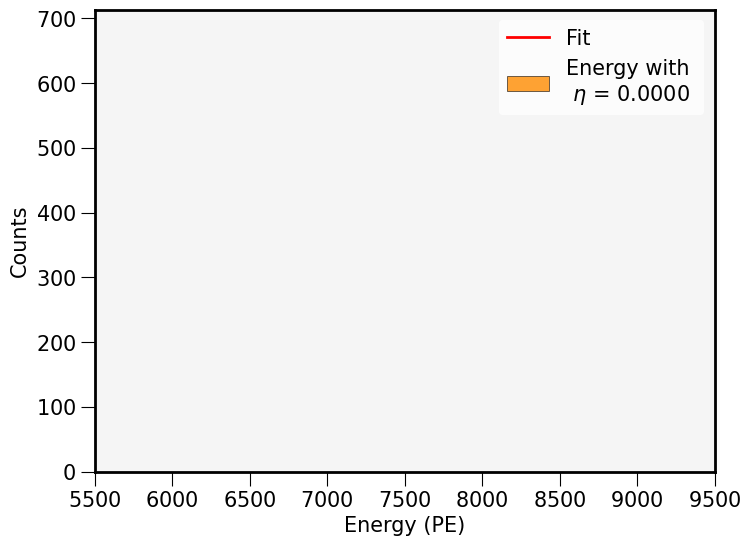

Initial values: [2000, 1923.4693877551022, 4.758576087982077, 50, 2474.4897959183672, 4.758576087982077]
Final values: [ 685.51501937 1922.84610018   54.32242531  236.93263195 2097.36239085
   59.63904266]
Energy resolution: 6.6531%


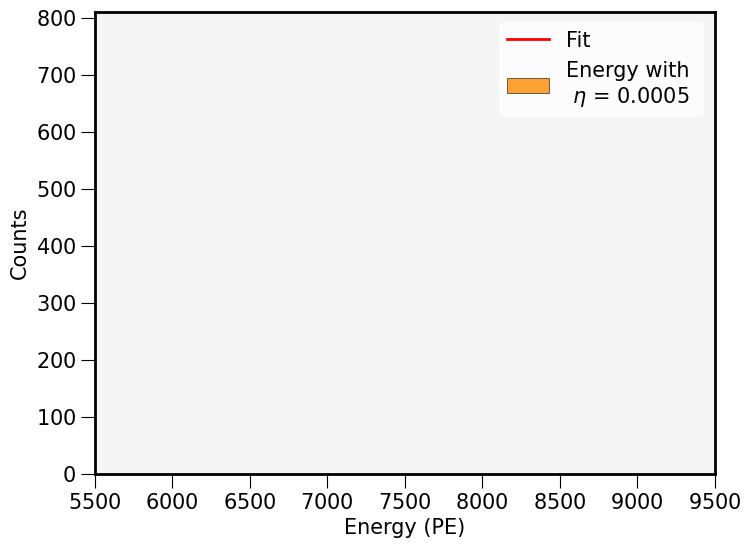

Initial values: [2000, 2346.9387755102043, 5.37746714048729, 50, 2948.979591836735, 5.37746714048729]
Final values: [ 771.87500528 2339.52698966   54.8397203   263.13885459 2552.80179596
   59.48849636]
Energy resolution: 5.5202%


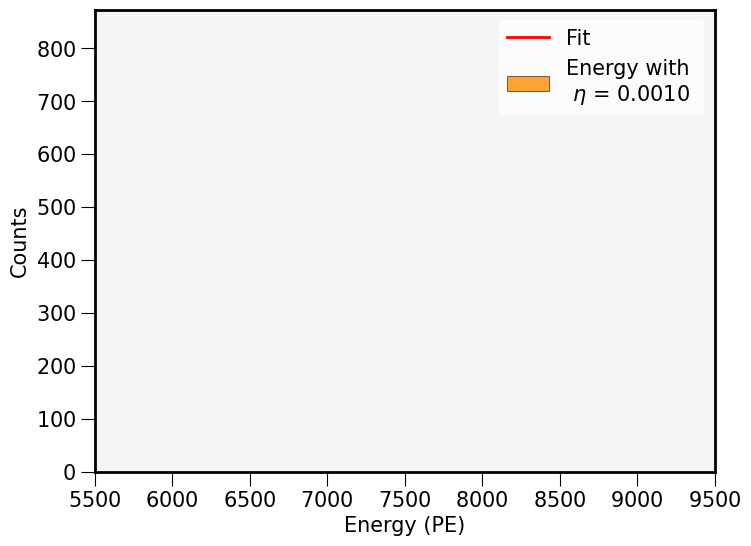

Initial values: [2000, 2770.408163265306, 5.996358192992501, 50, 3423.469387755102, 5.996358192992501]
Final values: [ 832.56971335 2756.23538721   56.79503172  283.53402689 3008.09808534
  -60.86157151]
Energy resolution: 4.8527%


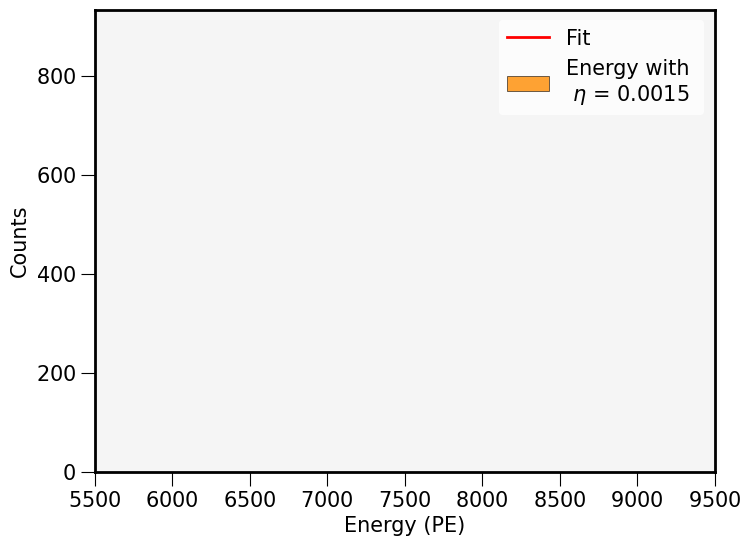

Initial values: [2000, 3193.8775510204086, 7.291376548397368, 50, 3897.95918367347, 7.291376548397368]
Final values: [ 959.43020779 3172.74771961   59.91194477  327.56582278 3463.38949222
  -63.7450359 ]
Energy resolution: 4.4470%


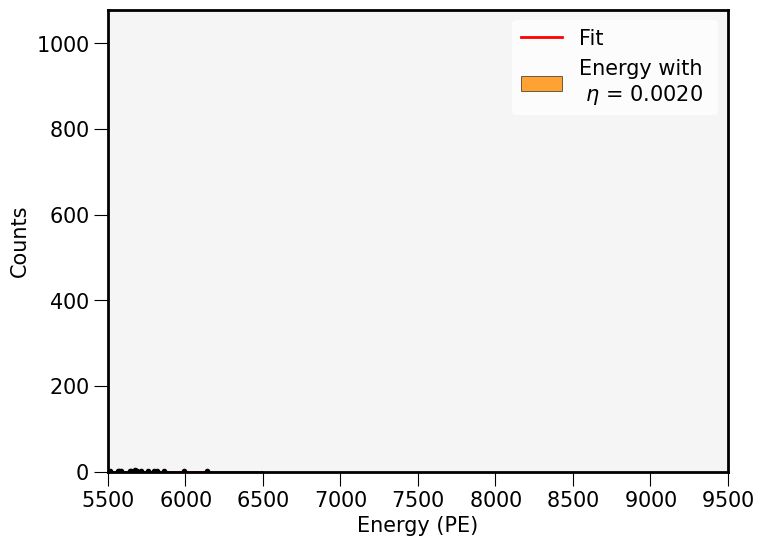

Initial values: [2000, 3617.3469387755104, 8.59656415113088, 50, 4372.448979591837, 8.59656415113088]
Final values: [1060.54594551 3589.30173498   63.81134655  361.90637424 3918.90539683
  -67.58219972]
Energy resolution: 4.1868%


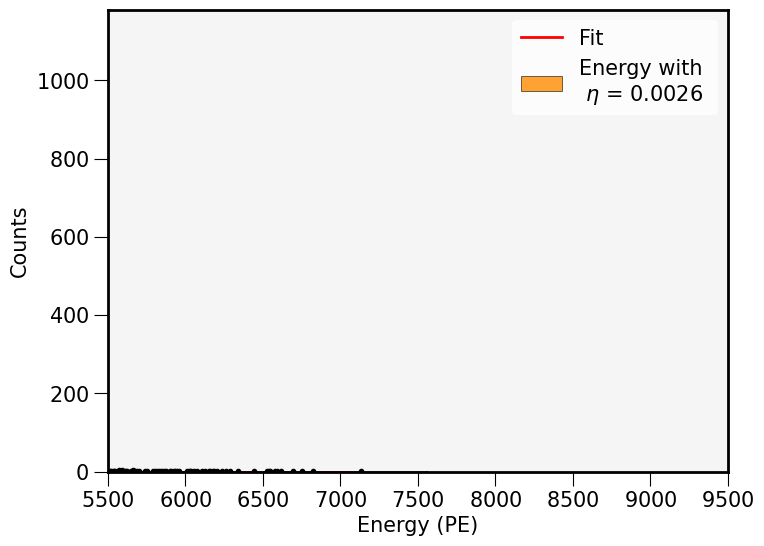

Initial values: [2000, 4040.8163265306125, 9.901751753864389, 50, 4846.938775510204, 9.901751753864389]
Final values: [1138.07829474 4005.82868986   68.27119001  388.25634812 4374.65695633
   72.24158051]
Energy resolution: 4.0136%


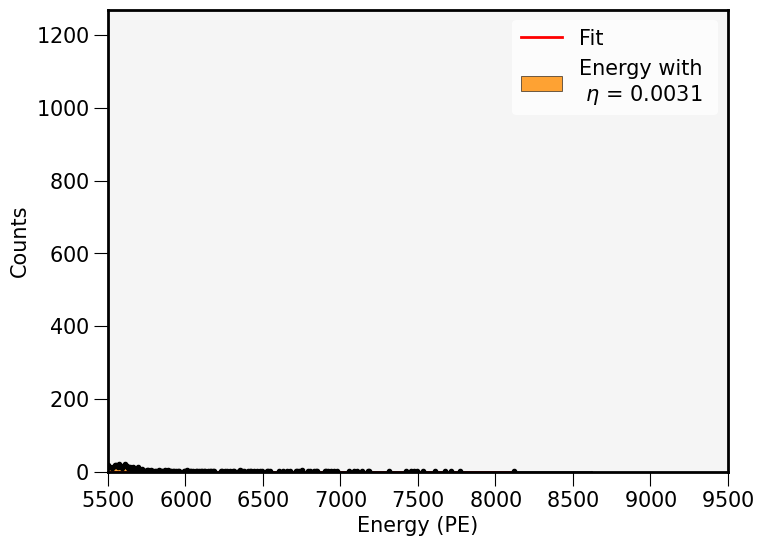

Initial values: [2000, 4464.285714285715, 11.259106870606749, 50, 5321.428571428572, 11.259106870606749]
Final values: [1202.70851535 4422.3664761    73.17904499  409.19959993 4830.29055459
   77.69819672]
Energy resolution: 3.8969%


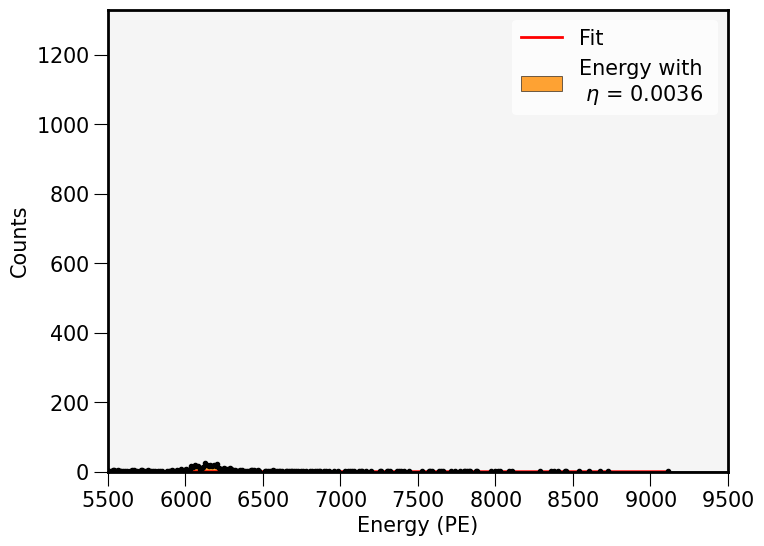

Initial values: [2000, 4887.755102040817, 12.649096819337004, 50, 5795.91836734694, 12.649096819337004]
Final values: [1256.42683264 4838.82059817   78.40600253  426.7332137  5285.70499041
  -83.43949477]
Energy resolution: 3.8159%


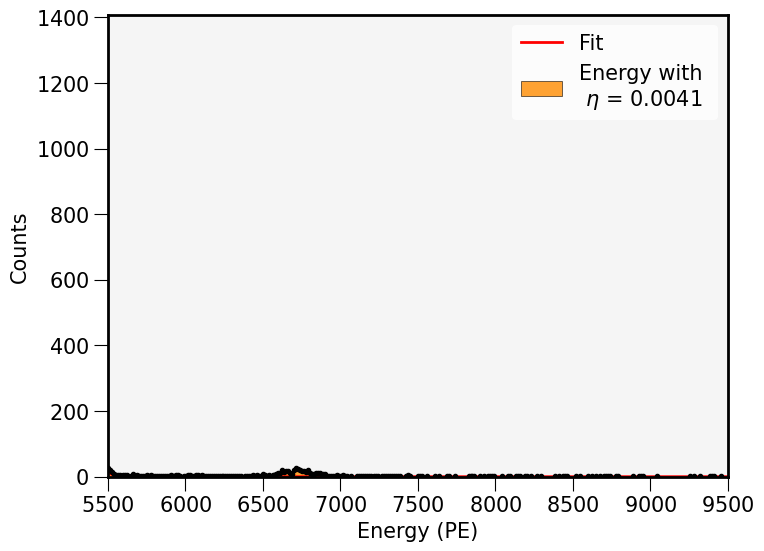

Initial values: [2000, 5311.224489795919, 14.039086768067257, 50, 6270.408163265307, 14.039086768067257]
Final values: [1296.63712584 5255.40278466   84.04194533  440.47607127 5741.26438872
  -89.32377558]
Energy resolution: 3.7660%


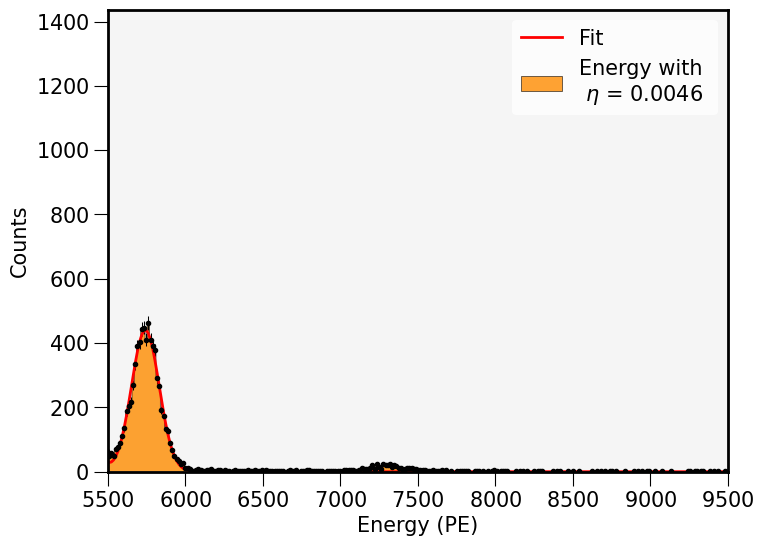

Initial values: [2000, 5734.693877551021, 15.429076716797514, 50, 6744.897959183674, 15.429076716797514]
Final values: [1326.97670293 5671.79155615   90.00450696  449.5180673  6196.44793328
   96.1154208 ]
Energy resolution: 3.7371%


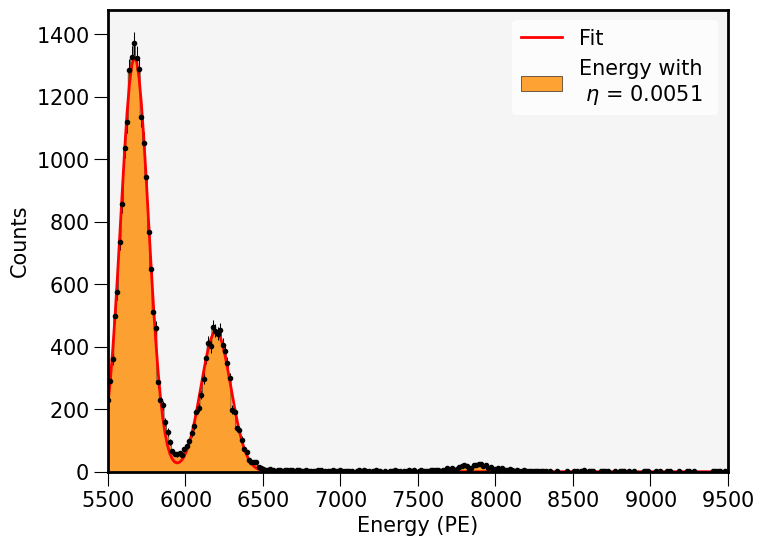

Initial values: [2000, 6158.163265306123, 16.819066665527767, 50, 7219.387755102041, 16.819066665527767]
Final values: [1350.98122291 6088.29261389   96.13213321  455.70771788 6651.91451814
  103.19120878]
Energy resolution: 3.7185%


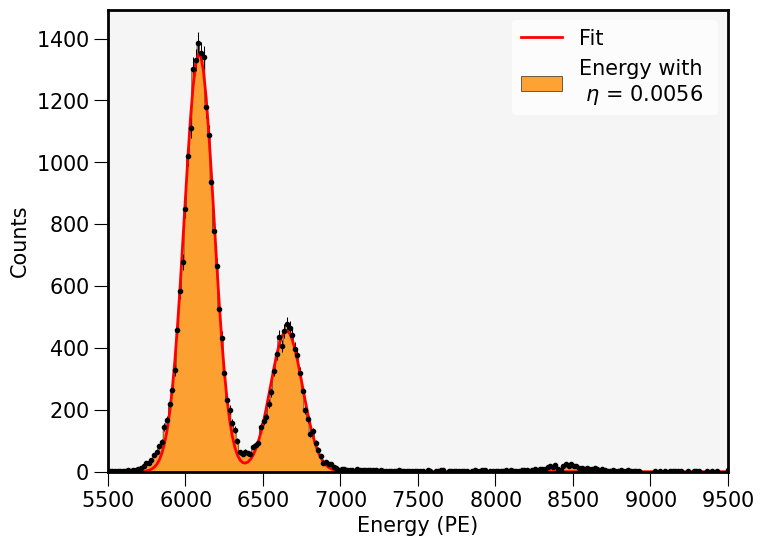

Initial values: [2000, 6581.632653061225, 18.209056614258024, 50, 7693.877551020409, 18.209056614258024]
Final values: [1367.35787821 6504.88464611  102.67832492  461.1580266  7107.17116817
  110.36240918]
Energy resolution: 3.7173%


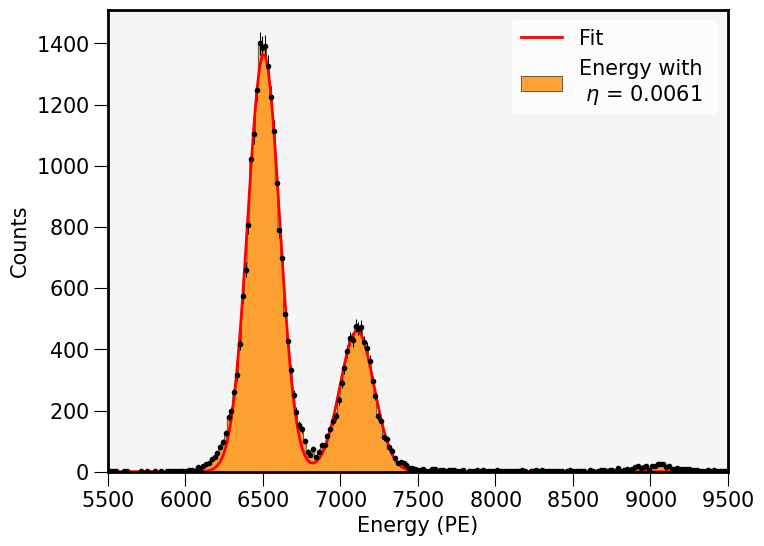

Initial values: [2000, 7005.102040816327, 19.599046562988278, 50, 8168.367346938776, 19.599046562988278]
Final values: [1378.8784908  6921.42710153  109.48346342  463.14402713 7562.45440707
  118.45220107]
Energy resolution: 3.7252%


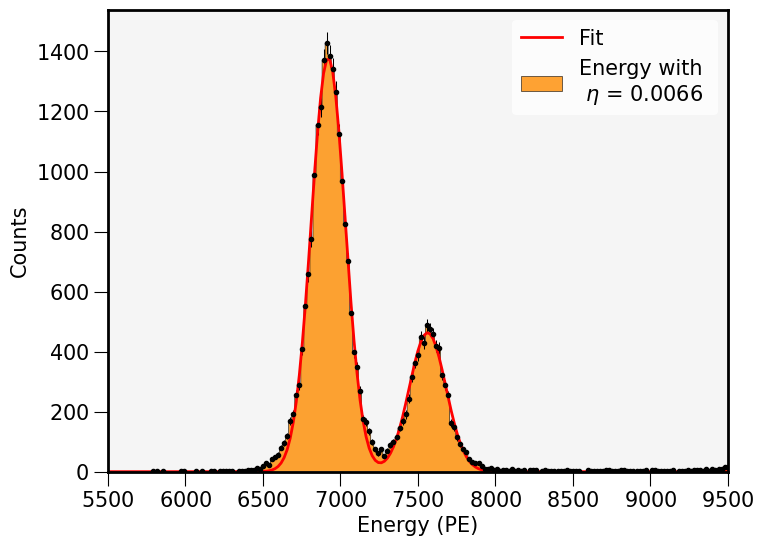

Initial values: [2000, 7428.571428571429, 20.989036511718535, 50, 8642.857142857143, 20.989036511718535]
Final values: [1388.76534593 7337.94382667  116.25103714  465.09628155 8017.63855129
  126.45524843]
Energy resolution: 3.7309%


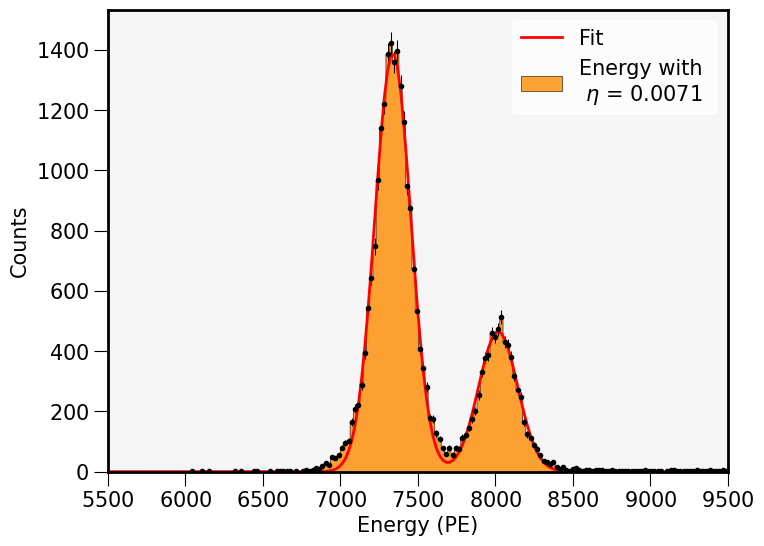

Initial values: [2000, 7852.040816326531, 22.379026460448788, 50, 9117.34693877551, 22.379026460448788]
Final values: [1395.41566823 7754.49329788  123.26174052  467.05312475 8473.14151835
  134.40942991]
Energy resolution: 3.7434%


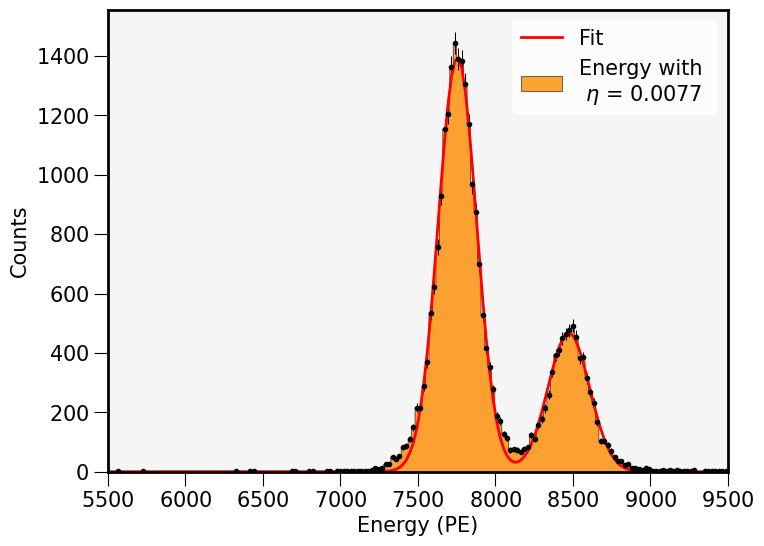

Initial values: [2000, 8275.510204081635, 23.76901640917905, 50, 9591.83673469388, 23.76901640917905]
Final values: [1398.88264215 8170.93417185  130.54699778  467.68090952 8927.90253068
  142.74908165]
Energy resolution: 3.7626%


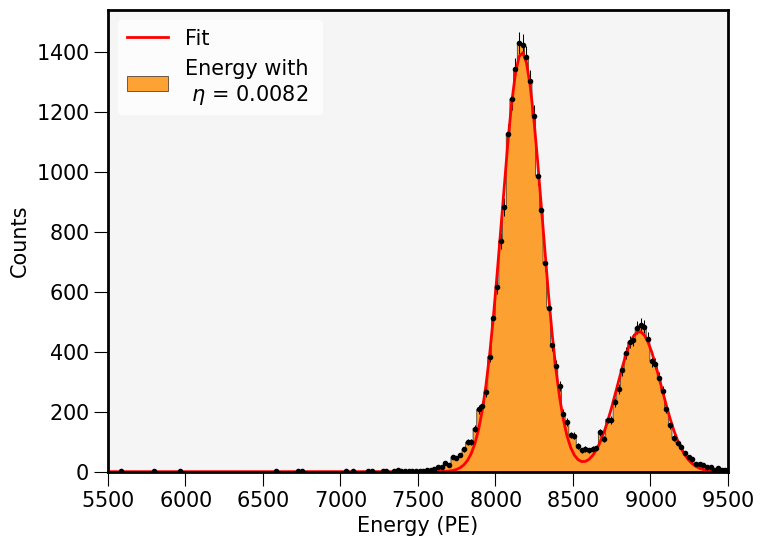

Initial values: [2000, 8698.979591836734, 25.159006357909302, 50, 10066.326530612245, 25.159006357909302]
Final values: [1401.90112617 8587.40836241  137.83760219  467.82167779 9383.12676846
  151.33837032]
Energy resolution: 3.7800%


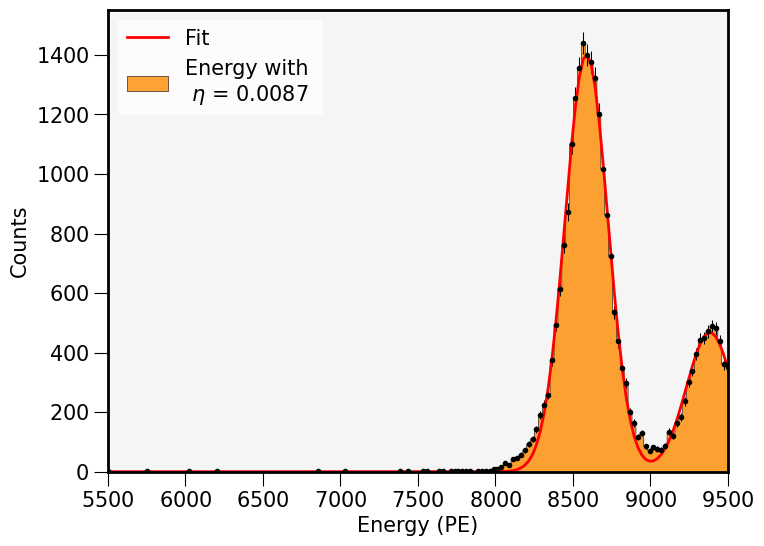

Initial values: [2000, 9122.448979591838, 26.54899630663956, 50, 10540.816326530614, 26.54899630663956]
Final values: [1405.43734062 9003.98893281  144.97643156  467.30187508 9837.85421102
  160.25437783]
Energy resolution: 3.7919%


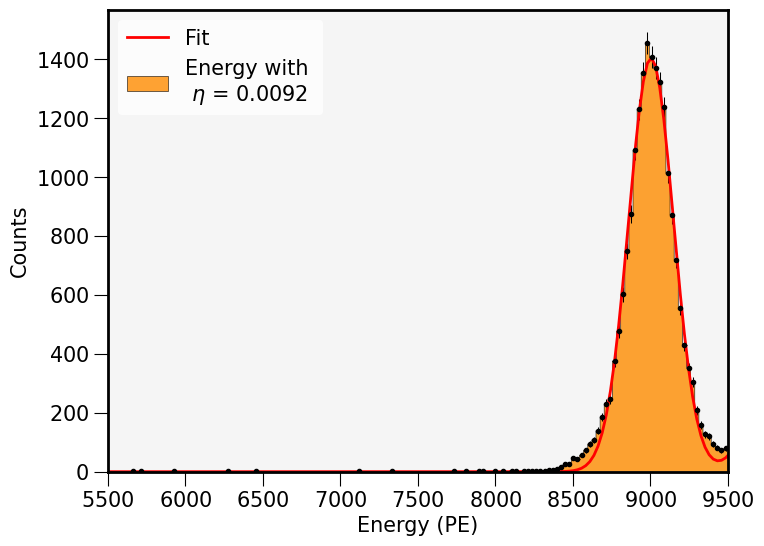

Initial values: [2000, 9545.918367346942, 27.93898625536982, 50, 11015.306122448981, 27.93898625536982]
Final values: [ 1406.07588319  9420.38430829   152.48784259   467.7980999
 10293.00654632   168.6491136 ]
Energy resolution: 3.8120%


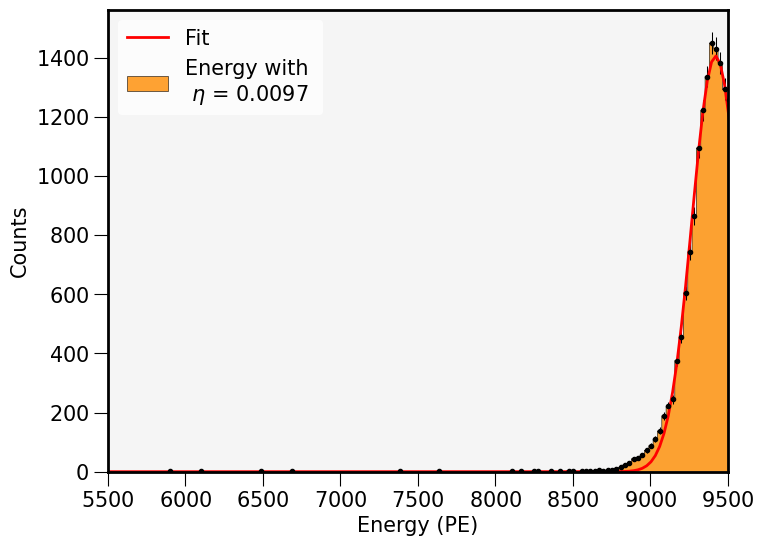

Initial values: [2000, 9969.387755102041, 29.328976204100066, 50, 11489.795918367348, 29.328976204100066]
Final values: [ 1406.34341272  9836.9074252    160.049386     467.49114532
 10748.08955507   177.34739956]
Energy resolution: 3.8317%


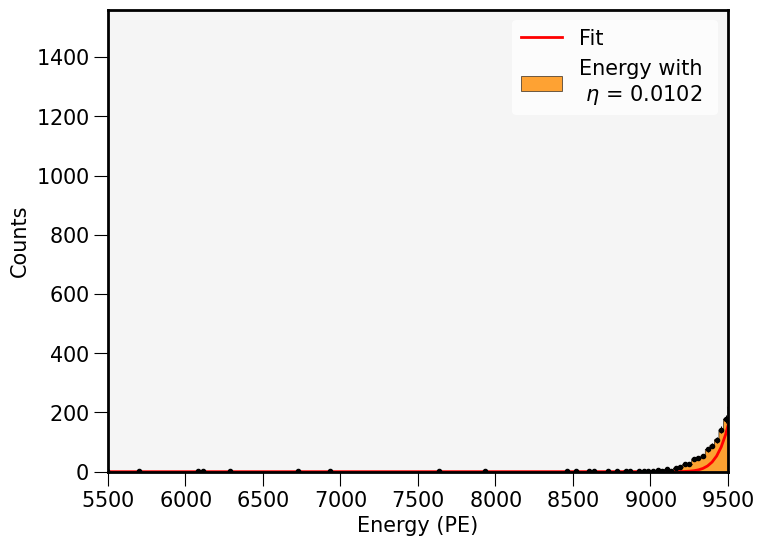

Initial values: [2000, 10392.857142857143, 30.718966152830316, 50, 11964.285714285714, 30.718966152830316]
Final values: [ 1404.9117467  10253.5058751    167.84486538   466.59972066
 11202.98771574   186.40521921]
Energy resolution: 3.8550%


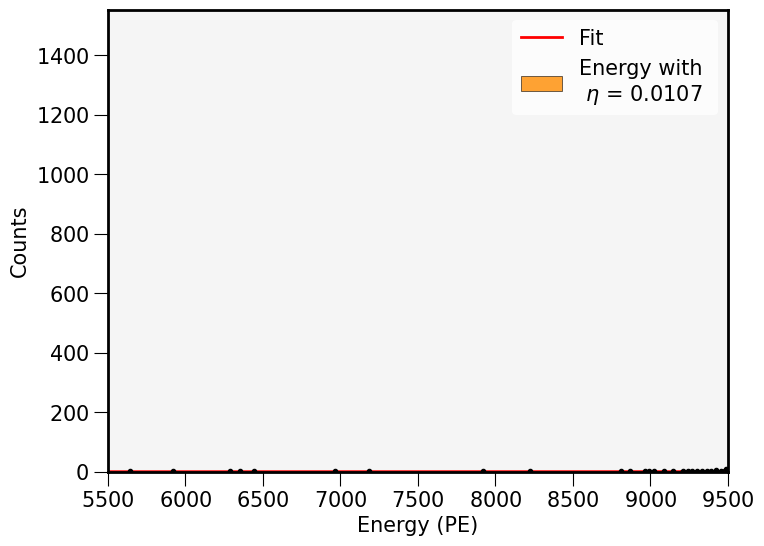

Initial values: [2000, 10816.326530612247, 32.10895610156058, 50, 12438.775510204083, 32.10895610156058]
Final values: [ 1404.69130752 10670.12967832   175.47556496   465.59975429
 11657.90236071   195.48854225]
Energy resolution: 3.8729%


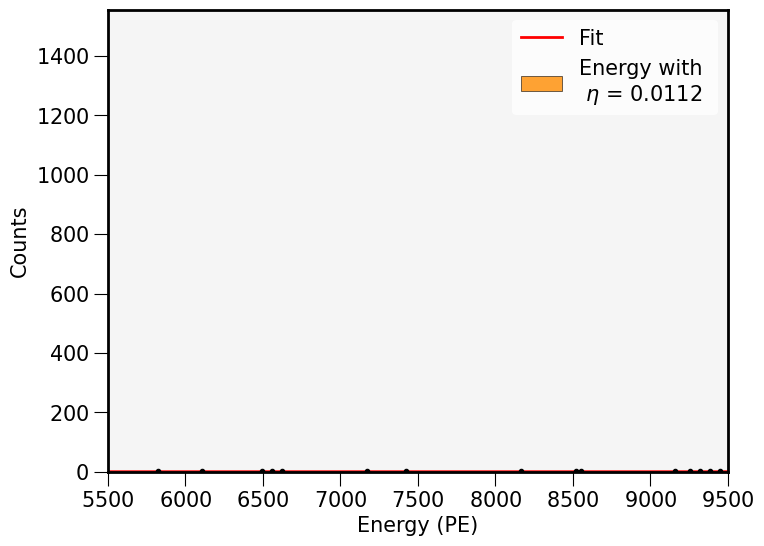

Initial values: [2000, 11239.795918367348, 33.49894605029083, 50, 12913.26530612245, 33.49894605029083]
Final values: [ 1404.07645772 11086.65179374   183.1656296    464.91968546
 12113.10579785   204.47238109]
Energy resolution: 3.8908%


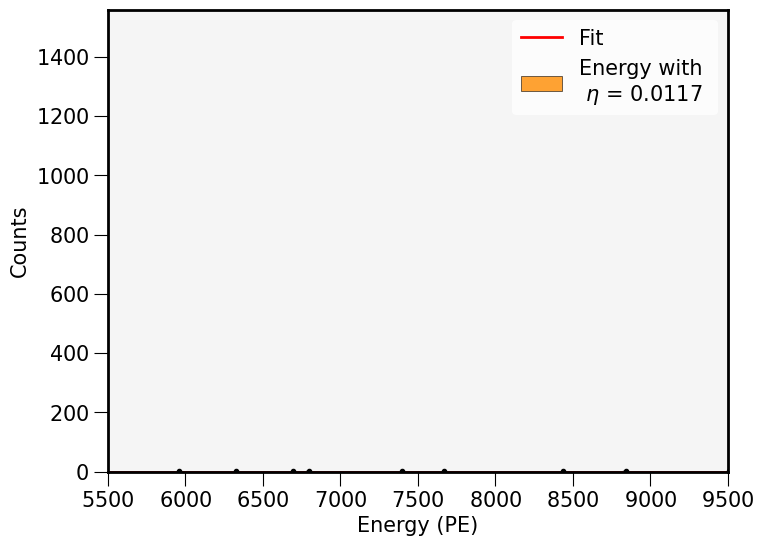

Initial values: [2000, 11663.26530612245, 34.888935999021086, 50, 13387.755102040817, 34.888935999021086]
Final values: [ 1401.92810834 11503.14241771   191.1460259    464.17295943
 12567.88663557   213.51421972]
Energy resolution: 3.9133%


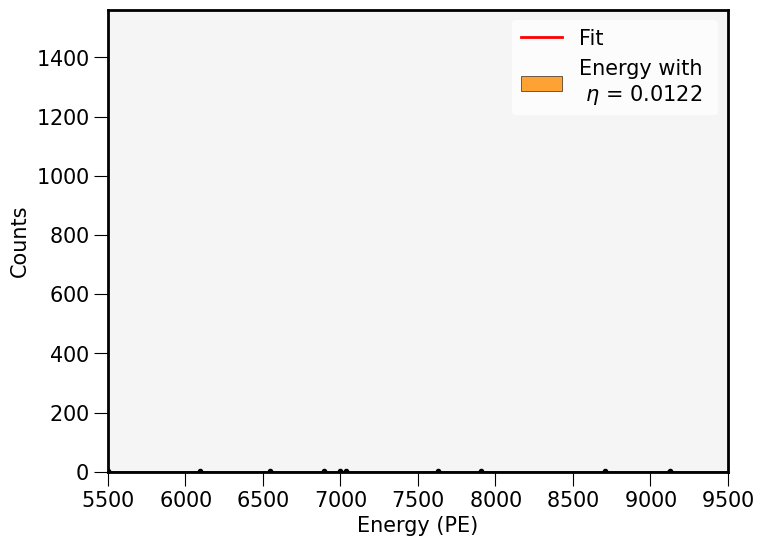

Initial values: [2000, 12086.734693877552, 36.27892594775134, 50, 13862.244897959185, 36.27892594775134]
Final values: [ 1401.00822769 11919.59250604   198.91594888   462.99832606
 13022.76499586   222.87693277]
Energy resolution: 3.9301%


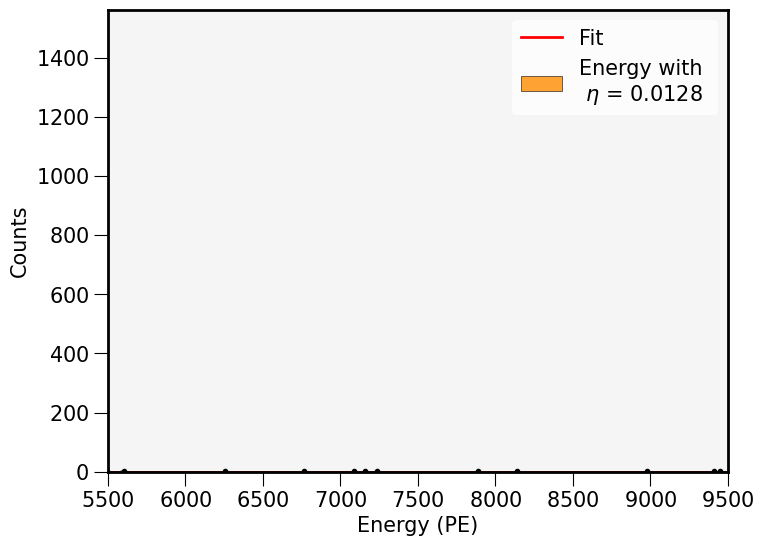

Initial values: [2000, 12510.204081632653, 37.6689158964816, 50, 14336.734693877552, 37.6689158964816]
Final values: [ 1398.92363578 12335.96908859   206.91212673   463.15721994
 13477.69013978   231.43232106]
Energy resolution: 3.9501%


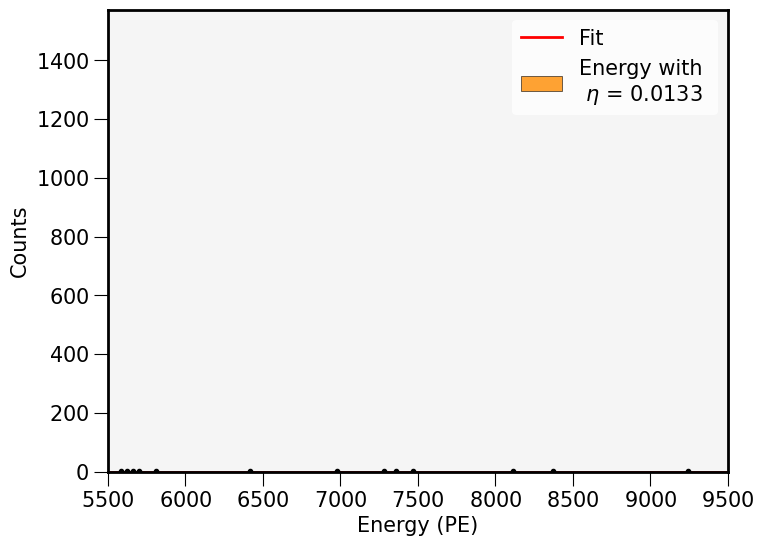

Initial values: [2000, 12933.673469387757, 39.05890584521186, 50, 14811.22448979592, 39.05890584521186]
Final values: [ 1397.8328035  12752.53170437   214.69092716   461.85559892
 13932.37814658  -240.93710309]
Energy resolution: 3.9647%


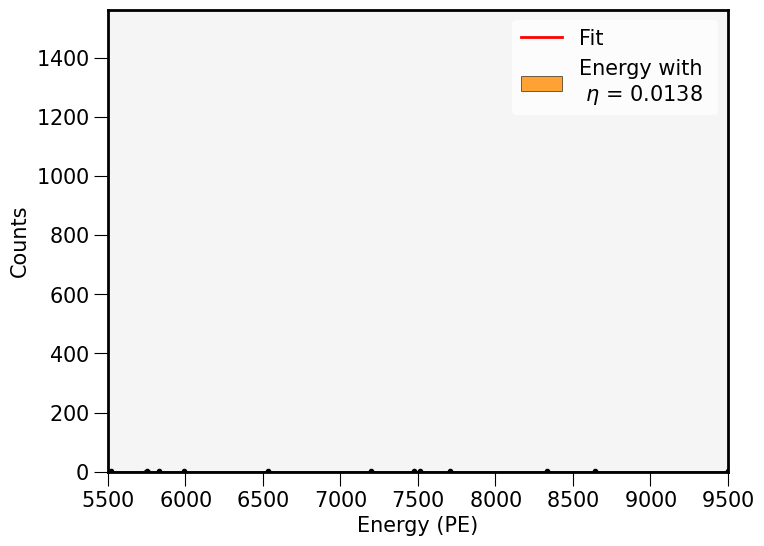

Initial values: [2000, 13357.142857142859, 40.44889579394211, 50, 15285.714285714286, 40.44889579394211]
Final values: [ 1394.57732007 13169.11760844   222.98891175   461.56965437
 14387.42829651   249.7936819 ]
Energy resolution: 3.9877%


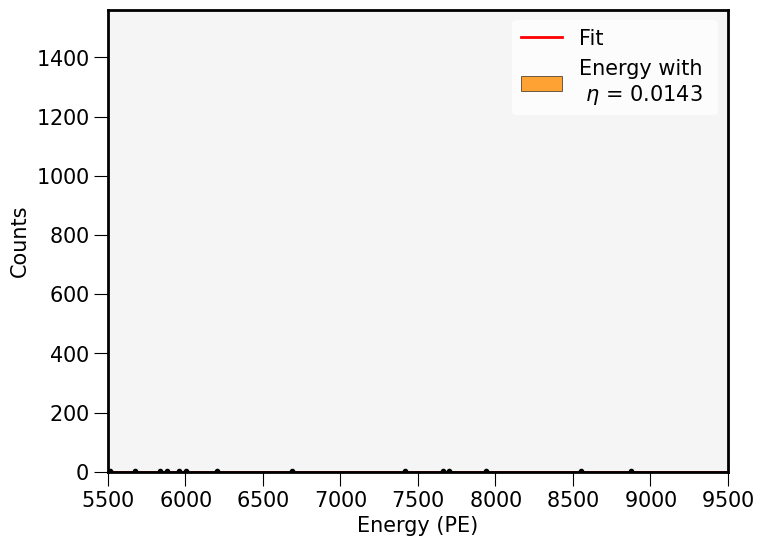

Initial values: [2000, 13780.61224489796, 41.83888574267236, 50, 15760.204081632653, 41.83888574267236]
Final values: [ 1392.85766774 13585.74711295   230.98496225   460.97003446
 14842.61605414   258.87239715]
Energy resolution: 4.0040%


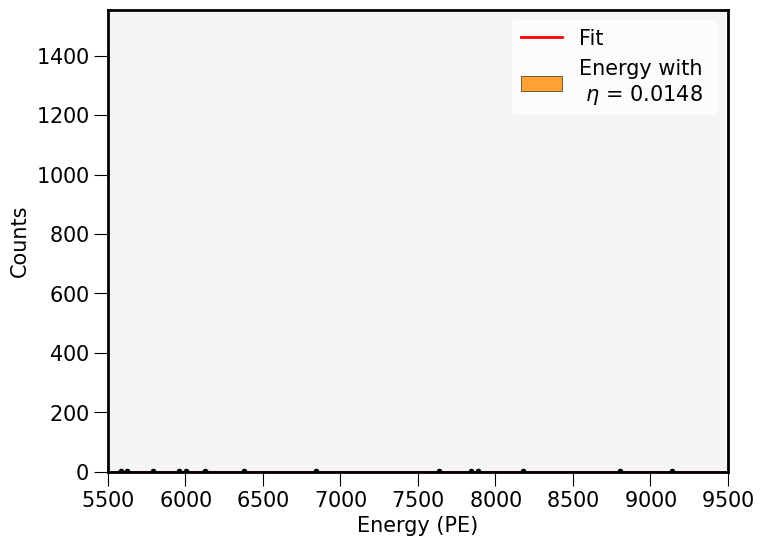

Initial values: [2000, 14204.081632653062, 43.22887569140263, 50, 16234.693877551023, 43.22887569140263]
Final values: [ 1392.61368711 14002.16372609   238.63473881   460.01830088
 15297.78430675   268.32542587]
Energy resolution: 4.0136%


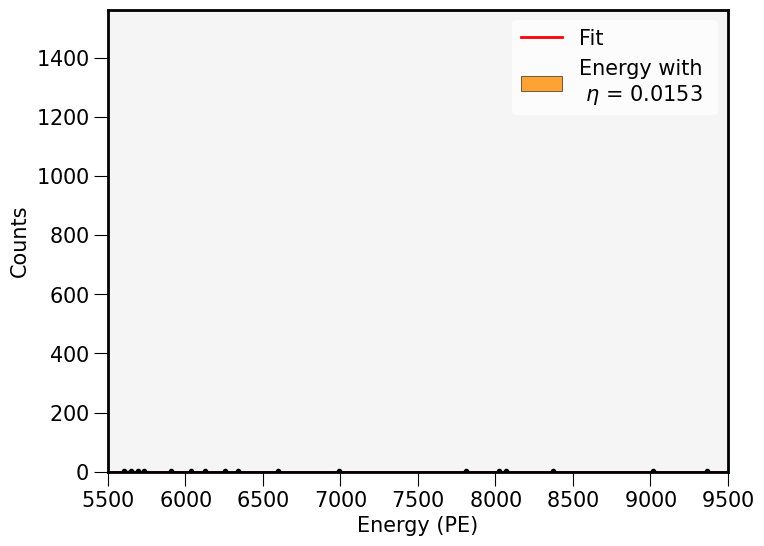

Initial values: [2000, 14627.551020408166, 44.61886564013288, 50, 16709.18367346939, 44.61886564013288]
Final values: [ 1391.34558816 14418.7394       246.58058919   459.26090406
 15752.57772656   277.68093266]
Energy resolution: 4.0274%


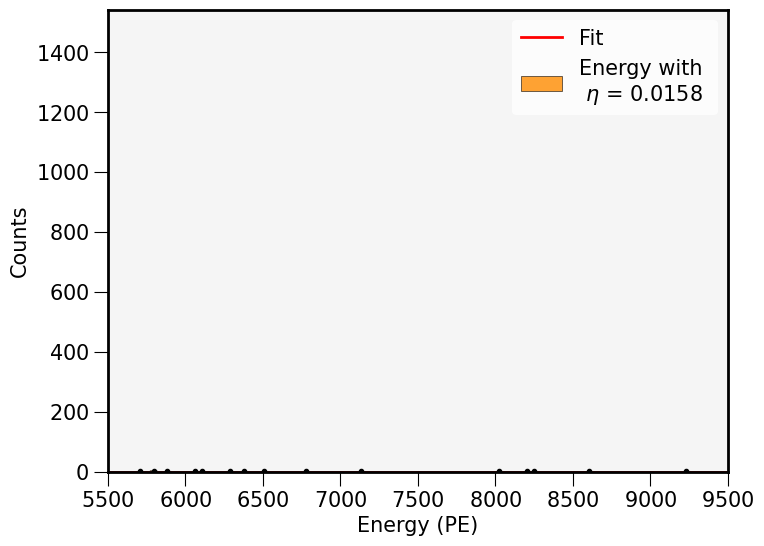

Initial values: [2000, 15051.020408163267, 46.008855588863135, 50, 17183.67346938776, 46.008855588863135]
Final values: [ 1390.78658503 14835.13704218   254.35928978   458.31348301
 16207.30603083   287.15220986]
Energy resolution: 4.0378%


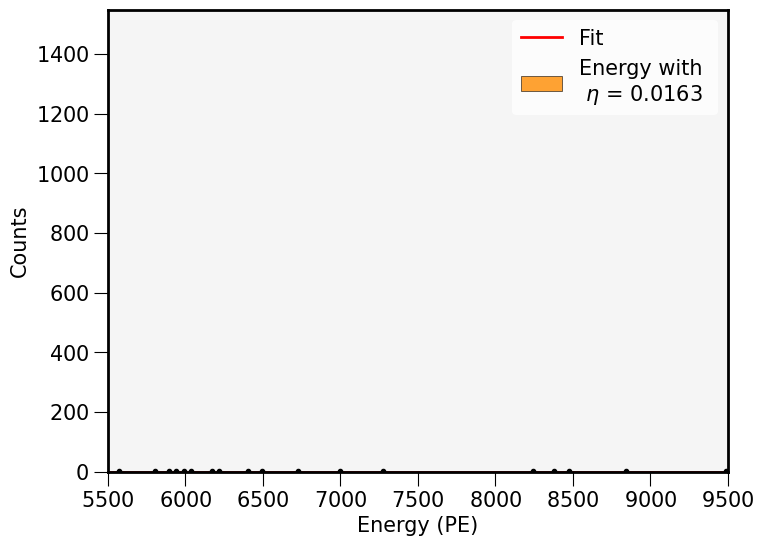

Initial values: [2000, 15474.489795918367, 47.398845537593395, 50, 17658.163265306124, 47.398845537593395]
Final values: [ 1389.25204944 15251.93718945   262.31724032   457.36561256
 16662.64901885   296.69908127]
Energy resolution: 4.0504%


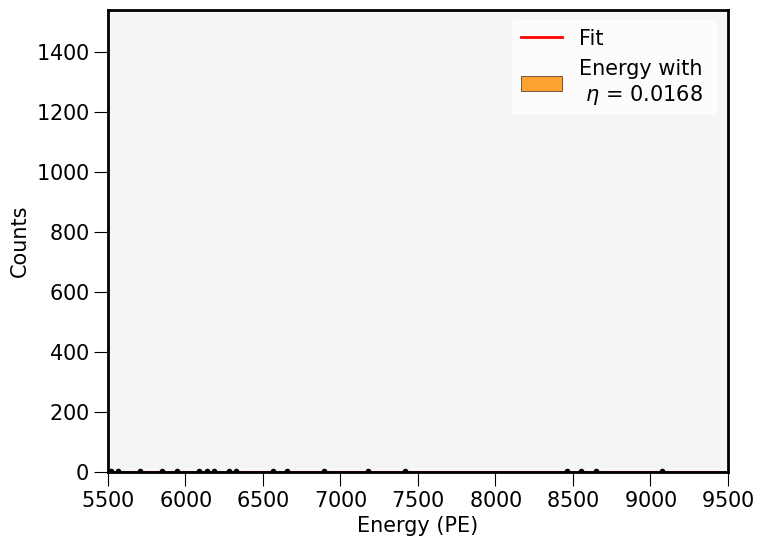

Initial values: [2000, 15897.959183673469, 48.78883548632365, 50, 18132.65306122449, 48.78883548632365]
Final values: [ 1387.35371054 15668.39149575   270.46894365   456.18441701
 17117.59905141  -306.44370172]
Energy resolution: 4.0652%


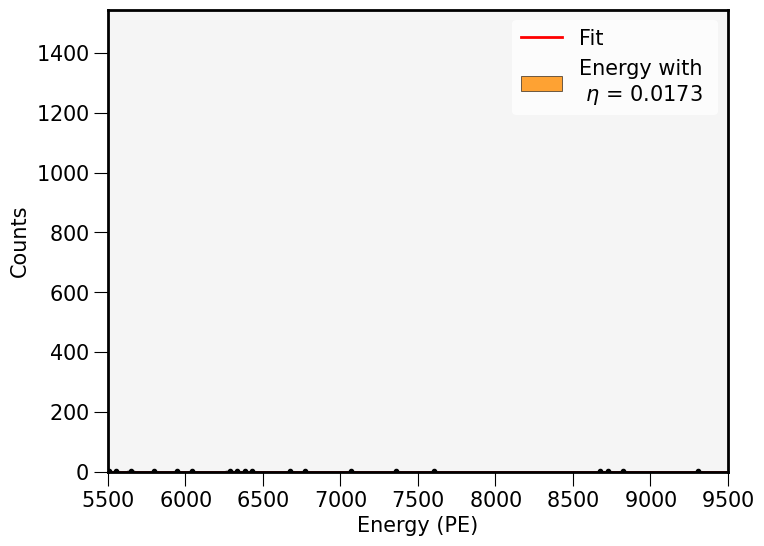

Initial values: [2000, 16321.428571428574, 50.17882543505391, 50, 18607.14285714286, 50.17882543505391]
Final values: [ 1386.43446901 16084.85933853   278.36532716   455.99438085
 17572.66209239   315.34331886]
Energy resolution: 4.0756%


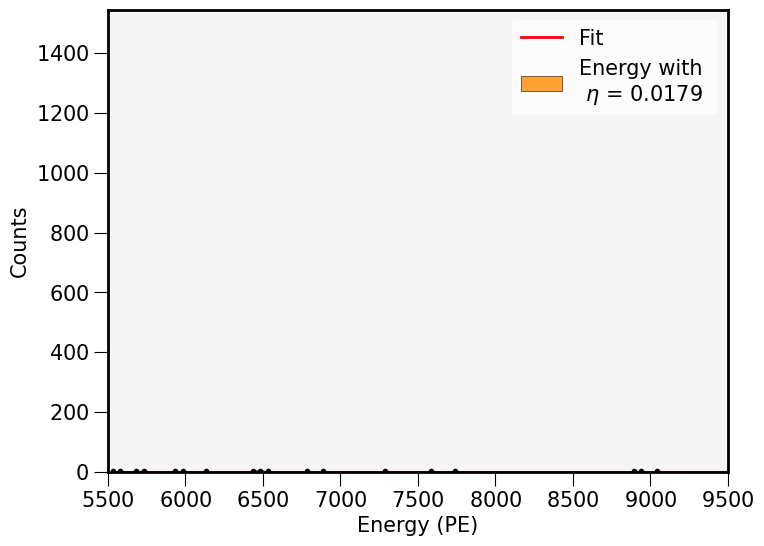

Initial values: [2000, 16744.897959183676, 51.56881538378416, 50, 19081.632653061228, 51.56881538378416]
Final values: [ 1385.32696808 16501.36388157   286.30932945   455.47536187
 18027.35471696   324.67482233]
Energy resolution: 4.0861%


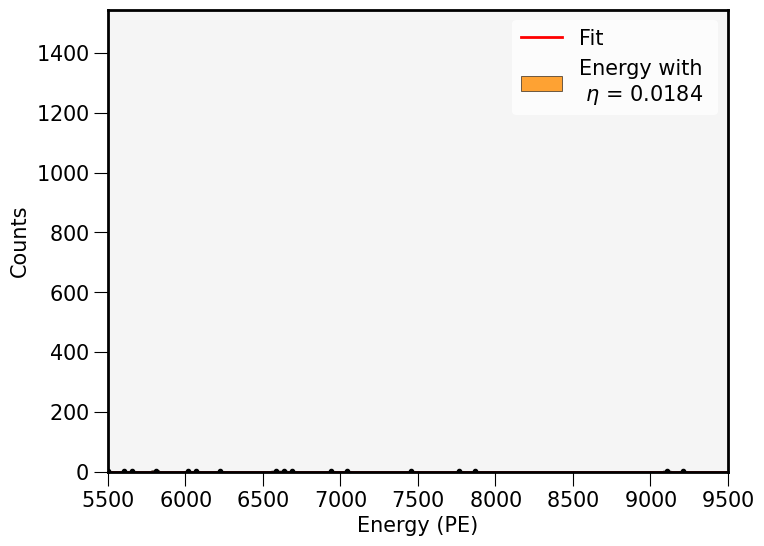

Initial values: [2000, 17168.367346938776, 52.958805332514416, 50, 19556.122448979593, 52.958805332514416]
Final values: [ 1384.23785969 16917.87925655   294.33169045   455.14939887
 18482.28522957  -333.64597287]
Energy resolution: 4.0972%


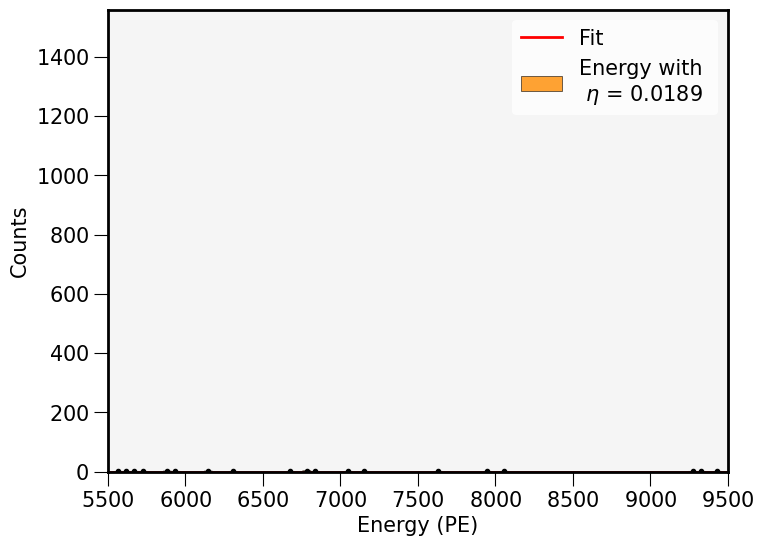

Initial values: [2000, 17591.836734693883, 54.348795281244676, 50, 20030.612244897962, 54.348795281244676]
Final values: [ 1382.1662196  17334.14382723   302.66936613   455.18232553
 18937.30971208  -342.31280691]
Energy resolution: 4.1120%


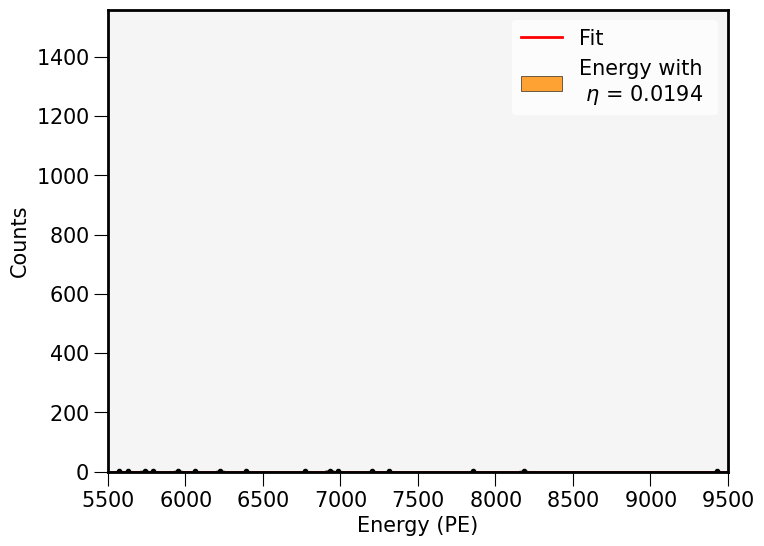

Initial values: [2000, 18015.306122448983, 55.73878522997493, 50, 20505.102040816328, 55.73878522997493]
Final values: [ 1380.5920938  17750.65902857   310.81809778   454.92335653
 19392.23539978  -351.29118839]
Energy resolution: 4.1237%


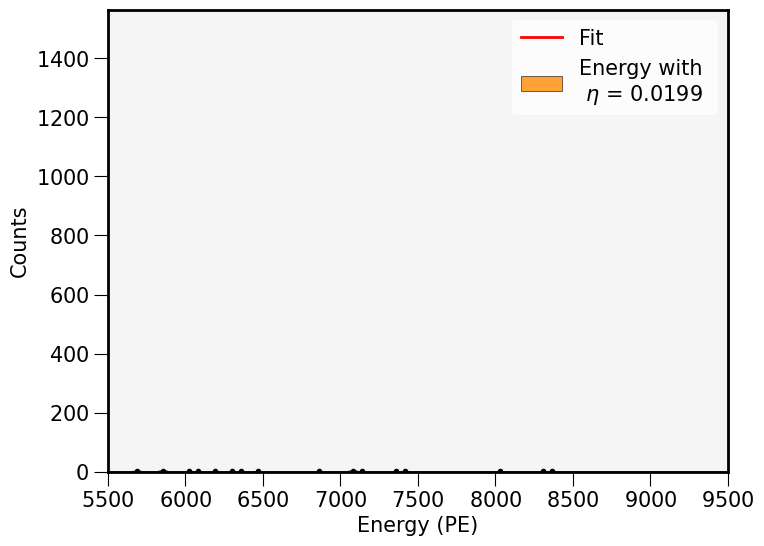

Initial values: [2000, 18438.775510204083, 57.12877517870519, 50, 20979.591836734697, 57.12877517870519]
Final values: [ 1379.32289128 18167.2161747    318.8851067    455.14610066
 19847.29561831   359.70829712]
Energy resolution: 4.1337%


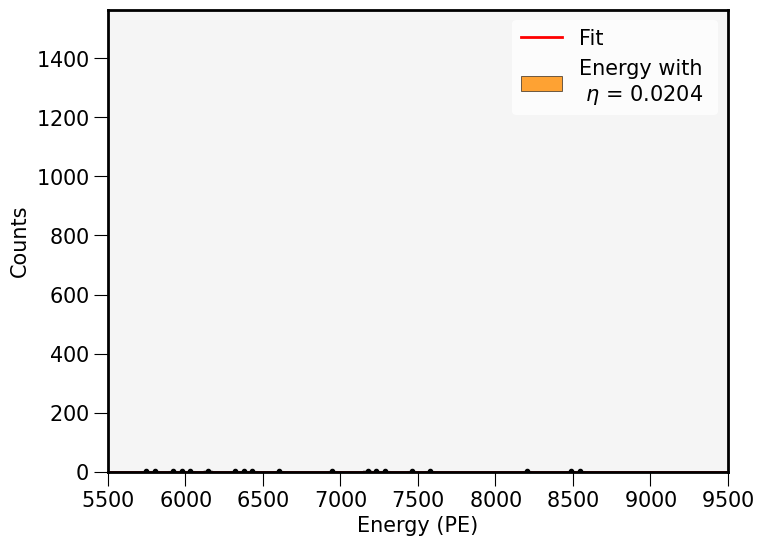

Initial values: [2000, 18862.244897959183, 58.51876512743542, 50, 21454.081632653062, 58.51876512743542]
Final values: [ 1378.38072681 18583.74077332   326.91871616   454.68733229
 20302.22766594  -368.84225492]
Energy resolution: 4.1428%


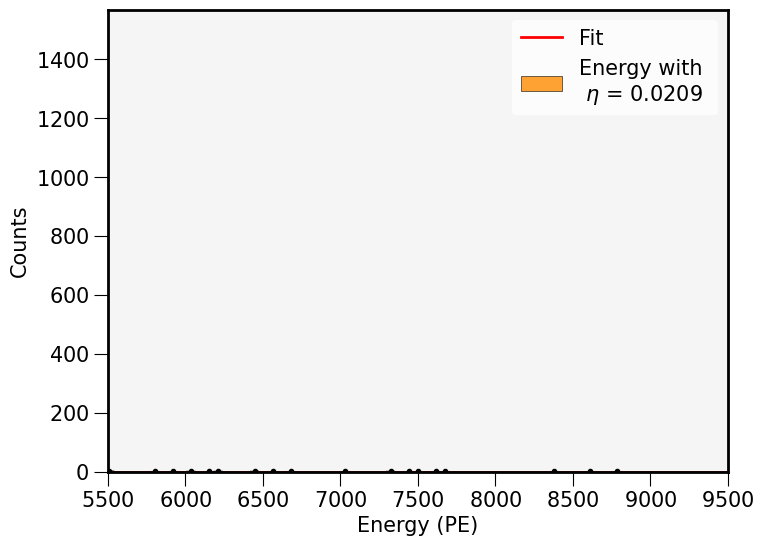

Initial values: [2000, 19285.714285714286, 59.90875507616568, 50, 21928.571428571428, 59.90875507616568]
Final values: [ 1377.17510273 19000.30597757   335.07999122   454.02100991
 20757.34178141   378.13723789]
Energy resolution: 4.1532%


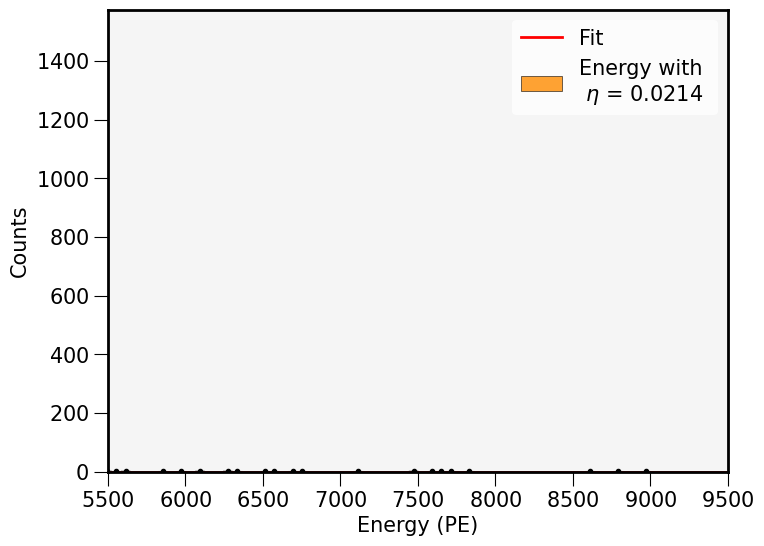

Initial values: [2000, 19709.18367346939, 61.29874502489594, 50, 22403.0612244898, 61.29874502489594]
Final values: [ 1376.18454632 19416.65606152   343.14783915   453.59501515
 21212.14605711   387.34952929]
Energy resolution: 4.1620%


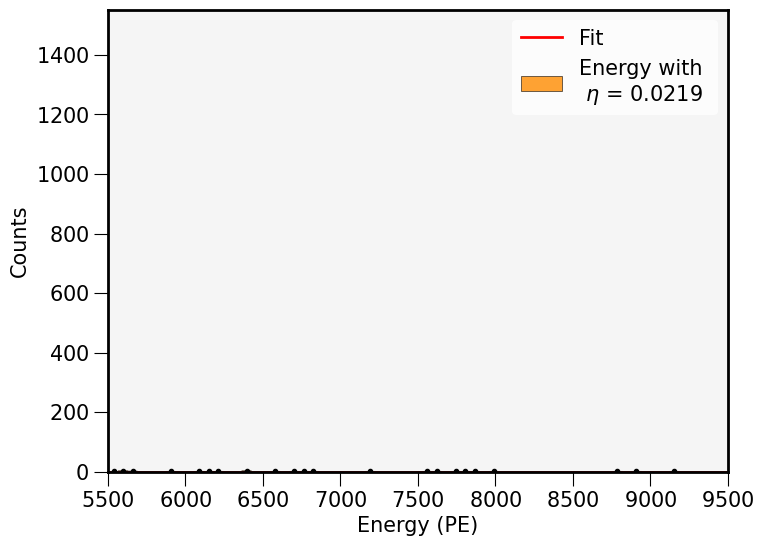

Initial values: [2000, 20132.653061224493, 62.68873497362619, 50, 22877.551020408166, 62.68873497362619]
Final values: [ 1375.54931376 19833.49519957   351.10469344   452.67546517
 21666.65281125   397.11781795]
Energy resolution: 4.1690%


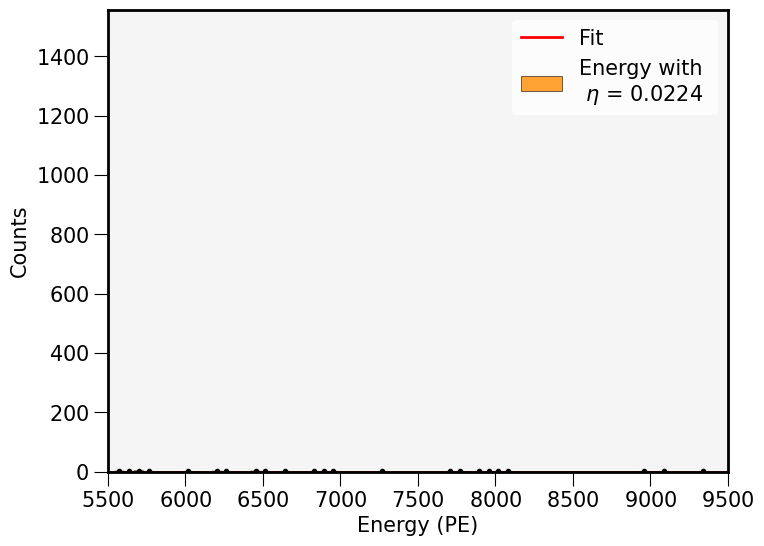

Initial values: [2000, 20556.122448979593, 64.07872492235644, 50, 23352.04081632653, 64.07872492235644]
Final values: [ 1375.27774759 20250.05874078   358.99643704   452.67676989
 22121.37130079   405.83129535]
Energy resolution: 4.1750%


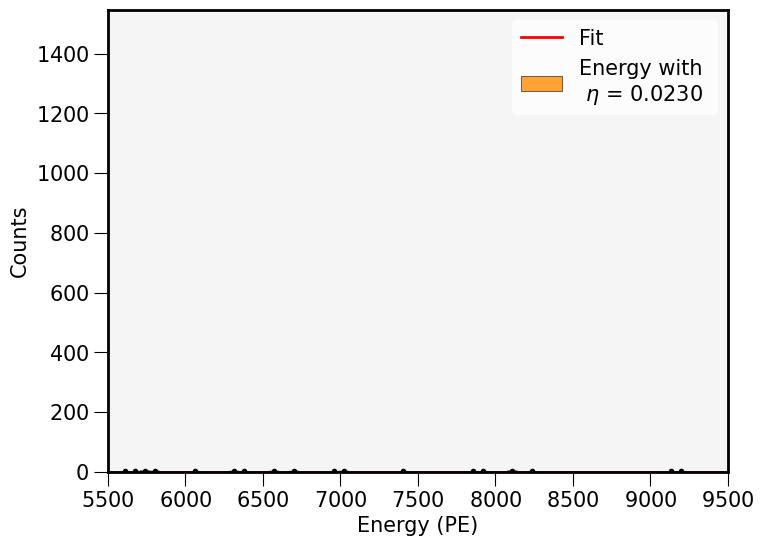

Initial values: [2000, 20979.591836734697, 65.46871487108672, 50, 23826.5306122449, 65.46871487108672]
Final values: [ 1374.17675846 20666.56491614   367.15869214   452.53006278
 22576.24133672   414.80836014]
Energy resolution: 4.1839%


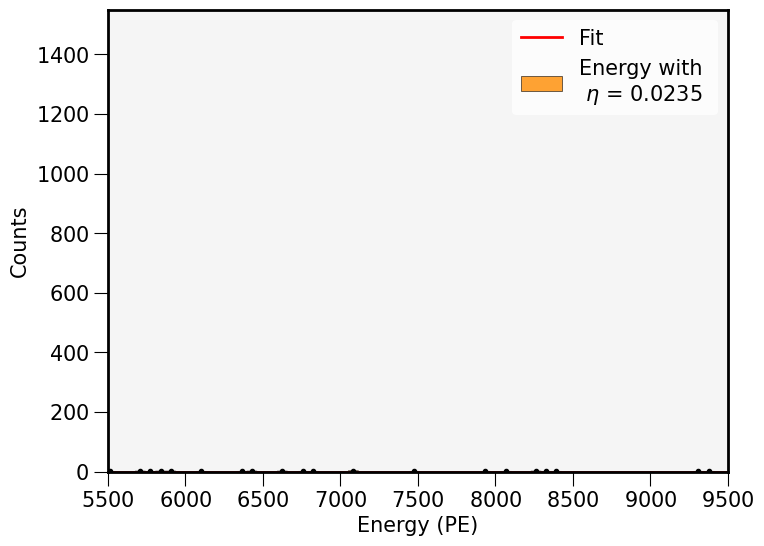

Initial values: [2000, 21403.0612244898, 66.85870481981696, 50, 24301.02040816327, 66.85870481981696]
Final values: [ 1372.67343679 21083.02775377   375.49885842   452.57131706
 23030.98188686   423.39276452]
Energy resolution: 4.1944%


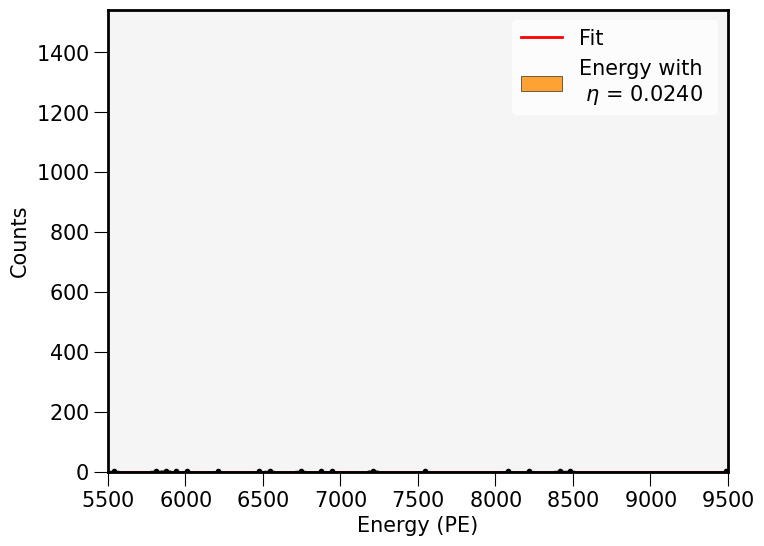

Initial values: [2000, 21826.5306122449, 68.24869476854721, 50, 24775.510204081635, 68.24869476854721]
Final values: [ 1372.08342119 21499.50613857   383.42727899   452.30689226
 23485.40326277   432.54980918]
Energy resolution: 4.2000%


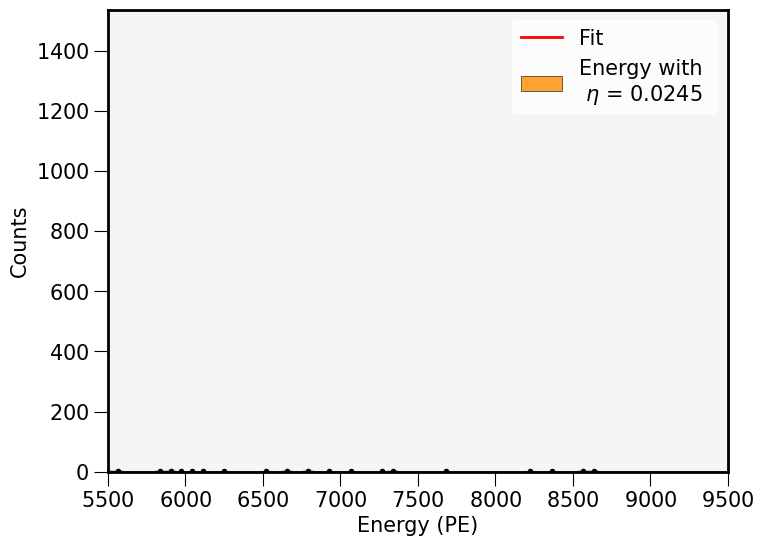

Initial values: [2000, 22250.0, 69.63868471727747, 50, 25250.0, 69.63868471727747]
Final values: [ 1371.09212075 21915.96161234   391.55043763   451.81710351
 23940.0428107   -441.99120027]
Energy resolution: 4.2074%


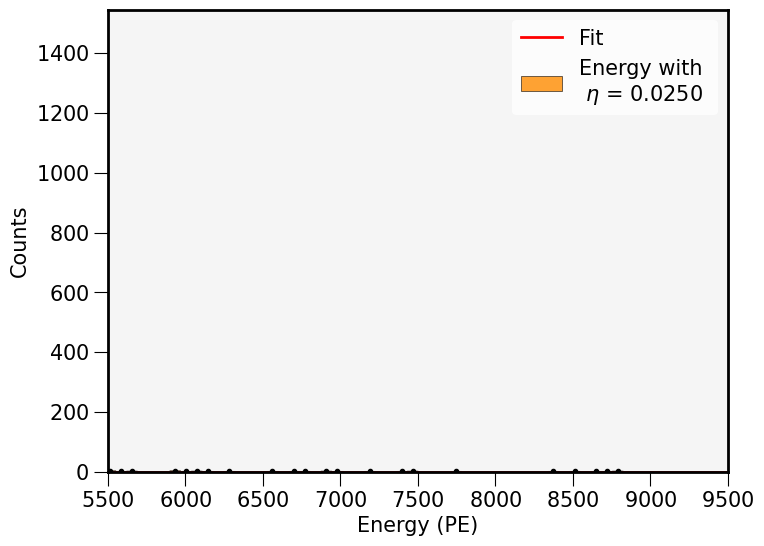

In [67]:
# Global
n_bins  = 750
rad_lim = 400

# Storage of the energy resolution values
E_resolution = []
eta_values = np.linspace(0, 0.025, 50)  # η variation

for eta in eta_values:

    # Run info
    data = ANA_DATA['High_Rn']['df']

    # Variables
    R = data['R']
    E1_corr = data['S1e_corr']
    E2_corr = data['S2e_corr']
    E_total = E1_corr + (E2_corr * eta)     # Energy estimator

    # Masking
    rad_mask = (R <= rad_lim)
    AV_mask  = ANA_DATA['High_Rn']['AV_mask']
    E_mask   = E_total[AV_mask & rad_mask]

    # Histogram
    E_counts, E_edges = np.histogram(E_mask, bins=n_bins)
    bin_width = np.diff(E_edges).mean()

    # ----- Bigaussian Fit ----- #
    # Preliminary
    E_min = 0       # 650e3
    E_max = 2000e3  # 1050e3

    # Filter the data for the fit
    fit_region_mask = (E_mask >= E_min) & (E_mask <= E_max)
    E_fit = E_mask[fit_region_mask]

    # Compute representative values for the fit
    E_centers, x_errors, E_values, y_errors = ff.prefit_1D(E_fit, E_edges)
    # Filter out points with zero error (bins with 1 event)
    valid_points = y_errors > 0
    E_centers = E_centers[valid_points];      x_errors = x_errors[valid_points]
    E_values  = E_values[valid_points];       y_errors = y_errors[valid_points]

    # Fit
    p0 = [2000, 1500 + (eta * 830e3), bin_width, 50, 2000 + (eta * 930e3), bin_width]
    print(f'Initial values: {p0}')
    popt, pcov = curve_fit(ff.bigauss_func, E_centers, E_values, p0=p0)

    # Results
    print(f'Final values: {popt}') 
    perr = np.sqrt(np.diag(pcov))

    # ----- Energy Resolution ----- #
    FWHM = 2.355 * popt[2]
    e_res = (FWHM / popt[1]) * 100
    E_resolution.append(e_res)
    print(f'Energy resolution: {e_res:.4f}%')

    # ----- Plotting ----- #
    plt.figure(figsize=(8, 6))

    # Data
    plt.stairs(E_counts, E_edges, label=f'Energy with \n $\\eta$ = {eta:.4f}', 
               fill=True, color=pt.hist_colors[2], alpha=0.8, lw=0.5, ec='black')
    plt.errorbar(E_centers, E_values, xerr=x_errors, yerr=y_errors, fmt='o', ms=3, c='black', ecolor='black', elinewidth=0.75)
    
    # Fit
    fit_y = ff.bigauss_func(E_centers, *popt)
    plt.plot(E_centers, fit_y, color="red", label="Fit")

    # ----- Styling ----- #
    plt.xlabel('Energy (PE)')
    plt.xlim(5500, 9500)
    plt.ylabel('Counts')
    plt.legend()

    plt.gca().set_facecolor("whitesmoke")
    plt.show()

#### What's the best $\eta$?

The minimum energy resolution is 3.72% at η = 0.0061


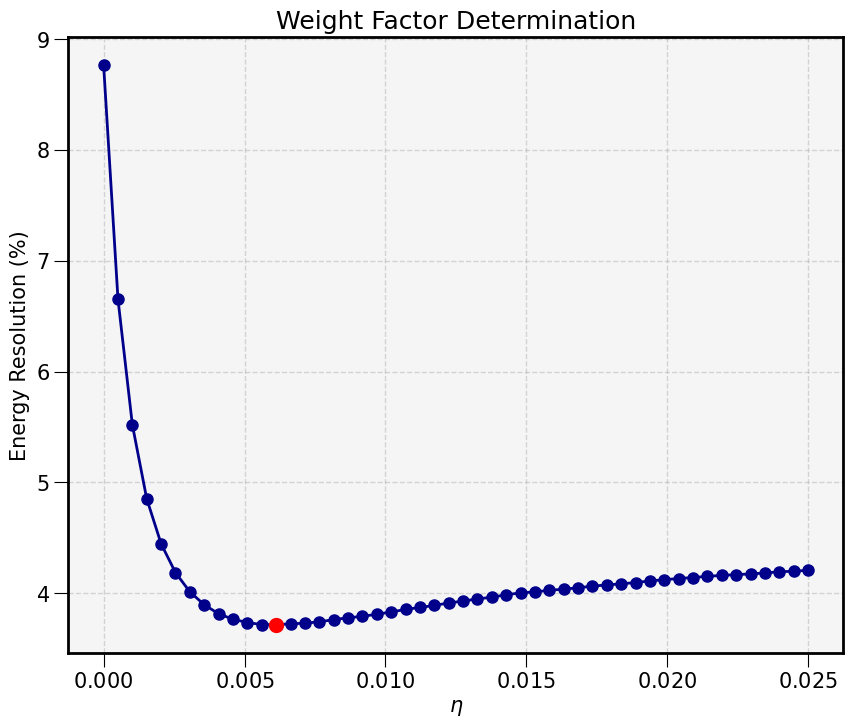

In [69]:
# Find the minimum energy resolution and corresponding eta value
min_index = np.argmin(E_resolution)
Best_eta = eta_values[min_index]
Best_res = E_resolution[min_index]

print(f"The minimum energy resolution is {Best_res:.2f}% at η = {Best_eta:.4f}")

# Store information
ANA_DATA['High_Rn']['eta_CV'] = Best_eta
ANA_DATA['Low_Rn']['eta_CV']  = Best_eta

# Plot
# plt.figure(figsize=(8, 6))
plt.plot(eta_values, E_resolution, c='darkblue', marker='o')
plt.scatter([Best_eta], [Best_res], c='red', zorder=3)
plt.xlabel('$\\eta$')
plt.ylabel('Energy Resolution (%)')
plt.title('Weight Factor Determination')

plt.grid(True)
plt.gca().set_facecolor('whitesmoke')
plt.show()

## $\lambda$ Determination

### High-Rn

High-Rn - Initial values:
222Rn: N_1 = 1.0000, μ_1 = 6500.00 PE, σ_1 = 15.81 PE

High-Rn - Fit values:
222Rn: N_1 = (1.1357e+03 ± 1.0716e+01), μ_1 = (6503.87 ± 0.79) PE, σ_1 = (108.49 ± 0.68) PE
222Rn: λ = 0.8595 keV/PE
χ² / ndof = 5.8440


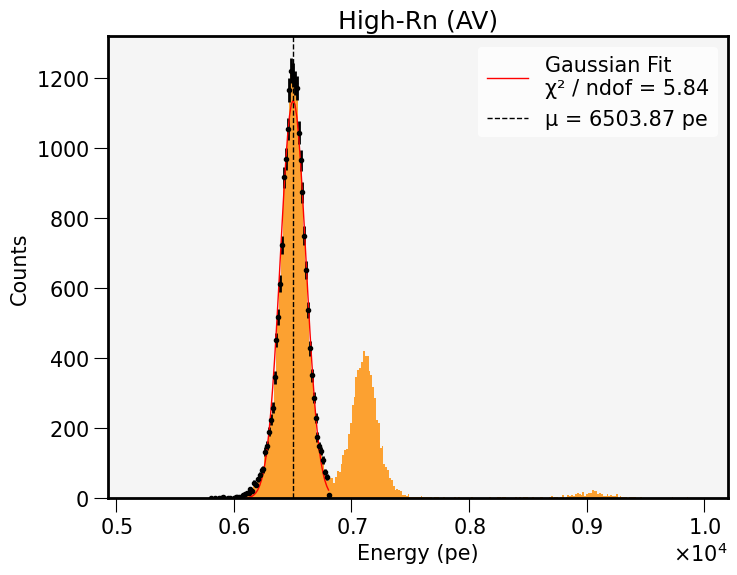

In [70]:
# Global
n_bins  = 1000
rad_lim = 400
E_Rn = 5590.3   # [keV] 222Rn energy peak

# High-Rn info
Rn_data = ANA_DATA['High_Rn']['df']
eta = ANA_DATA['High_Rn']['eta_CV']

# Variables
R = Rn_data['R']
E1_corr = Rn_data['S1e_corr']
E2_corr = Rn_data['S2e_corr']
E_total = E1_corr + (E2_corr * eta)  # Energy estimator

# Masking
rad_mask = (R <= rad_lim)
AV_mask  = ANA_DATA['High_Rn']['AV_mask']
E_mask   = E_total[AV_mask & rad_mask]

# Histogram
E_counts, E_edges = np.histogram(E_mask, bins=n_bins, range=(0, E_total.max()))
bin_width = np.diff(E_edges).mean()

# ----- Gaussian Fit ----- #
# Preliminary
E_min = 5.8e3;  E_max = 6.8e3

# Filter the data for the fit
fit_region_mask = (E_mask >= E_min) & (E_mask <= E_max)
E_fit = E_mask[fit_region_mask]

# Compute representative values for the fit
E_centers, x_errors, E_values, y_errors = ff.prefit_1D(E_fit, E_edges)
# Filter out points with zero error (bins with 1 event)
valid_points = y_errors > 0
E_centers = E_centers[valid_points];      x_errors = x_errors[valid_points]
E_values  = E_values[valid_points];       y_errors = y_errors[valid_points]

# Definte the cost function + initial guess
least_squares = LeastSquares(E_centers, E_values, y_errors, ff.gauss_func)
init_guess    = [1, 6500, bin_width]
print(f'High-Rn - Initial values:')
print(f"222Rn: N_1 = {init_guess[0]:.4f}, μ_1 = {init_guess[1]:.2f} PE, σ_1 = {init_guess[2]:.2f} PE")

# Define the Minuit object
m = Minuit(least_squares, A1=init_guess[0], mu1=init_guess[1], sigma1=init_guess[2])

# Apply soft bounds to the parameters
m.limits['mu1'] = (6250, 6750);  m.limits['sigma1'] = (0.5*bin_width, np.inf)

# Minimization process of the cost function and error estimation
m.migrad()
m.hesse()

# Results
popt = m.values;  perr = m.errors
print(f'\nHigh-Rn - Fit values:')
print(f"222Rn: N_1 = ({popt[0]:.4e} ± {perr[0]:.4e}), μ_1 = ({popt[1]:.2f} ± {perr[1]:.2f}) PE, σ_1 = ({popt[2]:.2f} ± {perr[2]:.2f}) PE")

# Lambda value
High_lambda = E_Rn / (popt[1])
print(f"222Rn: λ = {High_lambda:.4f} keV/PE")
ANA_DATA['High_Rn']['lambda_CV'] = High_lambda

# Reduced chi-square
chi2 = m.fval
ndof = len(E_centers) - m.nfit
print(f"χ² / ndof = {chi2 / ndof:.4f}")

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))

# Data 
plt.bar(E_edges[:-1], E_counts, width=bin_width, align='edge',
        color=pt.hist_colors[2], alpha=0.8, lw=1.0)

# Fit
y_fit = ff.gauss_func(E_centers, *popt)
plt.errorbar(E_centers, E_values, yerr=y_errors, fmt='o', ms=3, c='black', ecolor='black')                                 
plt.plot(E_centers, y_fit, color="red", lw=1.0, label=f'Gaussian Fit\nχ² / ndof = {chi2 / ndof:.2f}')
plt.axvline(x=popt[1], c='black', alpha=1, ls='--', lw=1.0, label=f'μ = {popt[1]:.2f} pe')

# Styling                      
plt.xlabel('Energy (pe)')
plt.xlim(0.85*E_min, 1.5*E_max)
plt.ylabel('Counts')
# plt.yscale('log')
plt.title(f'High-Rn (AV)')
plt.legend(loc='upper right')    
plt.gca().set_facecolor("whitesmoke")

# plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.show()

### Low-Rn

Low-Rn - Initial values:
222Rn: N_1 = 1.0000, μ_1 = 7000.00 PE, σ_1 = 22.08 PE

Low-Rn - Fit values:
222Rn: N_1 = (6.3733e+02 ± 8.5581e+00), μ_1 = (7223.63 ± 1.38) PE, σ_1 = (134.42 ± 1.20) PE
222Rn: λ = 0.7739 keV/PE
χ² / ndof = 3.8235


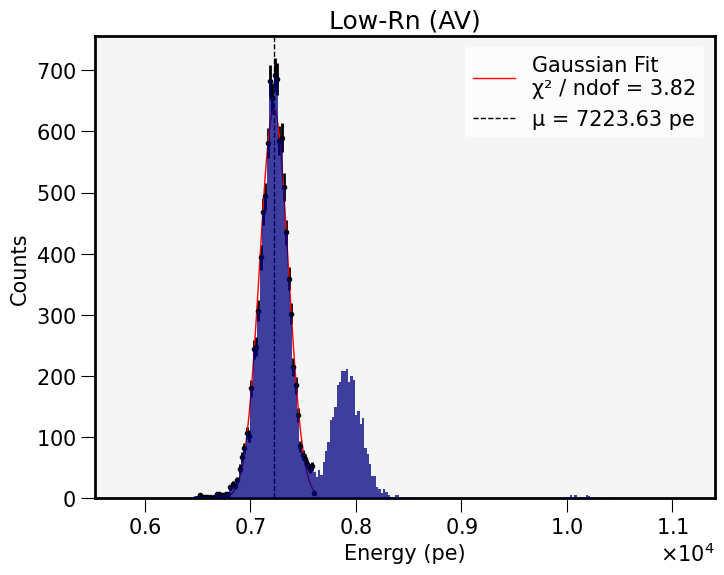

In [71]:
# Global
n_bins  = 1000
rad_lim = 400
E_Rn = 5590.3   # [keV] 222Rn energy peak

# Low-Rn info
Rn_data = ANA_DATA['Low_Rn']['df']
eta = ANA_DATA['Low_Rn']['eta_CV']

# Variables
R = Rn_data['R']
E1_corr = Rn_data['S1e_corr']
E2_corr = Rn_data['S2e_corr']
E_total = E1_corr + (E2_corr * eta)  # Energy estimator

# Masking
rad_mask = (R <= rad_lim)
AV_mask  = ANA_DATA['Low_Rn']['AV_mask']
E_mask   = E_total[AV_mask & rad_mask]

# Histogram
E_counts, E_edges = np.histogram(E_mask, bins=n_bins, range=(0, E_total.max()))
bin_width = np.diff(E_edges).mean()

# ----- Gaussian Fit ----- #
# Preliminary
E_min = 6.5e3;  E_max = 7.6e3

# Filter the data for the fit
fit_region_mask = (E_mask >= E_min) & (E_mask <= E_max)
E_fit = E_mask[fit_region_mask]

# Compute representative values for the fit
E_centers, x_errors, E_values, y_errors = ff.prefit_1D(E_fit, E_edges)
# Filter out points with zero error (bins with 1 event)
valid_points = y_errors > 0
E_centers = E_centers[valid_points];      x_errors = x_errors[valid_points]
E_values  = E_values[valid_points];       y_errors = y_errors[valid_points]

# Definte the cost function + initial guess
least_squares = LeastSquares(E_centers, E_values, y_errors, ff.gauss_func)
init_guess    = [1, 7000, bin_width]
print(f'Low-Rn - Initial values:')
print(f"222Rn: N_1 = {init_guess[0]:.4f}, μ_1 = {init_guess[1]:.2f} PE, σ_1 = {init_guess[2]:.2f} PE")

# Define the Minuit object
m = Minuit(least_squares, A1=init_guess[0], mu1=init_guess[1], sigma1=init_guess[2])

# Apply soft bounds to the parameters
m.limits['mu1'] = (6750, 7250);  m.limits['sigma1'] = (0.5*bin_width, np.inf)

# Minimization process of the cost function and error estimation
m.migrad()
m.hesse()

# Results
popt = m.values;  perr = m.errors
print(f'\nLow-Rn - Fit values:')
print(f"222Rn: N_1 = ({popt[0]:.4e} ± {perr[0]:.4e}), μ_1 = ({popt[1]:.2f} ± {perr[1]:.2f}) PE, σ_1 = ({popt[2]:.2f} ± {perr[2]:.2f}) PE")

# Lambda value
Low_lambda = E_Rn / (popt[1])
print(f"222Rn: λ = {Low_lambda:.4f} keV/PE")
ANA_DATA['Low_Rn']['lambda_CV'] = Low_lambda

# Reduced chi-square
chi2 = m.fval
ndof = len(E_centers) - m.nfit
print(f"χ² / ndof = {chi2 / ndof:.4f}")

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))

# Data 
plt.bar(E_edges[:-1], E_counts, width=bin_width, align='edge',
        color=pt.hist_colors[5], alpha=0.75, lw=1.0, zorder=3)

# Fit
y_fit = ff.gauss_func(E_centers, *popt)
plt.errorbar(E_centers, E_values, yerr=y_errors, fmt='o', ms=3, c='black', ecolor='black')                                 
plt.plot(E_centers, y_fit, color="red", lw=1.0, label=f'Gaussian Fit\nχ² / ndof = {chi2 / ndof:.2f}')
plt.axvline(x=popt[1], c='black', alpha=1.0, ls='--', lw=1.0, label=f'μ = {popt[1]:.2f} pe')

# Styling                      
plt.xlabel('Energy (pe)')
plt.xlim(0.85*E_min, 1.5*E_max)
plt.ylabel('Counts')
# plt.yscale('log')
plt.title(f'Low-Rn (AV)')
plt.legend(loc='upper right') 

plt.gca().set_facecolor("whitesmoke")
plt.show()

# α-Producing Isotopes

### Configuration

In [76]:
# Choose your period of interest
PERIOD = 'Low_Rn'   # 'High_Rn' or 'Low_Rn'

# ----- Period Information ----- #
# Data information
Rn_data        = ANA_DATA[PERIOD]['df']
Rn_long        = ANA_DATA[PERIOD]['duration_CV']
Alpha_rate_CV  = ANA_DATA[PERIOD]['alpha_rate_CV']
Alpha_rate_err = ANA_DATA[PERIOD]['alpha_rate_err']

# Active volume
AV_mask       = ANA_DATA[PERIOD]['AV_mask']
DT_stop_CV    = ANA_DATA[PERIOD]['DTstop_CV']
DT_stop_err   = ANA_DATA[PERIOD]['DTstop_err']
Drift_vel_CV  = ANA_DATA[PERIOD]['drift_vel_CV']
Drift_vel_err = ANA_DATA[PERIOD]['drift_vel_err']
Rad_lim = 400       # in [mm]

# Energy Estimator
Eta_CV        = ANA_DATA[PERIOD]['eta_CV']
Lambda_CV     = ANA_DATA[PERIOD]['lambda_CV']

### Histogram

In [77]:
# Global
n_bins = 250

# Variables
R = Rn_data['R']
E1_corr = Rn_data['S1e_corr']
E2_corr = Rn_data['S2e_corr']
E_total = Lambda_CV * (E1_corr + (E2_corr * Eta_CV))        # Energy estimator

# Masking
rad_mask = (R <= Rad_lim)
E_mask   = E_total[AV_mask & rad_mask]

# Histogram: normalized by corrected DAQ data taking time
E_counts, E_edges = np.histogram(E_mask, bins=n_bins, range=(E_mask.min(), E_mask.max()))
E_rate  = E_counts / Rn_long
E_error = np.sqrt(E_counts) / Rn_long       # Only statistical error
bin_width = np.diff(E_edges).mean()

# ----- Selection Rate ----- #
sel_rate_CV  = np.sum(E_rate)                       
sel_rate_err = np.sqrt(np.sum(E_error**2))
print(f'{PERIOD}:\n Energy window  = [{E_mask.min():.2f}, {E_mask.max():.2f}] keV\n Selection rate = ({sel_rate_CV:.4f} ± {sel_rate_err:.4f}) Hz')

Low_Rn:
 Energy window  = [1011.96, 9983.81] keV
 Selection rate = (0.0485 ± 0.0004) Hz


### Tri-Gaussian Fit

In [78]:
# # Filter the data for the fit
# fit_region_mask = (E_mask >= E_min) & (E_mask <= E_max)
# E_fit = E_mask[fit_region_mask]

# Compute representative values for the fit: remember, we're working with rates!
x_centers, x_errors, y_values, y_errors = ff.prefit_1D(E_mask, bins=E_edges)
y_values = y_values.astype(np.float64)      # We divide by a float: Rn_long
y_values /= Rn_long
y_errors /= Rn_long

# Filter out poitns with zero error
valid_points = y_errors > 0
x_centers = x_centers[valid_points];    x_errors = x_errors[valid_points]
y_values  = y_values[valid_points];     y_errors = y_errors[valid_points]

# Definte the cost function + initial guess
least_squares = LeastSquares(x_centers, y_values, y_errors, ff.trigauss_func)
init_guess    = [1, 5600, bin_width, 1, 6100, bin_width, 1, 7850, bin_width]
print(f'{PERIOD} - Initial values:\n')
print(f"222Rn: N_1 = {init_guess[0]:.2f} Hz, μ_1 = {init_guess[1]:.2f} keV, σ_1 = {init_guess[2]:.2f} keV")
print(f"218Po: N_2 = {init_guess[3]:.2f} Hz, μ_2 = {init_guess[4]:.2f} keV, σ_2 = {init_guess[5]:.2f} keV")
print(f"214Po: N_3 = {init_guess[6]:.2f} Hz, μ_3 = {init_guess[7]:.2f} keV, σ_3 = {init_guess[8]:.2f} keV\n")

# Define the Minuit object
m = Minuit(least_squares, A1=init_guess[0], mu1=init_guess[1], sigma1=init_guess[2],
                          A2=init_guess[3], mu2=init_guess[4], sigma2=init_guess[5],
                          A3=init_guess[6], mu3=init_guess[7], sigma3=init_guess[8])

# Apply soft bounds to the parameters
m.limits['mu1'] = (5400, 5800);  m.limits['sigma1'] = (0.5*bin_width, np.inf)
m.limits['mu2'] = (5900, 6300);  m.limits['sigma2'] = (0.5*bin_width, np.inf)
m.limits['mu3'] = (7550, 8150);  m.limits['sigma3'] = (0.5*bin_width, np.inf)

# Minimization process of the cost function and error estimation
m.migrad()
m.hesse()

# Results
popt = m.values;  perr = m.errors
print(f'{PERIOD} - Fit values:\n')
print(f"222Rn: N_1 = ({popt[0]:.4e} ± {perr[0]:.4e}) Hz, μ_1 = ({popt[1]:.2f} ± {perr[1]:.2f}) keV, σ_1 = ({popt[2]:.2f} ± {perr[2]:.2f}) keV")
print(f"218Po: N_2 = ({popt[3]:.4e} ± {perr[3]:.4e}) Hz, μ_2 = ({popt[4]:.2f} ± {perr[4]:.2f}) keV, σ_2 = ({popt[5]:.2f} ± {perr[5]:.2f}) keV")
print(f"214Po: N_3 = ({popt[6]:.4e} ± {perr[6]:.4e}) Hz, μ_3 = ({popt[7]:.2f} ± {perr[7]:.2f}) keV, σ_3 = ({popt[8]:.2f} ± {perr[8]:.2f}) keV")

# Reduced chi-square
chi2 = m.fval
ndof = len(x_centers) - m.nfit
print(f"χ² / ndof = {chi2 / ndof:.4f}")

# ----- Store Fit Results ----- #
Isotopes = {name: {key: val for key, val in zip(['N_CV', 'mu_CV', 'sigma_CV', 'N_err', 'mu_err', 'sigma_err'], popt[i:i+3] + perr[i:i+3])} 
            for i, name in zip(range(0, 9, 3), ['222Rn', '218Po', '214Po'])}
ANA_DATA[PERIOD]['Isotopes'] = Isotopes

Low_Rn - Initial values:

222Rn: N_1 = 1.00 Hz, μ_1 = 5600.00 keV, σ_1 = 35.89 keV
218Po: N_2 = 1.00 Hz, μ_2 = 6100.00 keV, σ_2 = 35.89 keV
214Po: N_3 = 1.00 Hz, μ_3 = 7850.00 keV, σ_3 = 35.89 keV

Low_Rn - Fit values:

222Rn: N_1 = (4.8698e-03 ± 6.5848e-05) Hz, μ_1 = (5589.71 ± 1.08) keV, σ_1 = (103.91 ± 0.97) keV
218Po: N_2 = (1.5441e-03 ± 3.5558e-05) Hz, μ_2 = (6121.02 ± 2.08) keV, σ_2 = (111.13 ± 1.82) keV
214Po: N_3 = (1.5400e-05 ± 3.7267e-06) Hz, μ_3 = (7865.75 ± 30.45) keV, σ_3 = (180.96 ± 44.73) keV
χ² / ndof = 2.2678


### Rn Activity

In [79]:
print(f'{PERIOD} Results:\n')
# Compute the integral of each gaussian + error
Proportions = {"222Rn": {"CV": 0.0, "Error": 0.0}, "218Po": {"CV": 0.0, "Error": 0.0}, "214Po": {"CV": 0.0, "Error": 0.0}}
param_name_list = [['A1', 'mu1', 'sigma1'], ['A2', 'mu2', 'sigma2'], ['A3', 'mu3', 'sigma3']]

for i, (isotope, values) in enumerate(ANA_DATA[PERIOD]['Isotopes'].items()):

    print(f'Computing integral for {isotope}:')
    # Fit parameters name to use Minuit object
    param_names  = param_name_list[i]
    # Intregate within selected energy window
    integral_CV, integral_err = ff.gauss_int_err(values['N_CV'], values['mu_CV'], values['sigma_CV'], E_mask.min(), E_mask.max(), 
                                                 param_names, minuit_object=m)
    # IT'S AN AREA (Hz*keV): divide by bin width to get rate
    fit_rate_CV  = integral_CV / bin_width
    fit_rate_err = integral_err / bin_width
    print(f"  Fit rate: R = ({fit_rate_CV:.5f} ± {fit_rate_err:.5f}) Hz")

    # Compute the proportions
    if isotope == '222Rn':
        rate_222_CV = fit_rate_CV;  rate_222_err = fit_rate_err      # For each isotope wrt 222Rn
        # Rn Fraction wrt Selection Rate
        Rn_Fraction_CV  = fit_rate_CV / sel_rate_CV
        Rn_Fraction_err = Rn_Fraction_CV * np.sqrt((fit_rate_err / fit_rate_CV)**2 + (sel_rate_err / sel_rate_CV)**2)
        print(f"  Fraction wrt sel. rate: F = {Rn_Fraction_CV:.4f} ± {Rn_Fraction_err:.4f}")

    # Store proportions
    Proportions[isotope]['CV']    = fit_rate_CV / rate_222_CV
    Proportions[isotope]['Error'] = Proportions[isotope]['CV'] * np.sqrt((fit_rate_err / fit_rate_CV)**2 + (rate_222_err / rate_222_CV)**2)
    print(f"  Proportion wrt 222Rn fit rate: α = {Proportions[isotope]['CV']:.4f} ± {Proportions[isotope]['Error']:.4f}")

# ----- 222Rn Total Rate ----- #
print(f"\nAlpha trigger rate = {Alpha_rate_CV:.4f} ± {Alpha_rate_err:.4f} Hz")
Rn_rate_CV  = Alpha_rate_CV * Rn_Fraction_CV
Rn_rate_err = Rn_rate_CV * np.sqrt((Alpha_rate_err / Alpha_rate_CV)**2 + (Rn_Fraction_err / Rn_Fraction_CV)**2)
print(f"222Rn total rate = {Rn_rate_CV:.4f} ± {Rn_rate_err:.4f} Hz")

# ----- 222Rn Activity ----- #
# Active volume
z_lim_CV  = Drift_vel_CV * DT_stop_CV
z_lim_err = z_lim_CV * np.sqrt((Drift_vel_err /Drift_vel_CV)**2 + (DT_stop_err / DT_stop_CV)**2)
NEXT_vol_CV, NEXT_vol_err = pt.selection_volume(z_lim_CV, z_lim_err, Rad_lim, 1)            # DO NOT USE THIS ERROR
print(f"Selection volume = {NEXT_vol_CV * 1e-9:.4f} ± {NEXT_vol_err * 1e-9:.4f} m³")

# Compute the activity in Bq/m³
Rn_activity_CV  = Rn_rate_CV / (NEXT_vol_CV * 1e-9)
Rn_activity_err = Rn_rate_err / (NEXT_vol_CV * 1e-9)
print(f"222Rn activity = {Rn_activity_CV:.4f} ± {Rn_activity_err:.4f} Bq / m³")

Low_Rn Results:

Computing integral for 222Rn:
  Fit rate: R = (0.03534 ± 0.00036) Hz
  Fraction wrt sel. rate: F = 0.7282 ± 0.0097
  Proportion wrt 222Rn fit rate: α = 1.0000 ± 0.0144
Computing integral for 218Po:
  Fit rate: R = (0.01199 ± 0.00021) Hz
  Proportion wrt 222Rn fit rate: α = 0.3391 ± 0.0069
Computing integral for 214Po:
  Fit rate: R = (0.00019 ± 0.00003) Hz
  Proportion wrt 222Rn fit rate: α = 0.0055 ± 0.0008

Alpha trigger rate = 1.1892 ± 0.1300 Hz
222Rn total rate = 0.8660 ± 0.0954 Hz
Selection volume = 0.5728 ± 0.0062 m³
222Rn activity = 1.5118 ± 0.1666 Bq / m³


### Bi in AV

In [80]:
Bi_CV  = Proportions['214Po']['CV'] / (Proportions['218Po']['CV']**2)
Bi_err = Bi_CV * np.sqrt((Proportions['214Po']['Error'] / Proportions['214Po']['CV'])**2 + (2 * Proportions['218Po']['Error'] / Proportions['218Po']['CV'])**2)
print(f"Bi activity: {Bi_CV:.4%} ± {Bi_err:.4%}")

Bi activity: 4.7893% ± 0.7477%


### Plot

In [81]:
Rn222_perc = Proportions['222Rn']['CV']
Po218_perc = Proportions['218Po']['CV']
Po214_perc = Proportions['214Po']['CV']

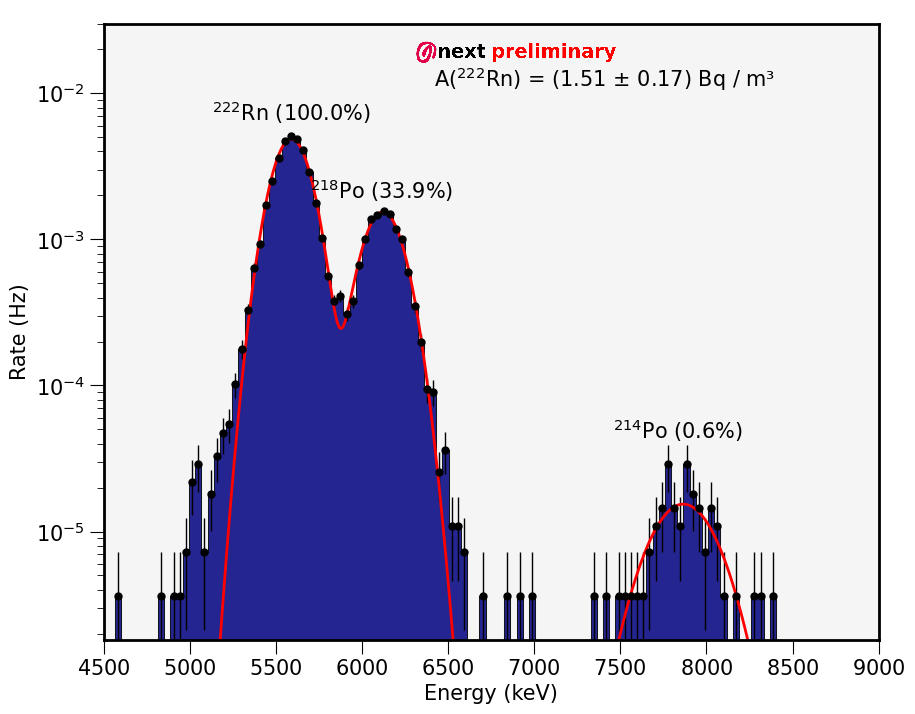

In [85]:
# ----- Plotting ----- #
fig, ax = plt.subplots()
# Data
color_hist = pt.hist_colors[2] if PERIOD == 'High_Rn' else pt.hist_colors[5]
plt.stairs(E_rate, E_edges, fill=True, color=color_hist, alpha=0.85, ec='black', lw=0.75)

# Fit
x_fit = np.linspace(x_centers.min(), x_centers.max(), 1000)
y_fit = ff.trigauss_func(x_fit, *popt)
plt.plot(x_fit, y_fit, color="red", label=f"Tri-Gaussian Fit\nχ² / ndof = {chi2 / ndof:.2f}")
plt.errorbar(x_centers, y_values, xerr=x_errors, yerr=y_errors, fmt='o', c='black', ms=5, ecolor='black', elinewidth=1.0)

# ----- Styling ----- #
# Important text
y_text = [1.75e-1, 1e-1, 3.5e-2, 1.75e-3] if PERIOD == 'High_Rn' else [1.25e-2, 6e-3, 1.75e-3, 4e-5]
plt.text(8.40e3, y_text[0], r'A($^{222}$Rn)'f' = ({Rn_activity_CV:.2f} ± {Rn_activity_err:.2f}) Bq / m³', va='center', ha='right')
plt.text(5590, y_text[1], r'$^{222}$Rn'f' ({Rn222_perc:.1%})', va='bottom', ha='center')
plt.text(6115, y_text[2], r'$^{218}$Po'f' ({Po218_perc:.1%})', va='bottom', ha='center')
plt.text(7834, y_text[3], r'$^{214}$Po'f' ({Po214_perc:.1%})', va='bottom', ha='center')

# Preliminary logo
LOGO_BOX = OffsetImage(PRELIM_LOGO, zoom = 0.1)
xy = (E_max, E_rate.max())
ab = AnnotationBbox(LOGO_BOX, xy, xybox=(-85, 50 if PERIOD == 'High_Rn' else 60), xycoords='data', boxcoords="offset points",  frameon=False)
ax.add_artist(ab)

plt.xlabel('Energy (keV)')
plt.xlim(4.5e3, 9e3)
plt.ylabel('Rate (Hz)')
plt.ylim(y_values.min()-(y_errors.min()/2), 5e-1 if PERIOD == 'High_Rn' else 3e-2)
plt.yscale('log')
# plt.title(f'{PERIOD} (AV)')   
# plt.legend(loc='upper right')

plt.gca().set_facecolor("whitesmoke")
plt.savefig(f'/lhome/ific/c/ccortesp/Analysis/NEXT-100/Rn_analysis/images/{PERIOD}_Energy.pdf')
plt.show()